In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('INFO')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import wfsc_tests as wfsc
wfsc.math_module.update_np(cp)
wfsc.math_module.update_scipy(cupyx.scipy)

from wfsc_tests.math_module import xp, _scipy

import cgi_phasec_poppy as cgi
reload(cgi)

from matplotlib.colors import ListedColormap
#Blue to Red Color scale for S1 and S2
colmap = np.zeros((255,3));
# Red
colmap[126:183,0]= np.linspace(0,1,57);
colmap[183:255,0]= 1;
# Green
colmap[0:96,1] = np.linspace(1,0,96);
colmap[158:255,1]= np.linspace(0,1,97);
# Blue
colmap[0:71,2] = 1;
colmap[71:128,2]= np.linspace(1,0,57);
colmap2 = colmap[128:,:]
colmap = ListedColormap(colmap)

iefc_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')

dm1_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

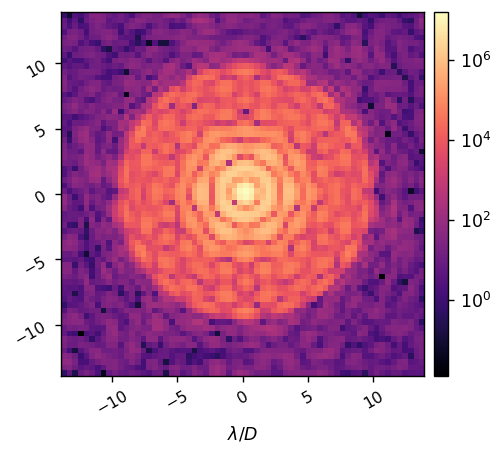

15167884.4713195

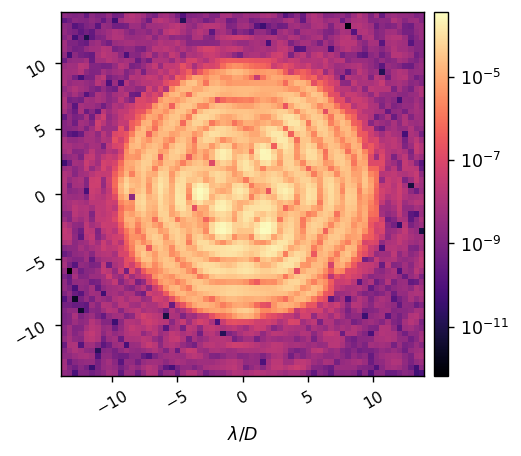

In [2]:
reload(cgi)

source_flux = 2.0208517e8 * u.ph/u.s/u.m**2 # flux of 47 UMa at 575nm with 10% bandpass

c = cgi.CGI(cgi_mode='hlc', 
              use_pupil_defocus=True, 
              use_opds=True,
              source_flux=source_flux,
            exp_time=5)

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

npsf = c.npsf
Nact = c.Nact

c.use_fpm = False
ref_unocc_im = c.snap()
wfsc.imshow1(ref_unocc_im, pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = ref_unocc_im.get().max()
display(max_ref)

c.use_fpm = True
c.source_flux = source_flux/max_ref # divide the source flux to get nominal contrast images
ref_im = c.snap()
wfsc.imshow1(ref_im, pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

# Create dark hole ROI to calibrate and control

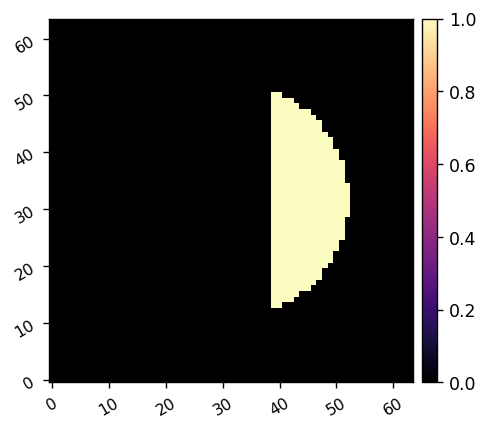

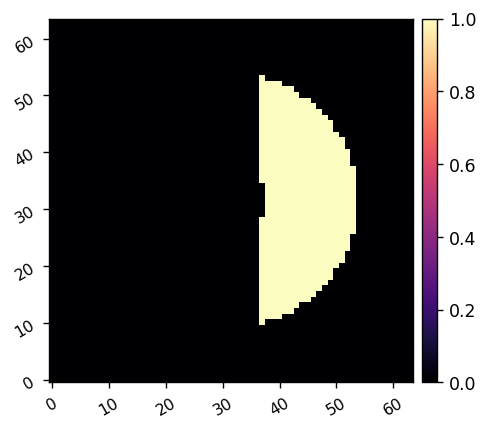

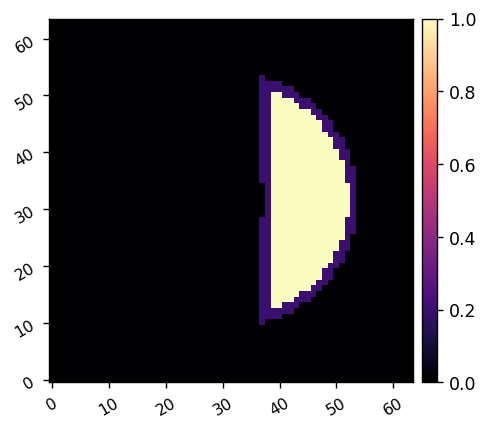

In [4]:
reload(wfsc)
reload(wfsc.utils)
reload(wfsc.imshows)
xfp = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*c.psf_pixelscale_lamD
fpx,fpy = xp.meshgrid(xfp,xfp)
  
iwa = 3
owa = 9
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 3,
        'rotation':0,
        'full':True,
    }
roi1 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = 2.8
owa = 9.7
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi2 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

# wfsc.imshow2(roi1, roi2)
relative_weight = 0.2
weight_map = roi1 + relative_weight*(roi2 * ~roi1)
control_mask = weight_map>0
wfsc.imshow1(weight_map)

# Create probe and fourier modes

(384, 2304) (192, 2)


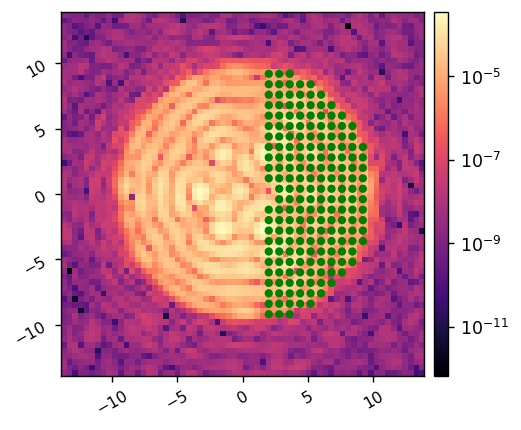

In [5]:
reload(wfsc.utils)
calib_amp = 5e-9
fourier_modes, fs = wfsc.utils.select_fourier_modes(c, control_mask*(fpx>0), fourier_sampling=0.8) 
nmodes = fourier_modes.shape[0]
nf = nmodes//2
print(fourier_modes.shape, fs.shape)

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))
    
wfsc.imshow1(ref_im, lognorm=True, pxscl=c.psf_pixelscale_lamD, patches=patches)

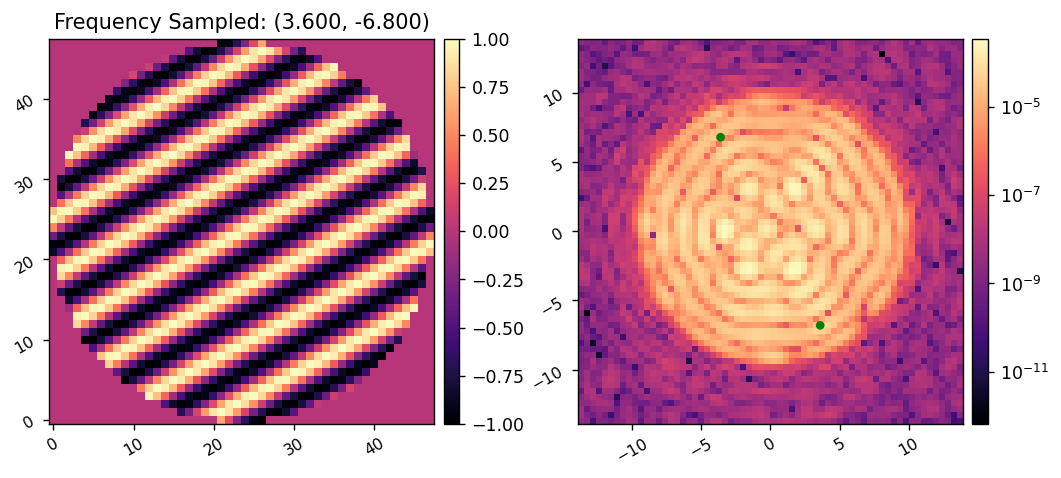

In [6]:
for i in range(fourier_modes.shape[0]//2):
    try:
        wfsc.imshow2(fourier_modes[i].reshape(Nact,Nact), ref_im, 
                       'Frequency Sampled: ({:.3f}, {:.3f})'.format(fs[i][0], fs[i][1]),
                       lognorm2=True,
                       pxscl2=c.psf_pixelscale_lamD, 
                       patches2=[Circle(fs[i], 0.25, fill=True, color='g'),
                                 Circle(-fs[i], 0.25, fill=True, color='g')])
        clear_output(wait=True)
        time.sleep(0.25)
    except KeyboardInterrupt:
        break

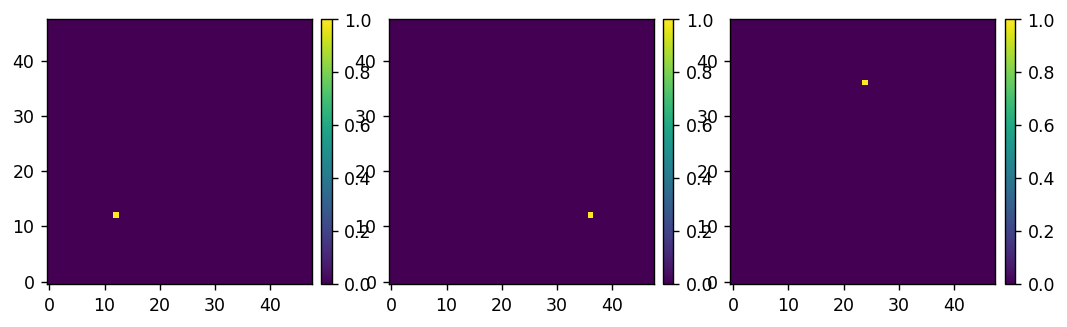

In [7]:
reload(wfsc.utils)
# probe_modes_1 = wfsc.utils.create_fourier_probes(fourier_modes, plot=True)
# probe = 1/np.sqrt(2) * np.sum((fourier_modes[:nf] + fourier_modes[nf:]), axis=0).reshape(Nact,Nact)
# probe /= probe.max()
# wfsc.imshow1(probe)

# probe_modes = np.array([probe_modes_1[0], probe, probe_modes_1[1]])
# wfsc.imshow3(probe_modes[0], probe_modes[1], probe_modes[2])

# probe_modes = wfsc.utils.create_probe_poke_modes(Nact, 
#                                                  poke_indices=[(Nact//5, Nact//2), (Nact//5+1, Nact//2)], 
#                                                  plot=True)

probe_modes = wfsc.utils.create_probe_poke_modes(Nact, 
                                                 poke_indices=[(Nact//4, Nact//4), 
                                                               (3*Nact//4, Nact//4), 
                                                               (Nact//2, 3*Nact//4)], 
                                                 plot=True)


# probe_modes = probe_modes_1 + probe_modes_2

# wfsc.imshow2(probe_modes[0], probe_modes[1])

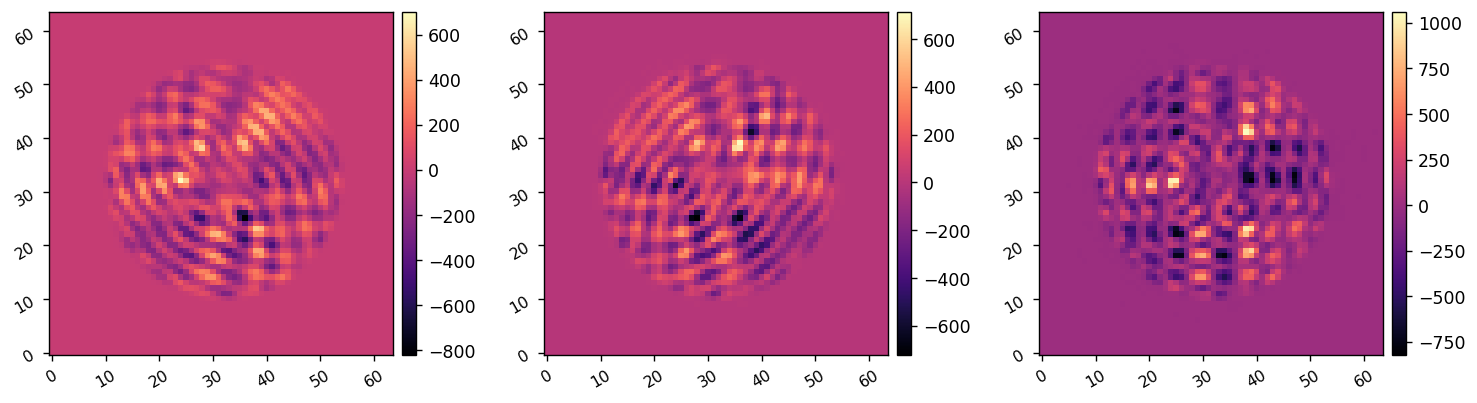

In [11]:
reload(wfsc.iefc)

probe_amp = 5e-8
calib_amp = 5e-9

# c.texp = 1

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

differential_images, single_images = wfsc.iefc_2dm.take_measurement(c, 
                                                                   probe_modes, probe_amp, 
                                                                   return_all=True)
ims = differential_images.reshape(3, c.npsf, c.npsf)
wfsc.imshow3(ims[0], ims[1], ims[0]-ims[1], wspace=0.35)

In [12]:
reload(wfsc.iefc_2dm)
response_matrix, response_cube = wfsc.iefc_2dm.calibrate(c, 
                                                         control_mask.ravel(),
                                                         probe_amp, probe_modes, 
                                                         calib_amp, fourier_modes, 
                                                         return_all=True)

Calibrating I-EFC...
	Calibrated mode 1 / 384 in 7.504s
	Calibrated mode 2 / 384 in 14.988s
	Calibrated mode 3 / 384 in 22.463s
	Calibrated mode 4 / 384 in 30.167s
	Calibrated mode 5 / 384 in 37.673s
	Calibrated mode 6 / 384 in 45.213s
	Calibrated mode 7 / 384 in 52.746s
	Calibrated mode 8 / 384 in 60.269s
	Calibrated mode 9 / 384 in 67.815s
	Calibrated mode 10 / 384 in 75.470s
	Calibrated mode 11 / 384 in 82.948s
	Calibrated mode 12 / 384 in 90.446s
	Calibrated mode 13 / 384 in 97.931s
	Calibrated mode 14 / 384 in 105.429s
	Calibrated mode 15 / 384 in 112.926s
	Calibrated mode 16 / 384 in 120.572s
	Calibrated mode 17 / 384 in 128.090s
	Calibrated mode 18 / 384 in 135.658s
	Calibrated mode 19 / 384 in 143.250s
	Calibrated mode 20 / 384 in 150.847s
	Calibrated mode 21 / 384 in 158.467s
	Calibrated mode 22 / 384 in 166.212s
	Calibrated mode 23 / 384 in 173.807s
	Calibrated mode 24 / 384 in 181.360s
	Calibrated mode 25 / 384 in 188.871s
	Calibrated mode 26 / 384 in 196.362s
	Calibrated mo

	Calibrated mode 212 / 384 in 1599.465s
	Calibrated mode 213 / 384 in 1606.965s
	Calibrated mode 214 / 384 in 1614.611s
	Calibrated mode 215 / 384 in 1622.111s
	Calibrated mode 216 / 384 in 1629.608s
	Calibrated mode 217 / 384 in 1637.108s
	Calibrated mode 218 / 384 in 1644.609s
	Calibrated mode 219 / 384 in 1652.113s
	Calibrated mode 220 / 384 in 1659.750s
	Calibrated mode 221 / 384 in 1667.252s
	Calibrated mode 222 / 384 in 1674.765s
	Calibrated mode 223 / 384 in 1682.274s
	Calibrated mode 224 / 384 in 1689.808s
	Calibrated mode 225 / 384 in 1697.318s
	Calibrated mode 226 / 384 in 1704.995s
	Calibrated mode 227 / 384 in 1712.503s
	Calibrated mode 228 / 384 in 1720.024s
	Calibrated mode 229 / 384 in 1727.551s
	Calibrated mode 230 / 384 in 1735.057s
	Calibrated mode 231 / 384 in 1742.555s
	Calibrated mode 232 / 384 in 1750.218s
	Calibrated mode 233 / 384 in 1757.743s
	Calibrated mode 234 / 384 in 1765.246s
	Calibrated mode 235 / 384 in 1772.762s
	Calibrated mode 236 / 384 in 1780.292s


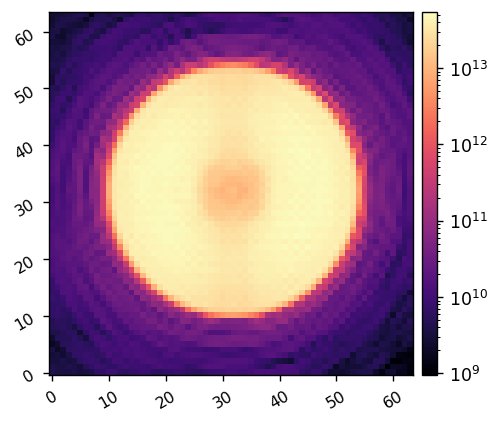

In [13]:
response_sum = xp.sum(abs(response_cube), axis=(0,1))
wfsc.imshow1(response_sum.reshape(npsf, npsf), lognorm=True)

In [14]:
import misc_funs as misc

misc.save_fits(iefc_dir/'response-data'/'hlc_iefc_2dm_response_matrix_20230607.fits', 
               wfsc.utils.ensure_np_array(response_matrix))
misc.save_fits(iefc_dir/'response-data'/'hlc_iefc_2dm_response_cube_20230607.fits', 
               wfsc.utils.ensure_np_array(response_cube))

Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/hlc_iefc_2dm_response_matrix_20230607.fits
Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/hlc_iefc_2dm_response_cube_20230607.fits


# Run IEFC

Running I-EFC...
	Closed-loop iteration 1 / 10


(768,)

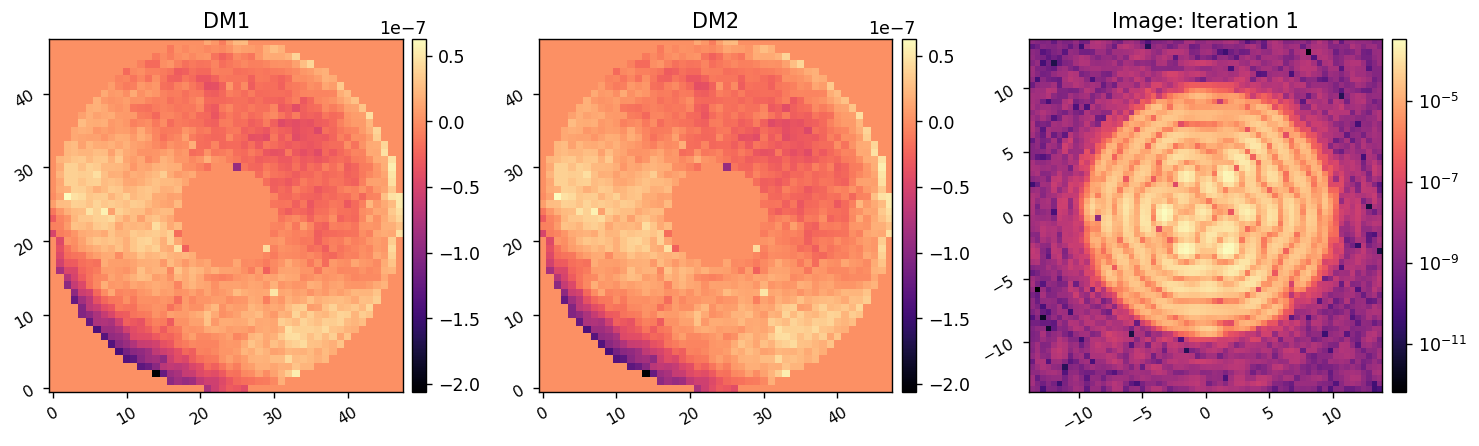

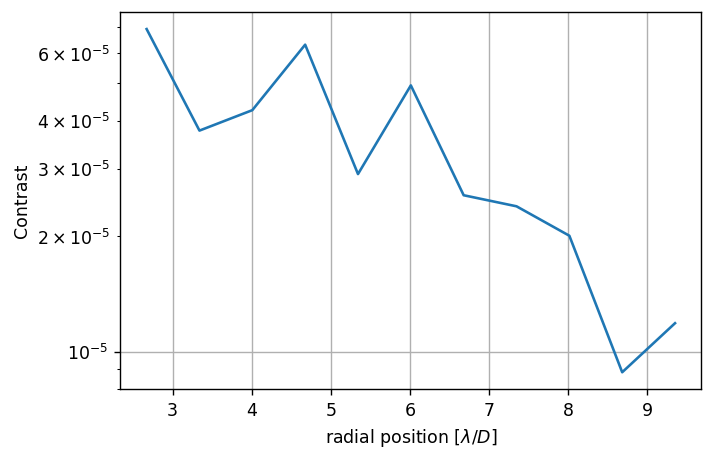

	Closed-loop iteration 2 / 10


(768,)

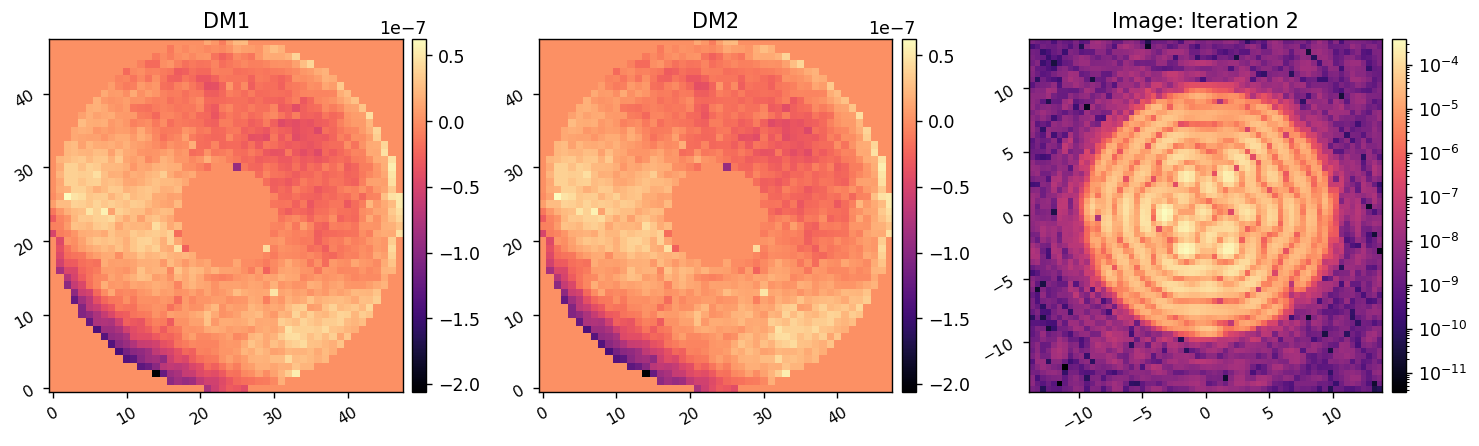

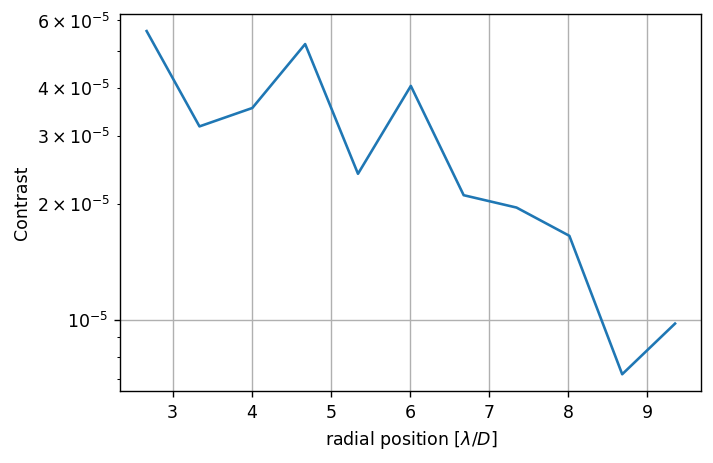

	Closed-loop iteration 3 / 10


(768,)

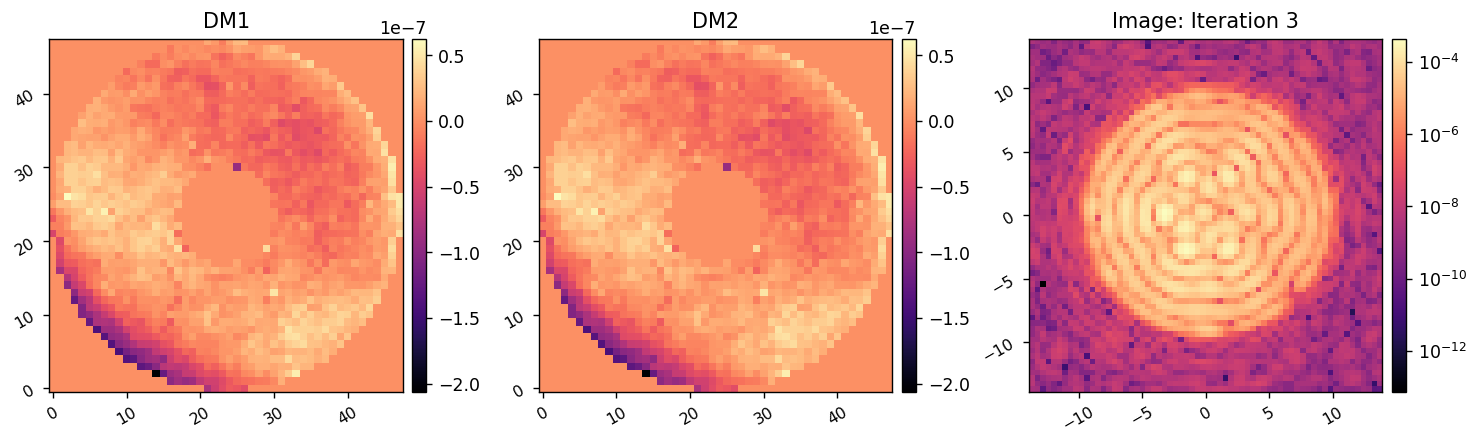

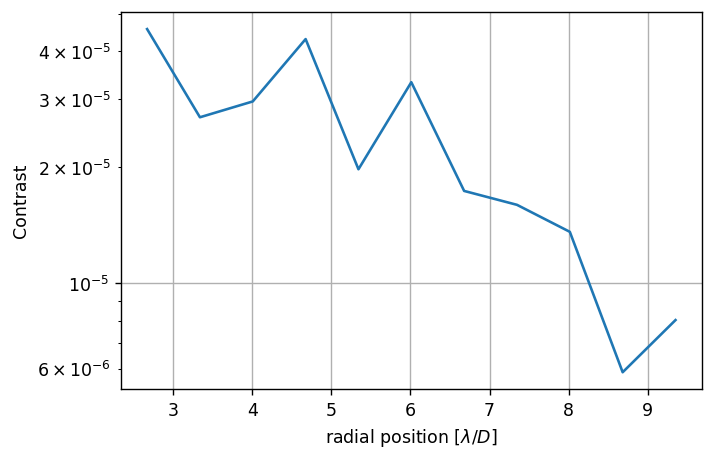

	Closed-loop iteration 4 / 10


(768,)

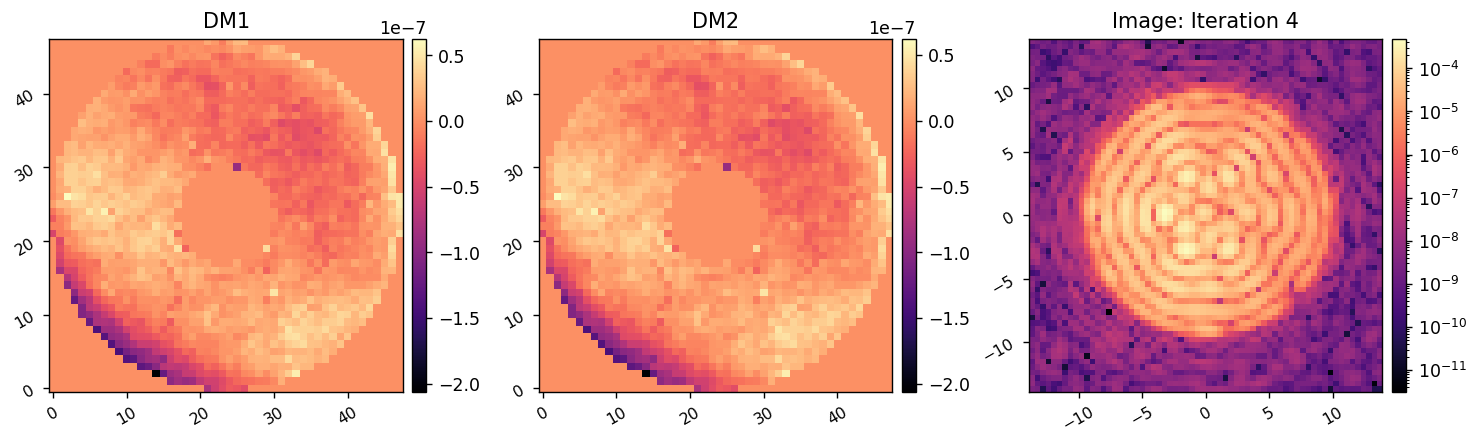

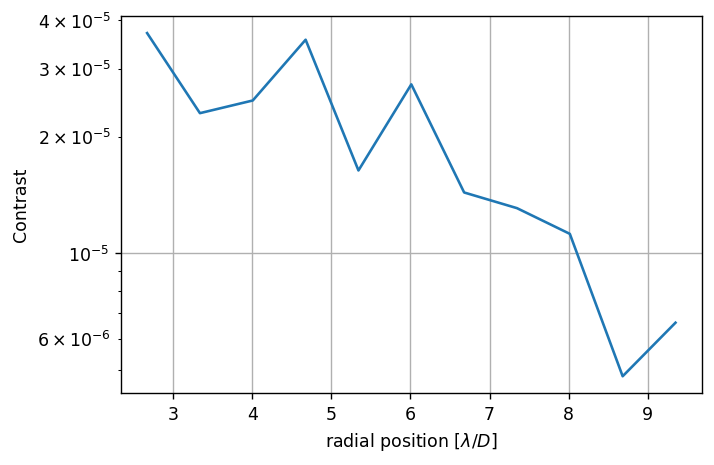

	Closed-loop iteration 5 / 10


(768,)

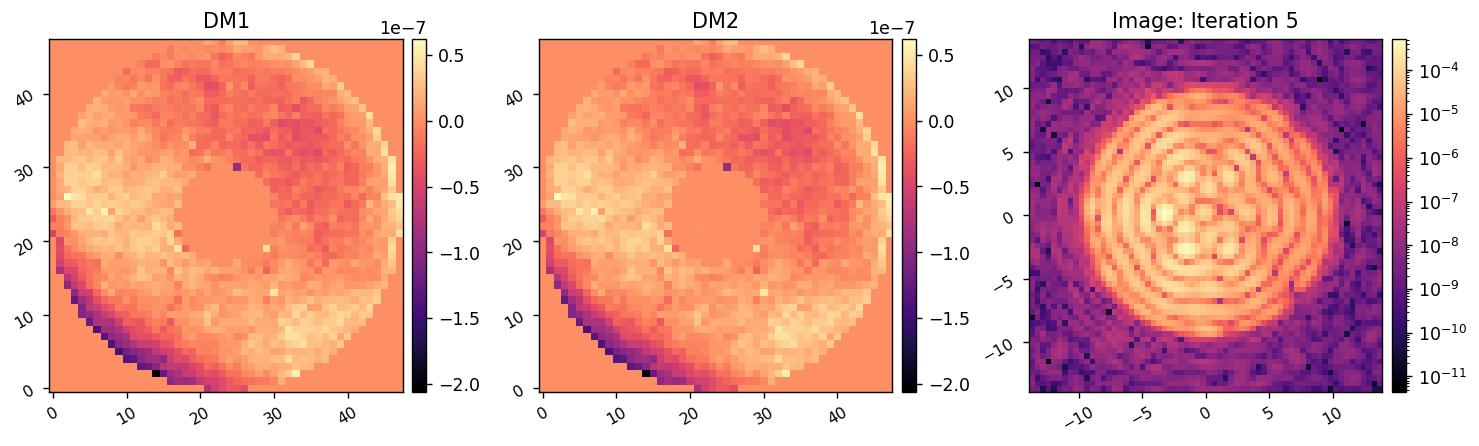

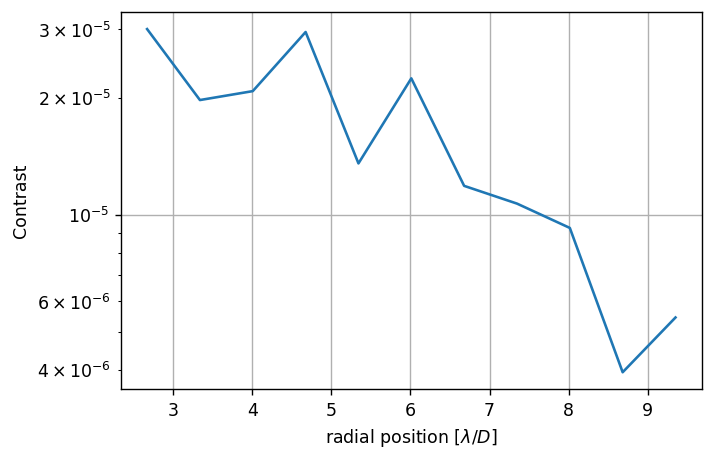

	Closed-loop iteration 6 / 10


(768,)

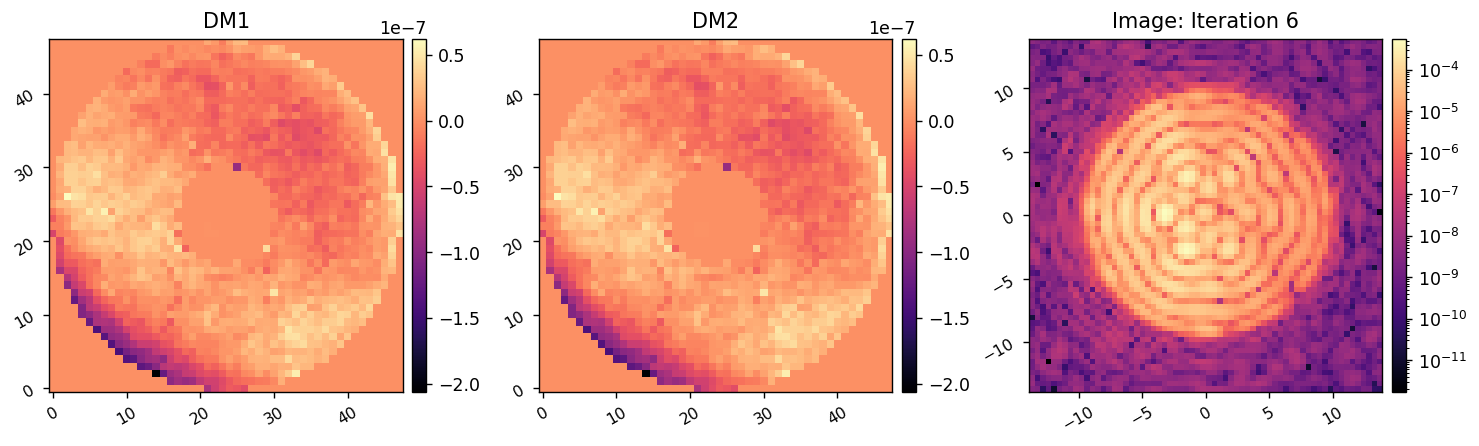

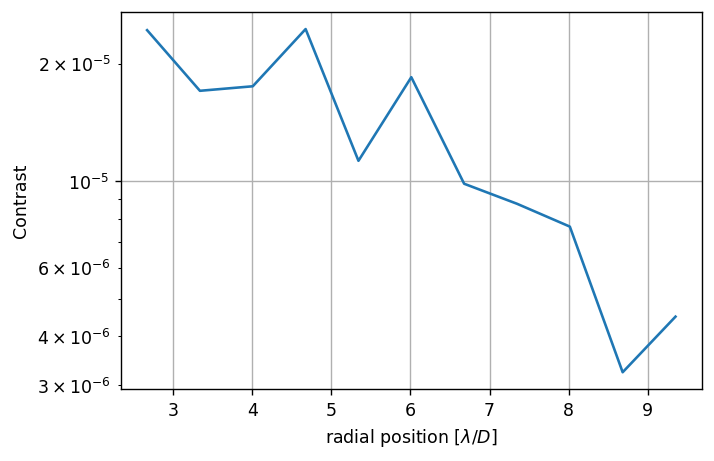

	Closed-loop iteration 7 / 10


(768,)

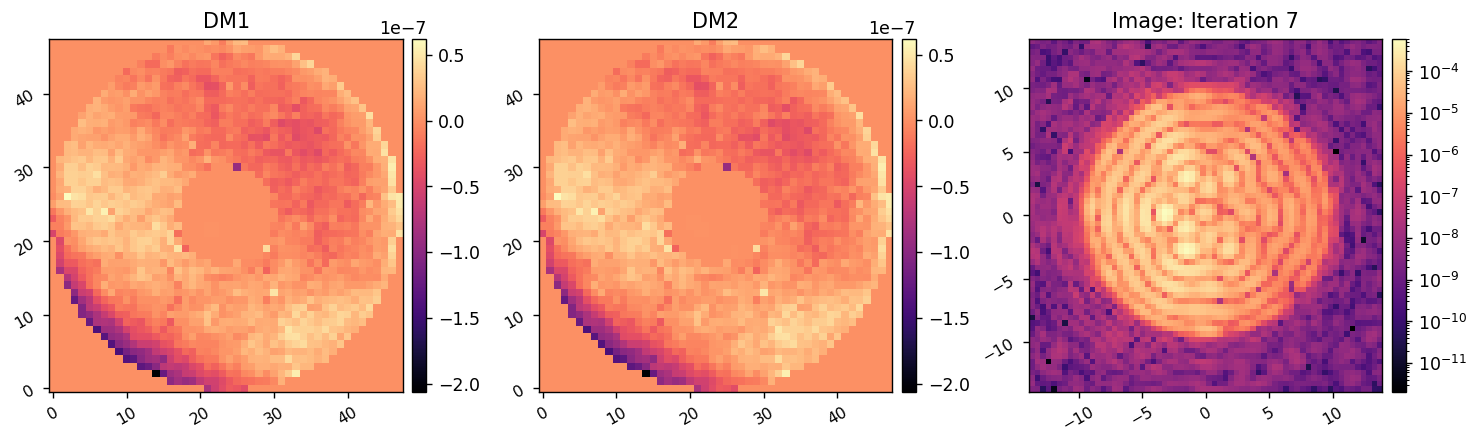

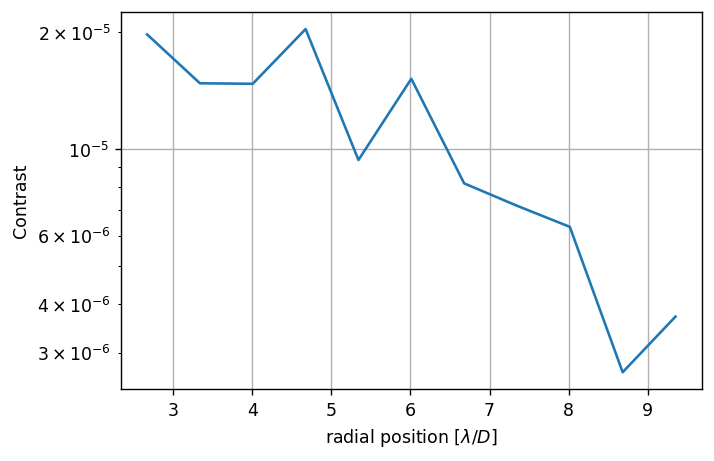

	Closed-loop iteration 8 / 10


(768,)

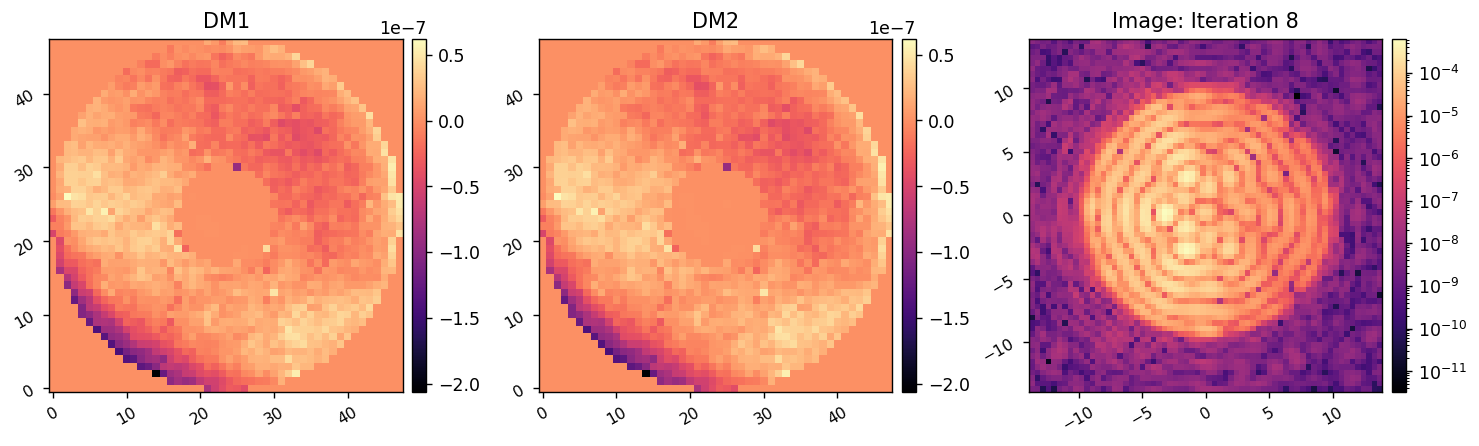

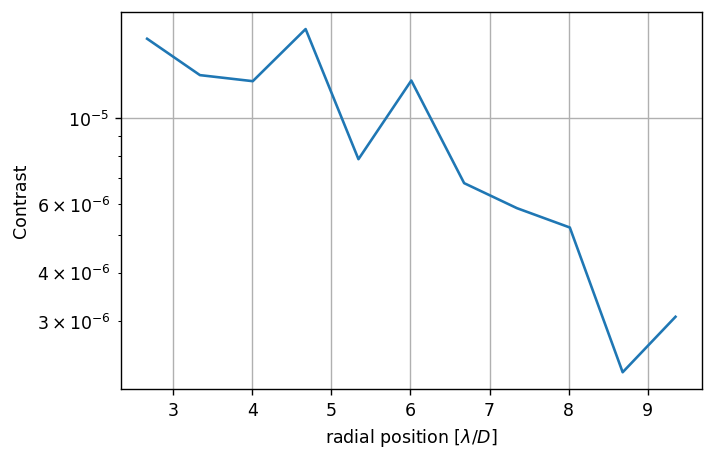

	Closed-loop iteration 9 / 10


(768,)

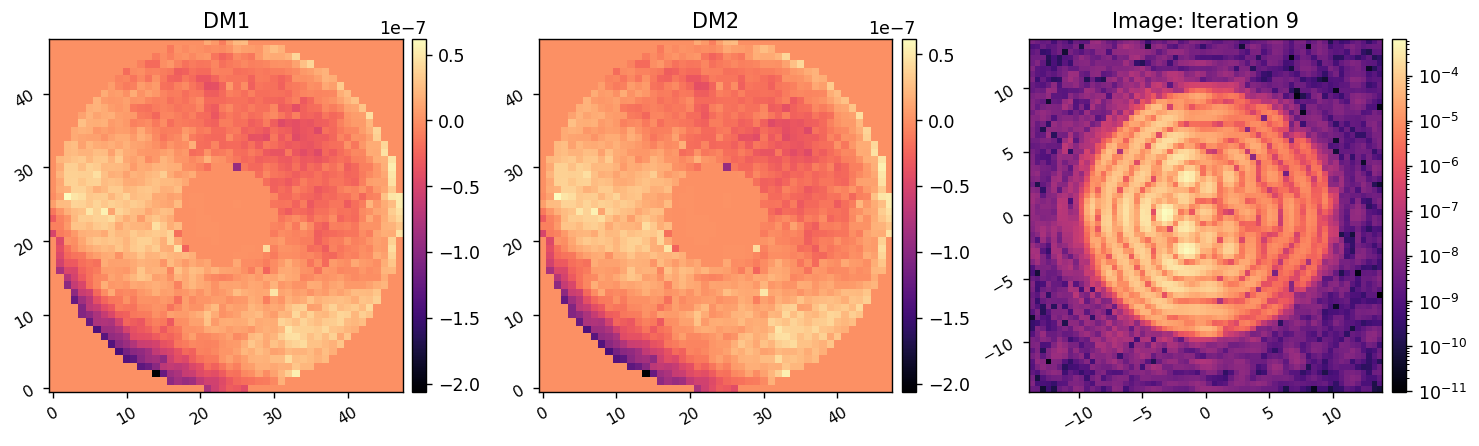

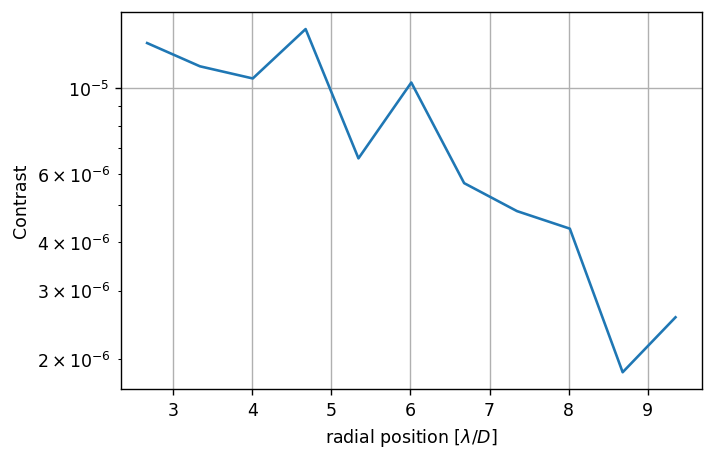

	Closed-loop iteration 10 / 10


(768,)

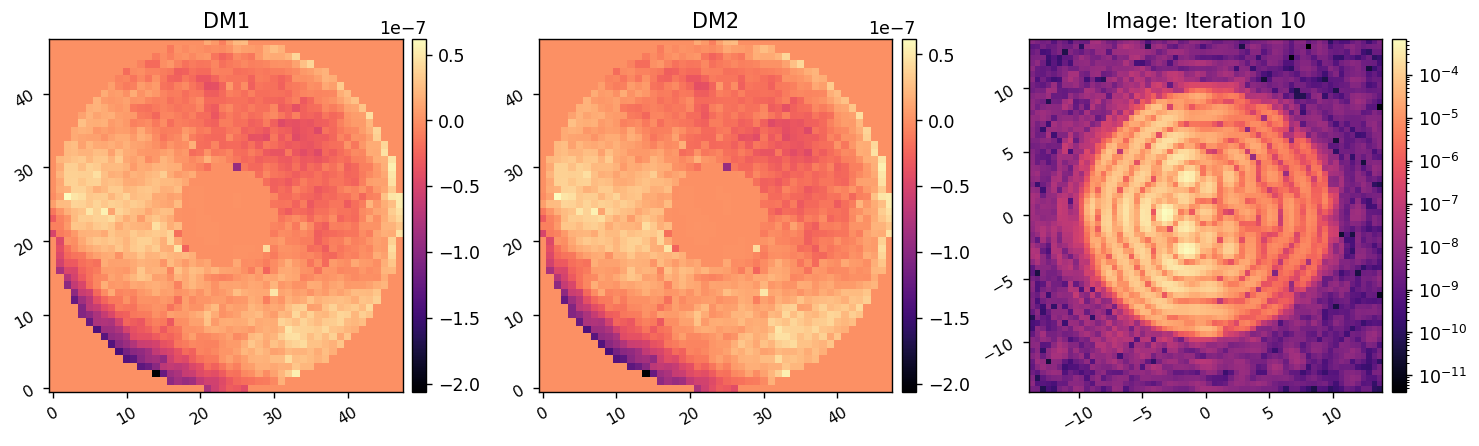

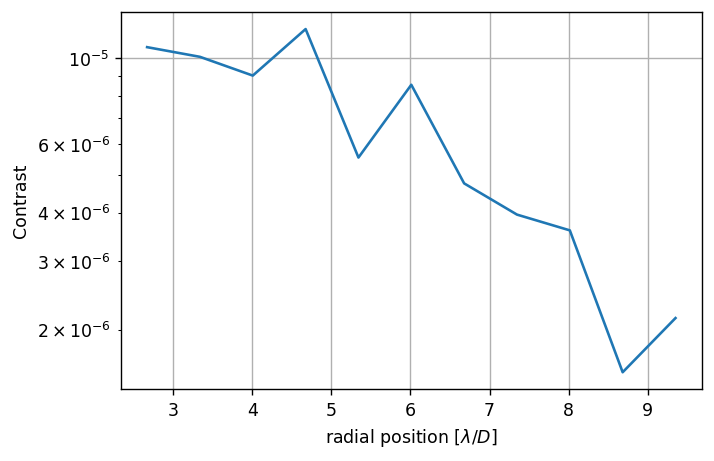

I-EFC loop completed in 31.251s.
Running I-EFC...
	Closed-loop iteration 1 / 20


(768,)

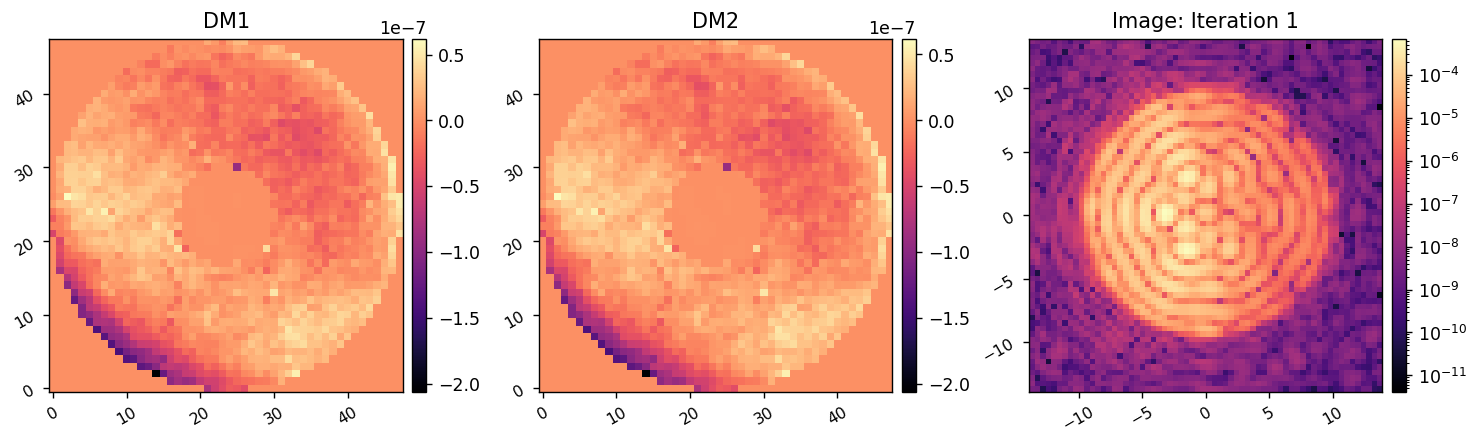

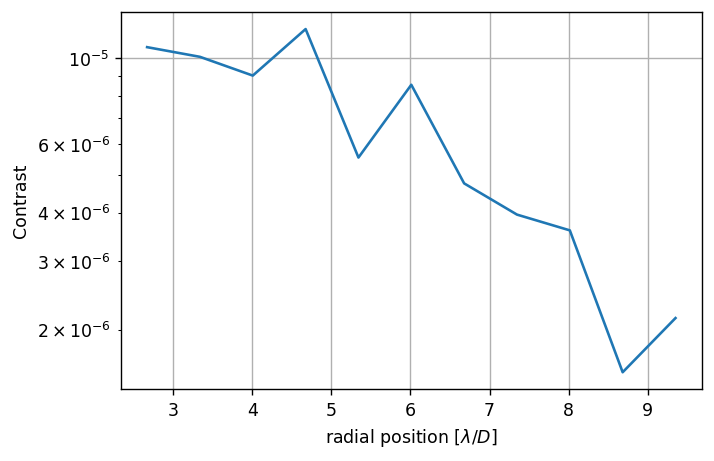

	Closed-loop iteration 2 / 20


(768,)

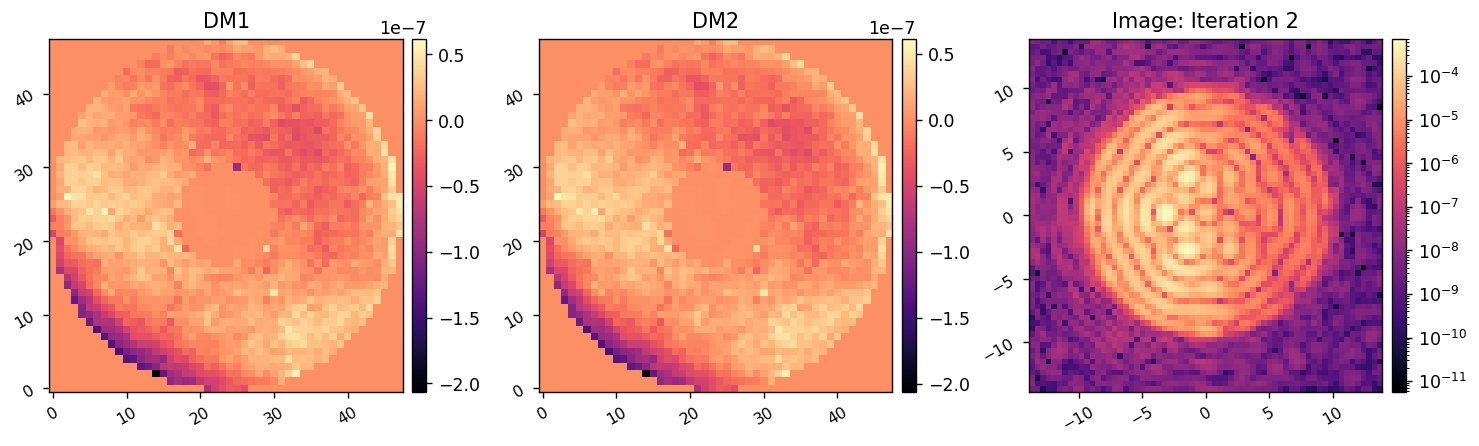

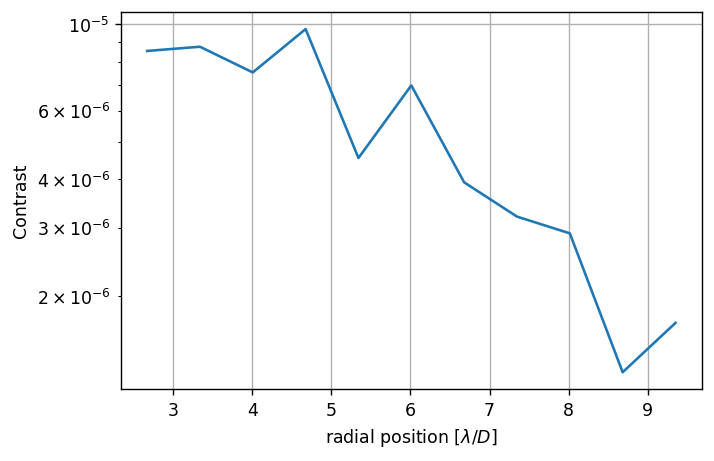

	Closed-loop iteration 3 / 20


(768,)

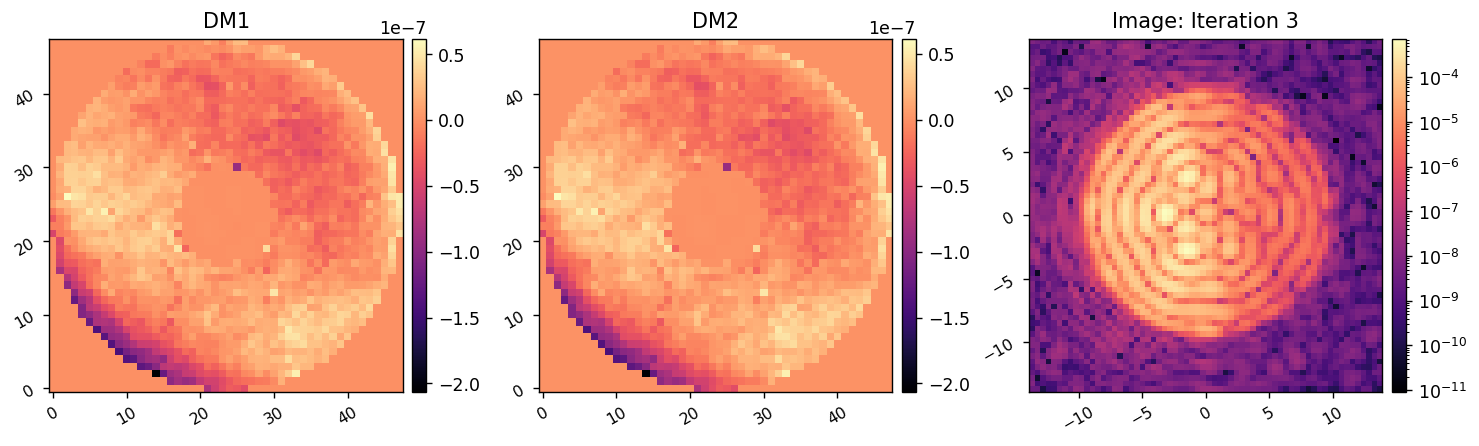

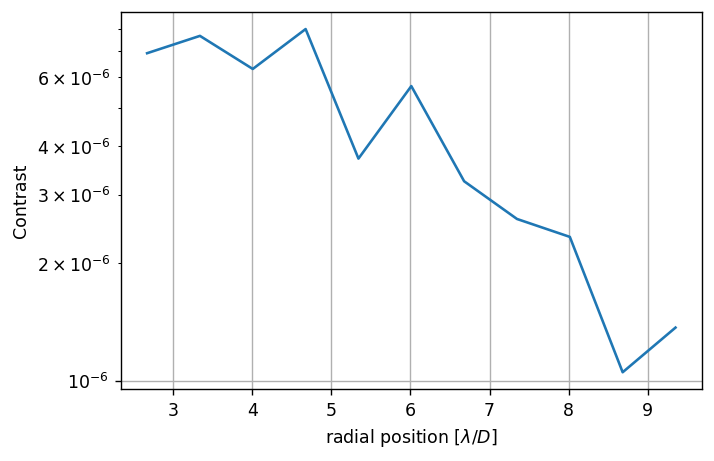

	Closed-loop iteration 4 / 20


(768,)

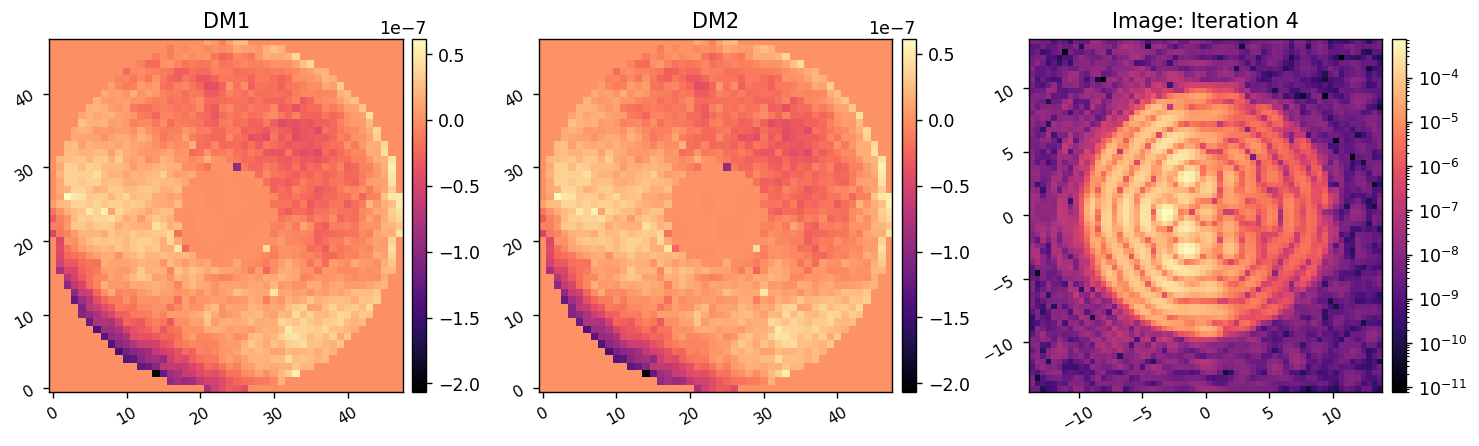

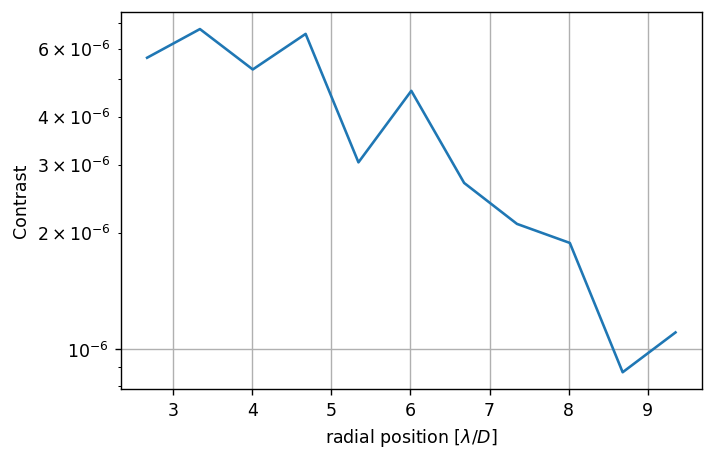

	Closed-loop iteration 5 / 20


(768,)

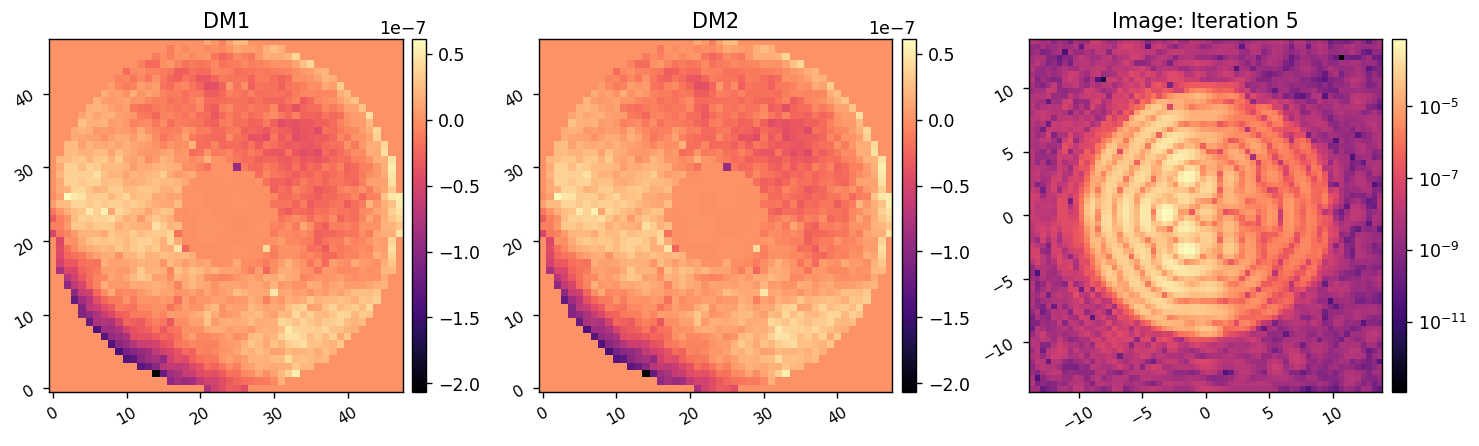

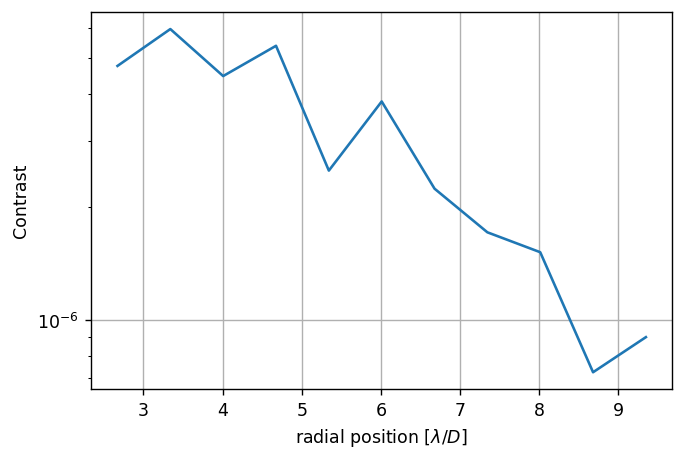

	Closed-loop iteration 6 / 20


(768,)

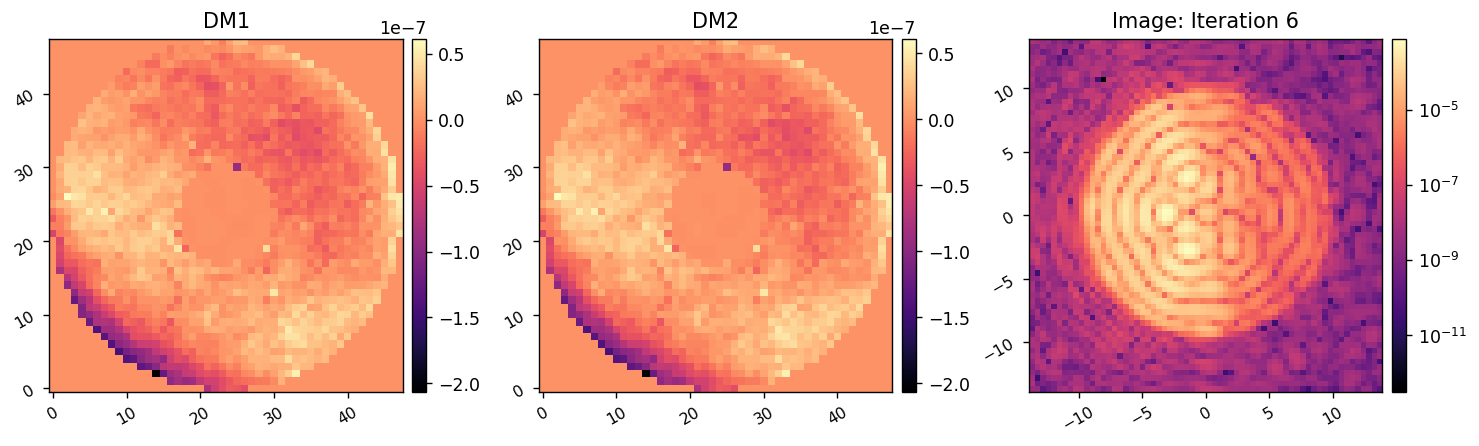

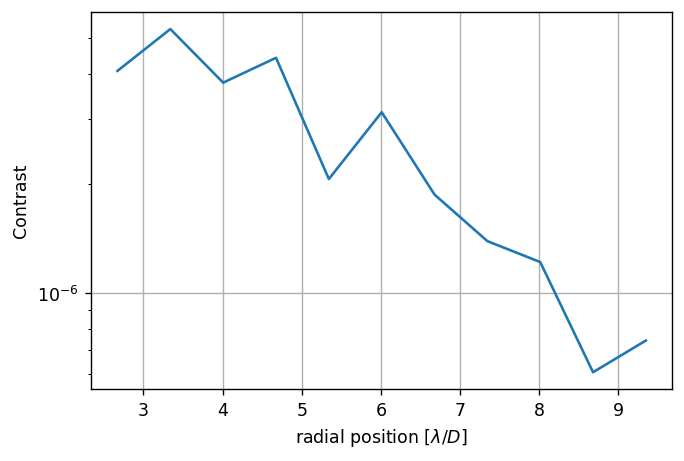

	Closed-loop iteration 7 / 20


(768,)

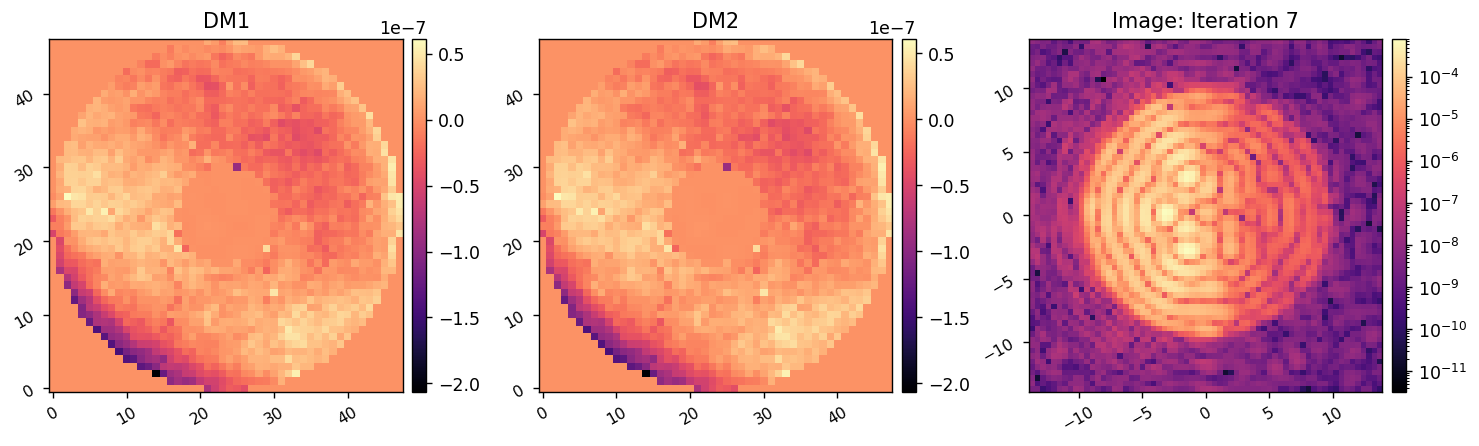

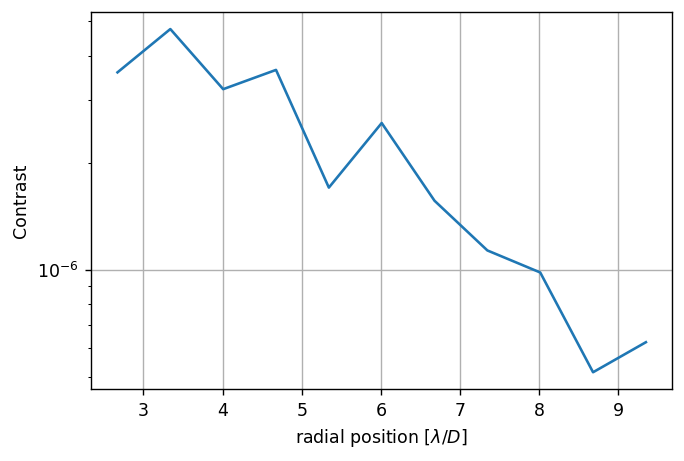

	Closed-loop iteration 8 / 20


(768,)

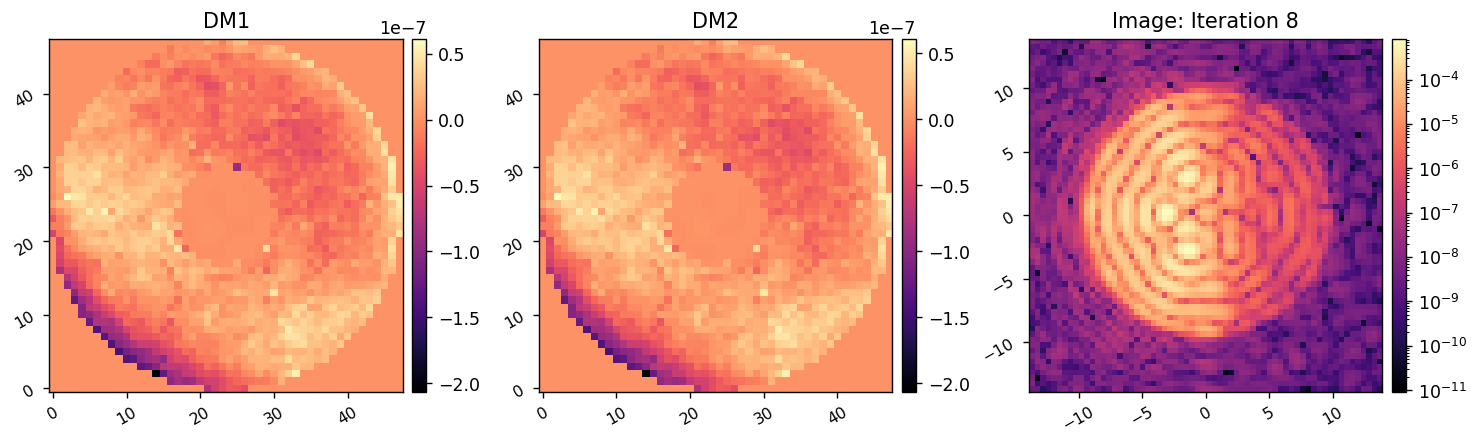

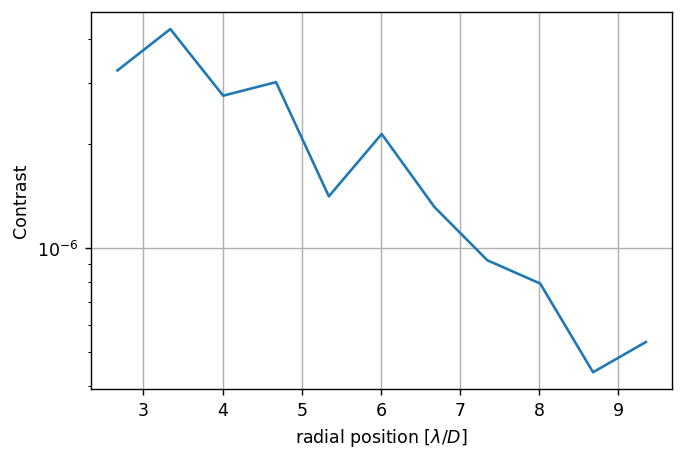

	Closed-loop iteration 9 / 20


(768,)

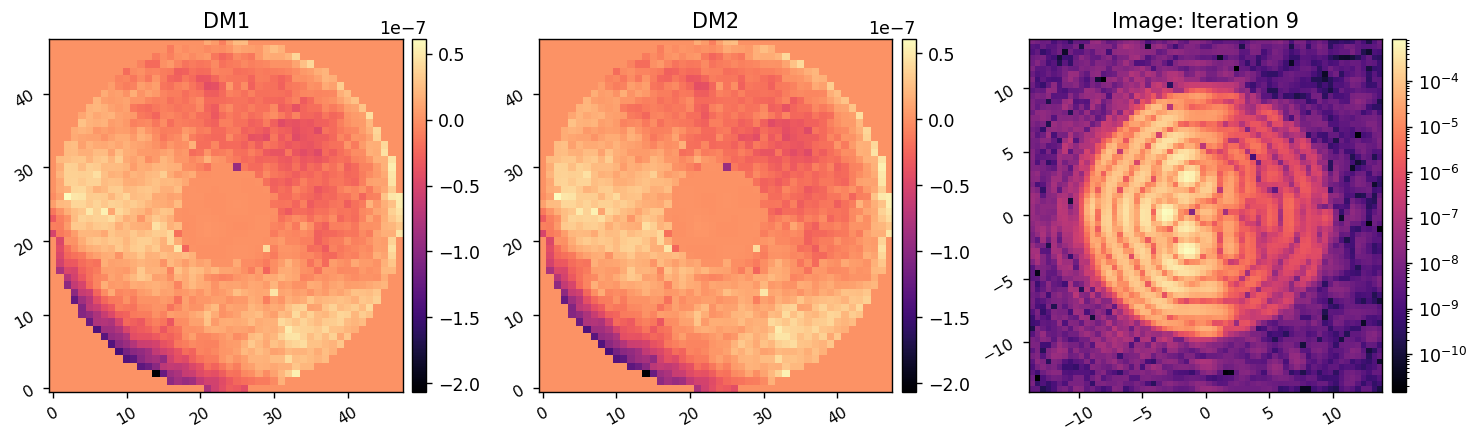

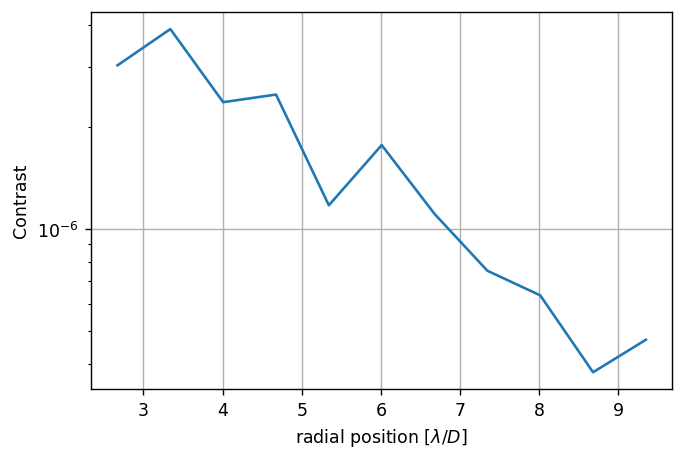

	Closed-loop iteration 10 / 20


(768,)

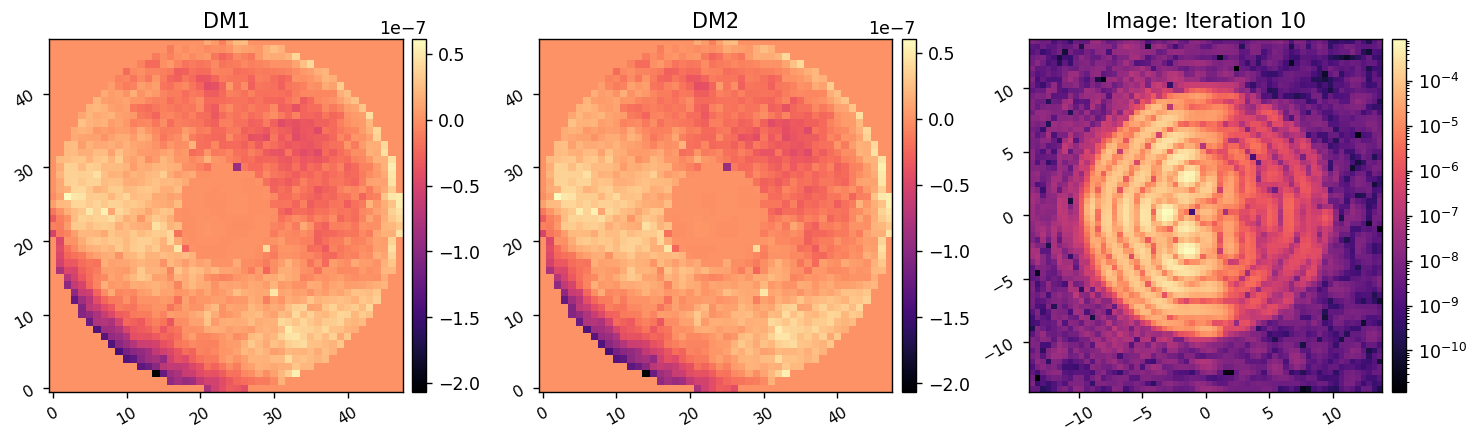

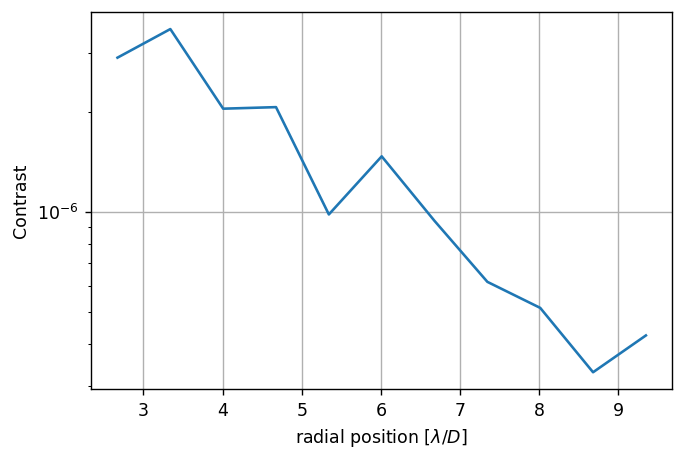

	Closed-loop iteration 11 / 20


(768,)

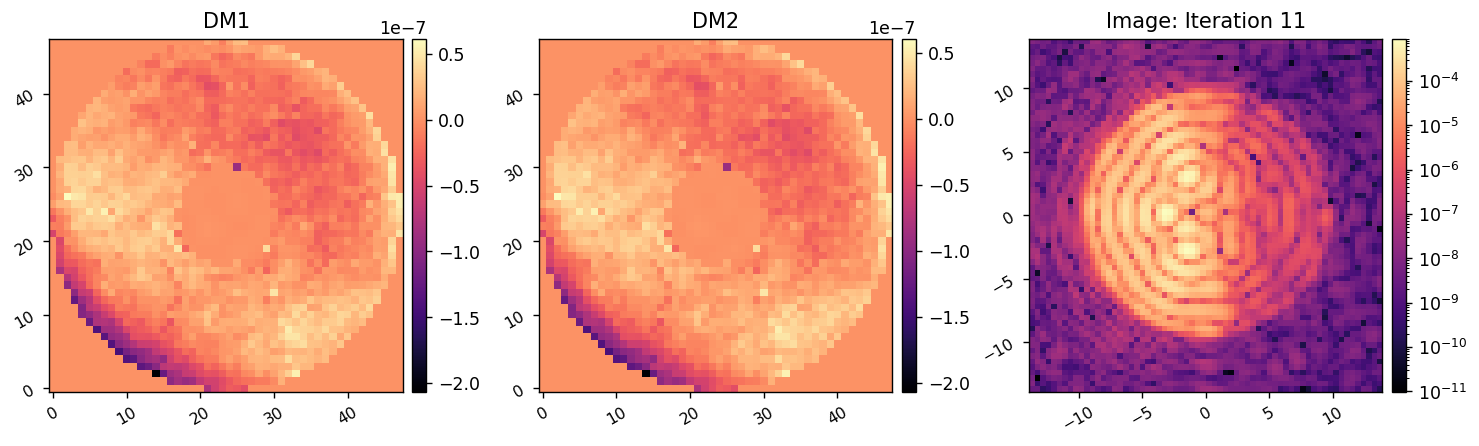

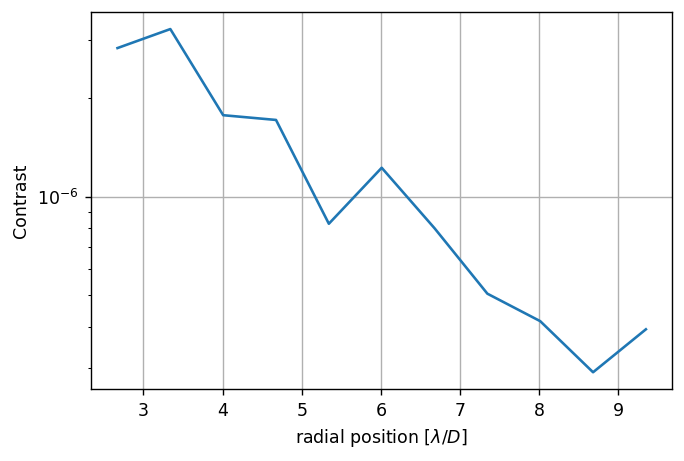

	Closed-loop iteration 12 / 20


(768,)

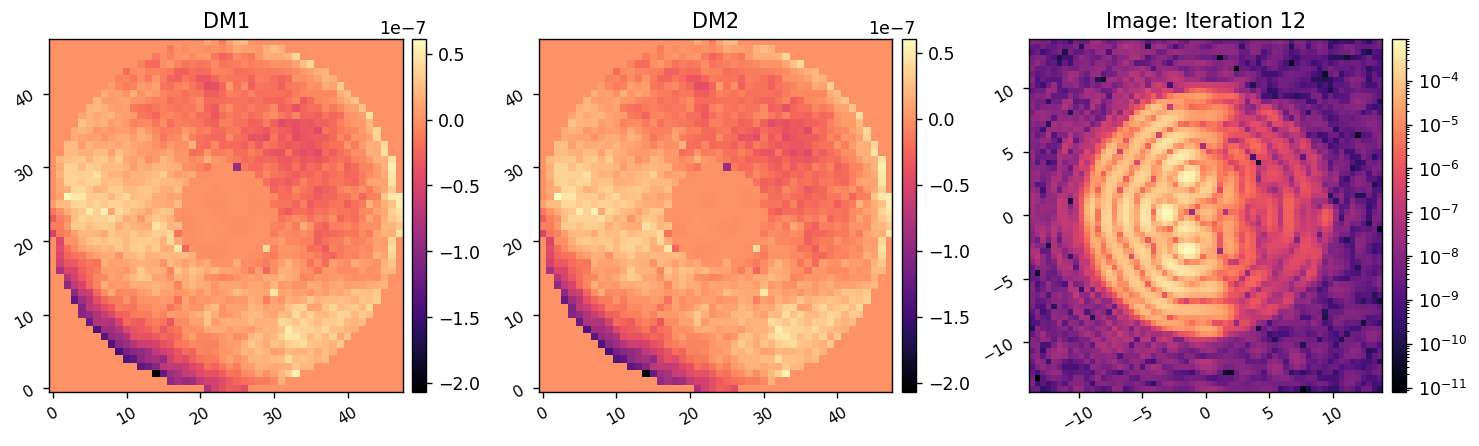

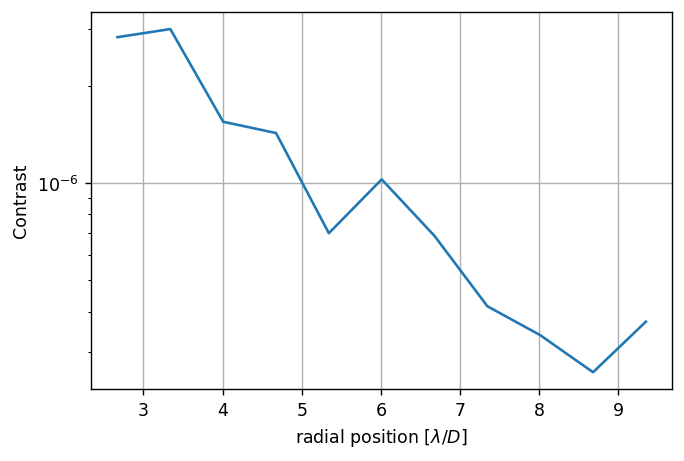

	Closed-loop iteration 13 / 20


(768,)

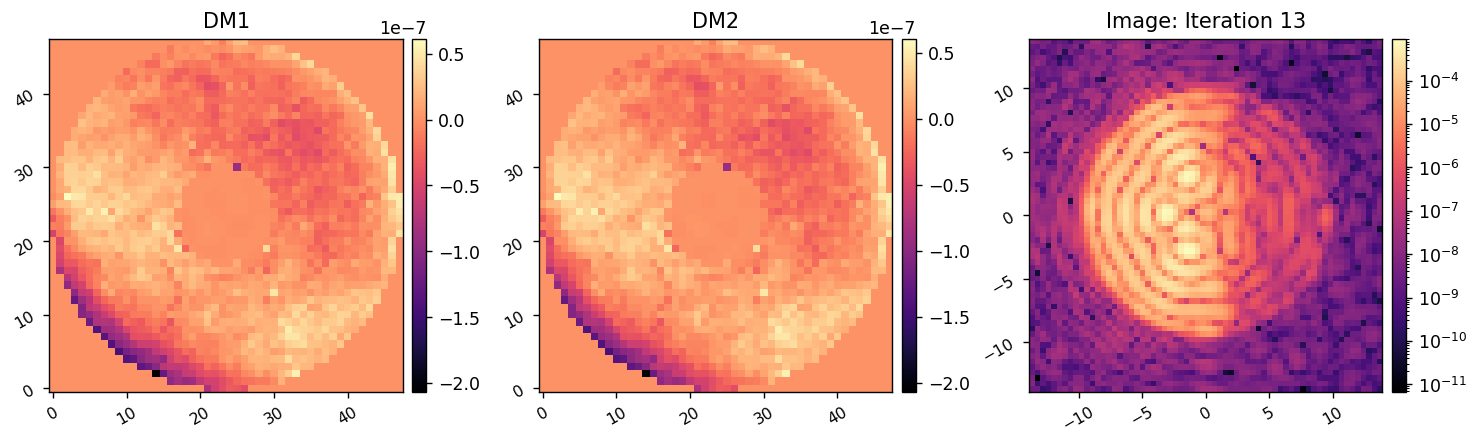

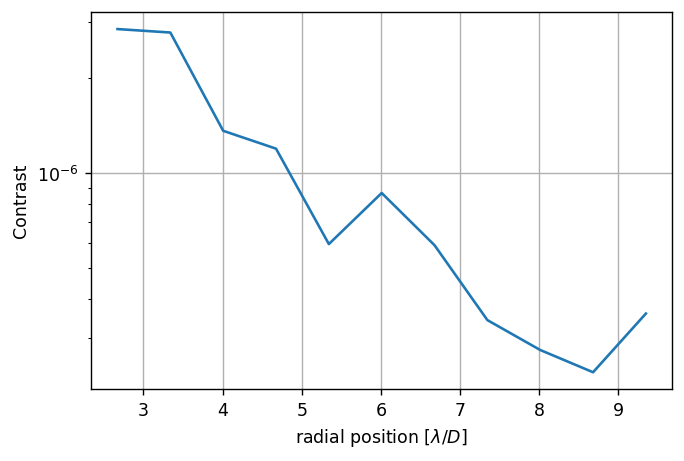

	Closed-loop iteration 14 / 20


(768,)

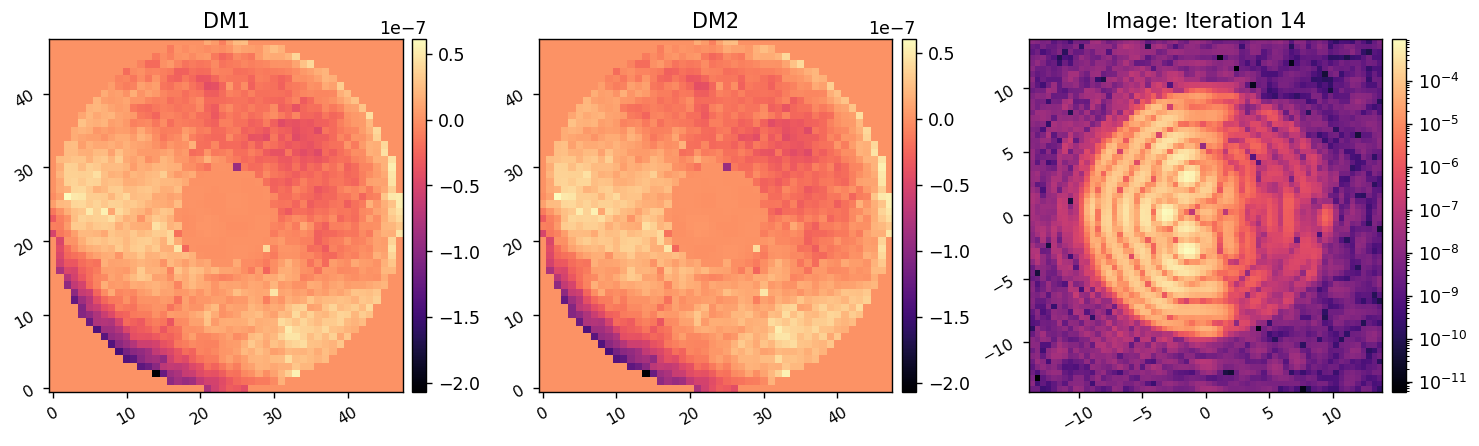

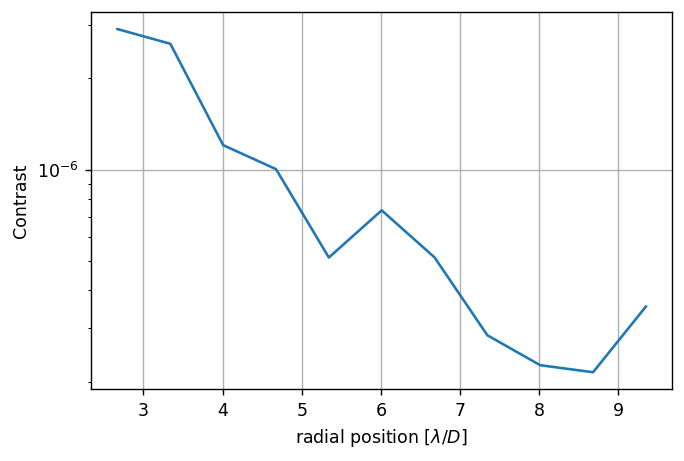

	Closed-loop iteration 15 / 20


(768,)

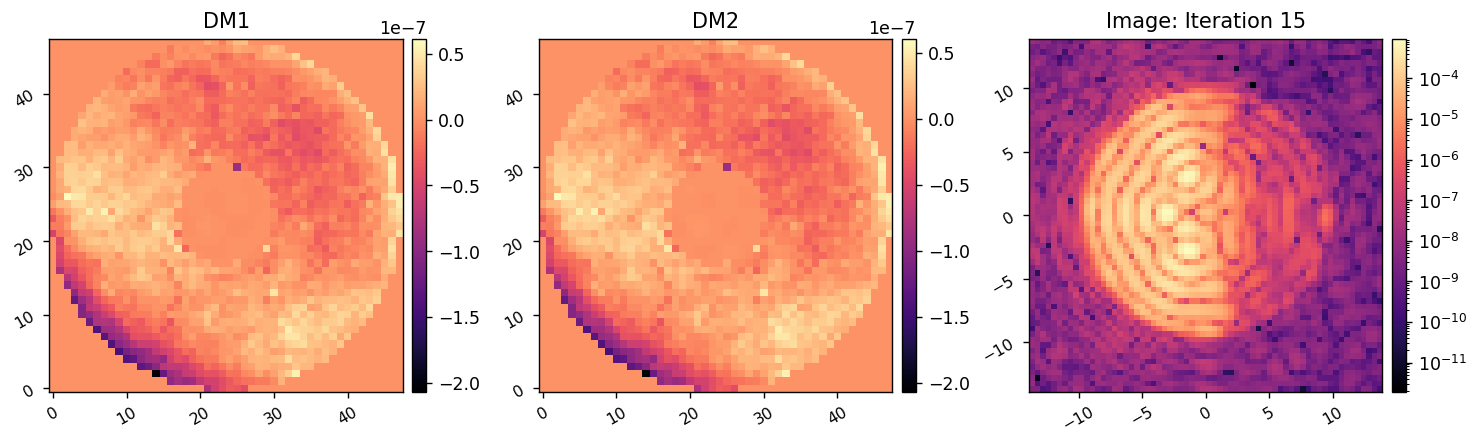

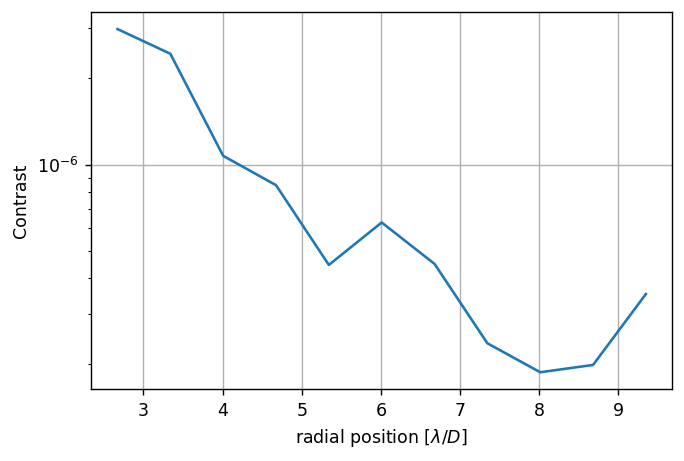

	Closed-loop iteration 16 / 20


(768,)

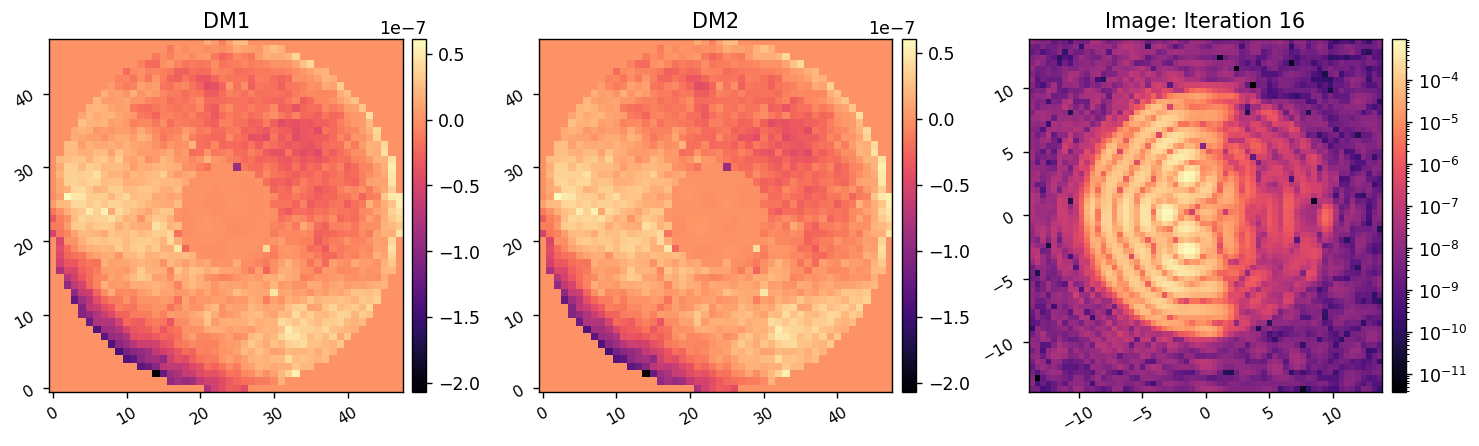

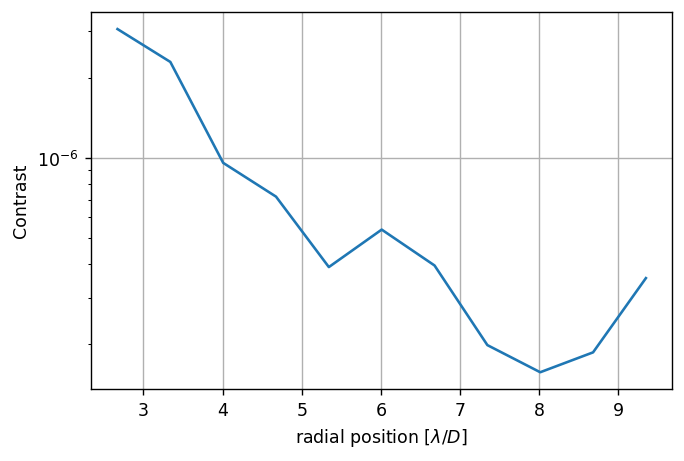

	Closed-loop iteration 17 / 20


(768,)

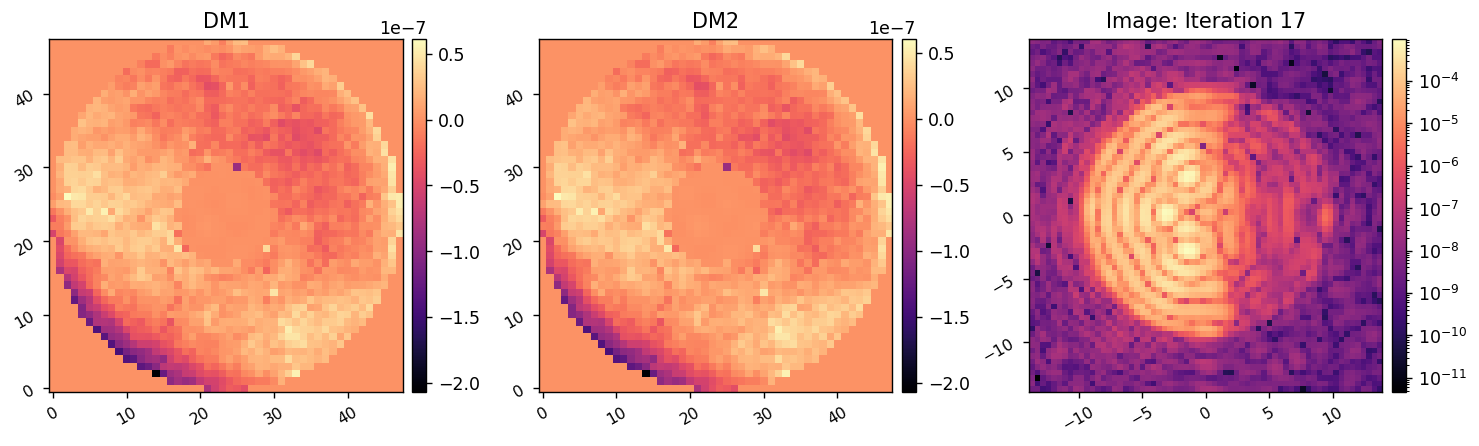

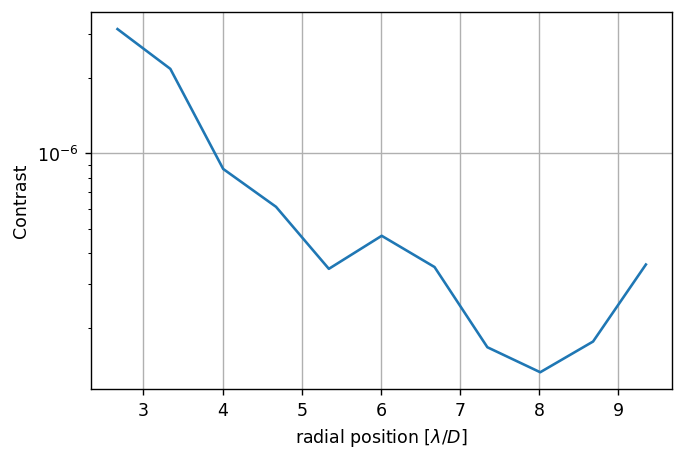

	Closed-loop iteration 18 / 20


(768,)

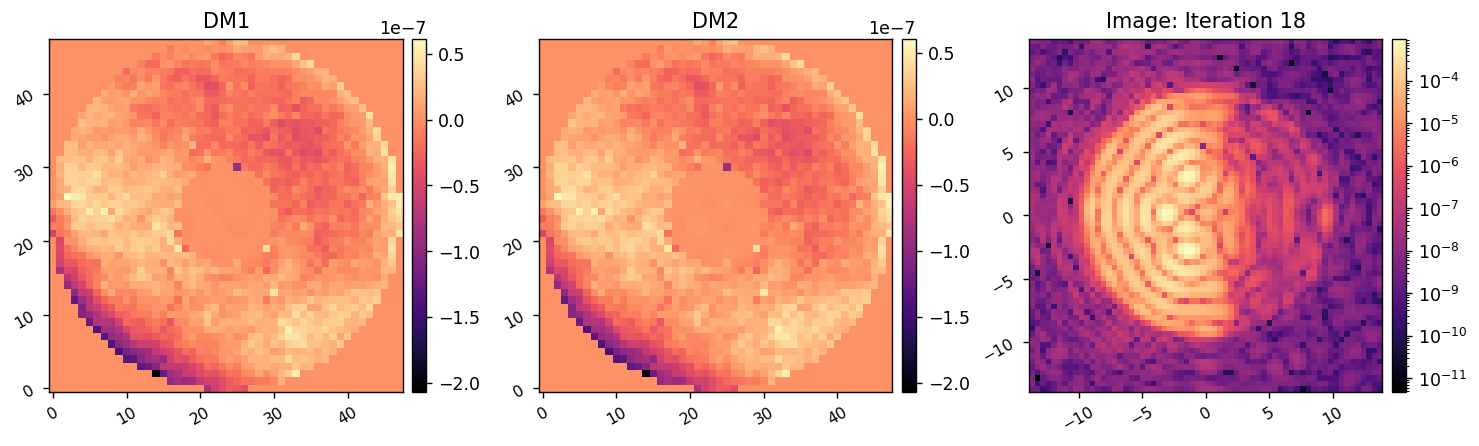

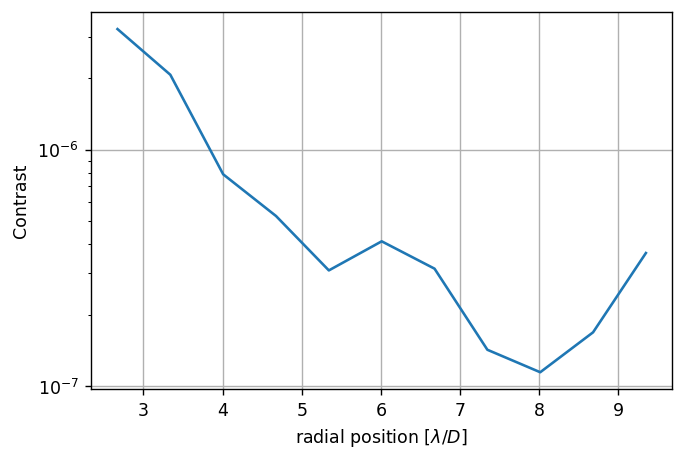

	Closed-loop iteration 19 / 20


(768,)

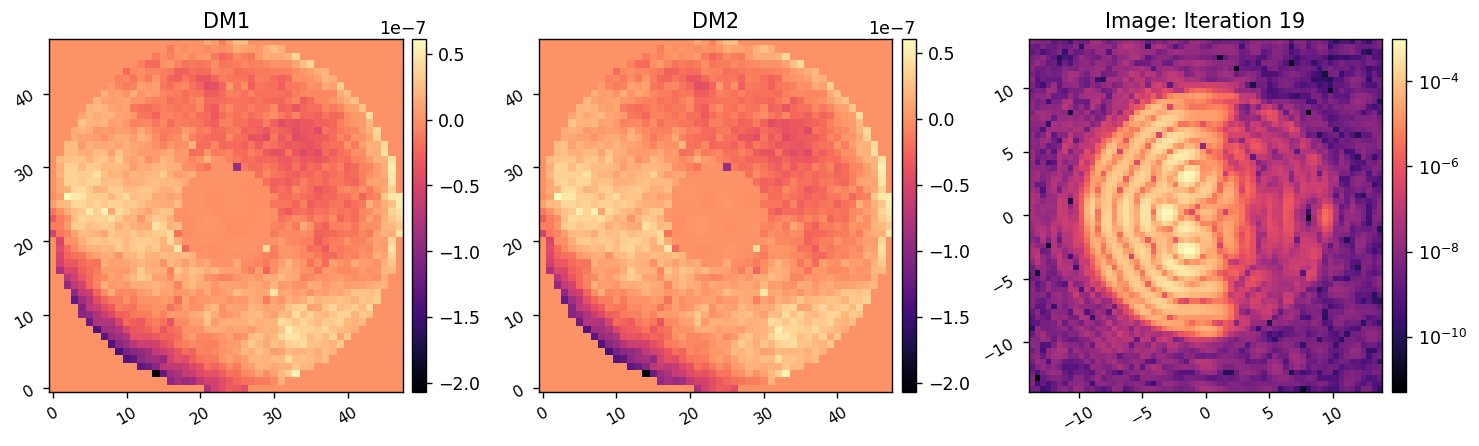

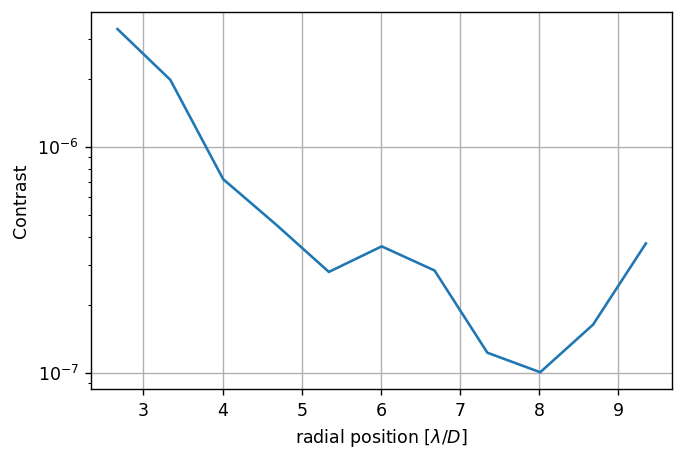

	Closed-loop iteration 20 / 20


(768,)

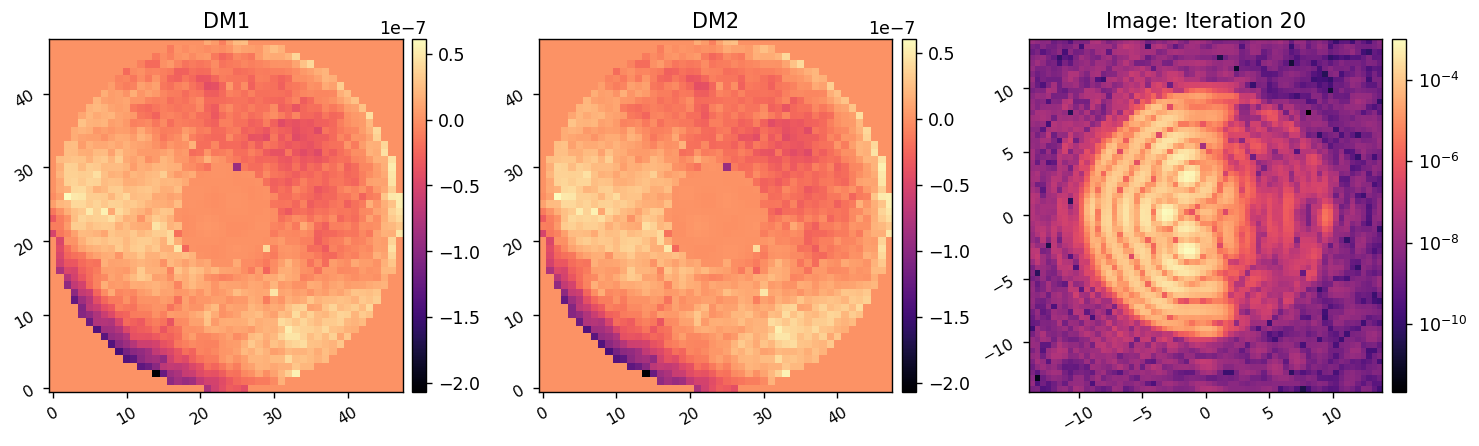

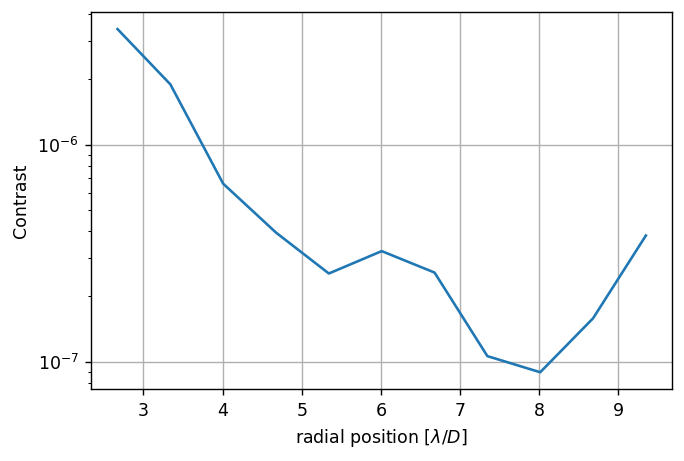

I-EFC loop completed in 61.327s.
Running I-EFC...
	Closed-loop iteration 1 / 20


(768,)

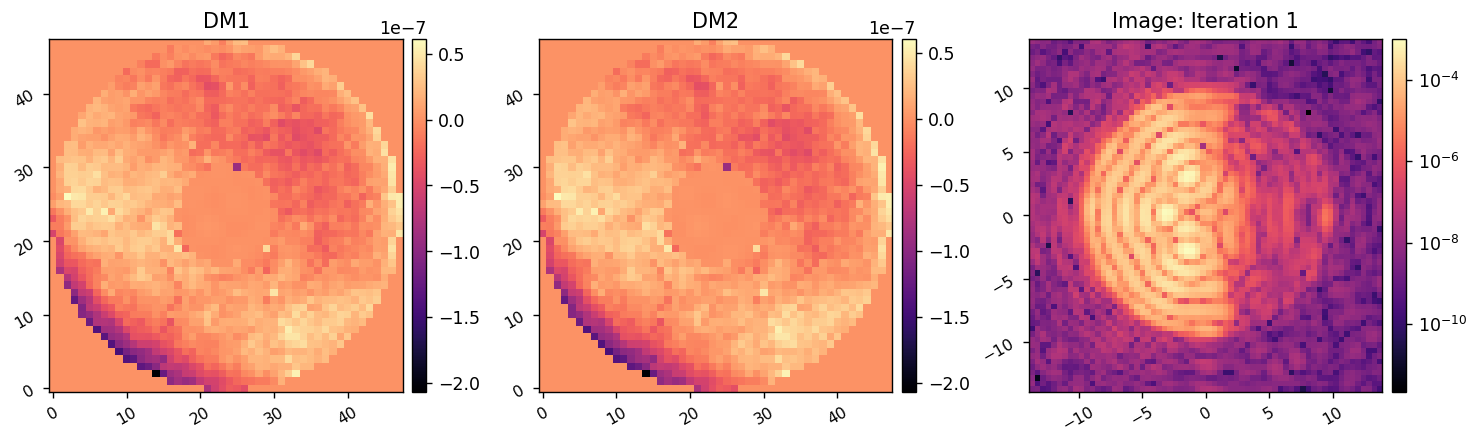

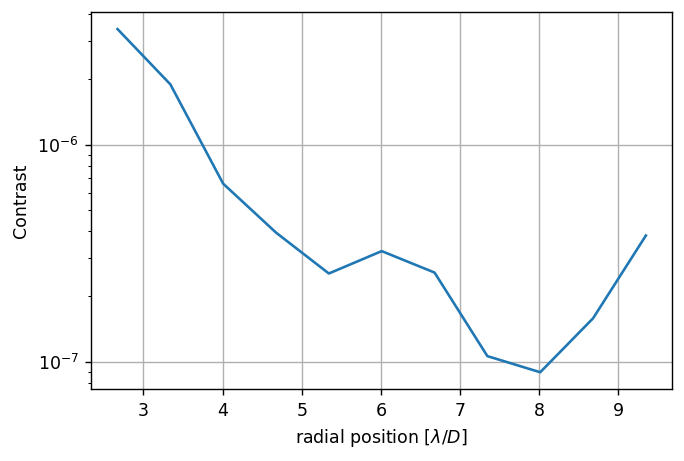

	Closed-loop iteration 2 / 20


(768,)

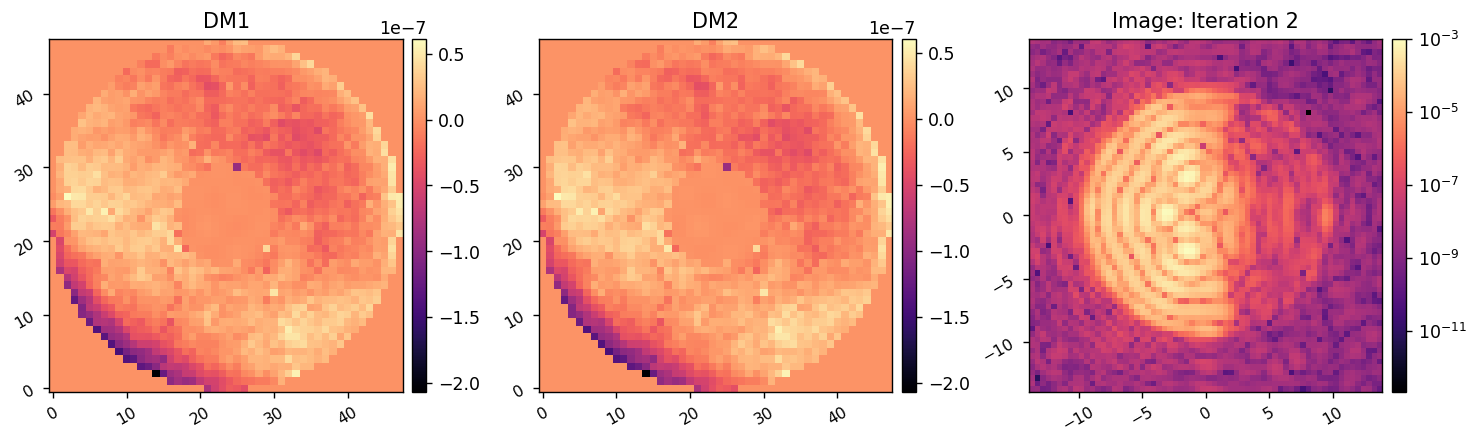

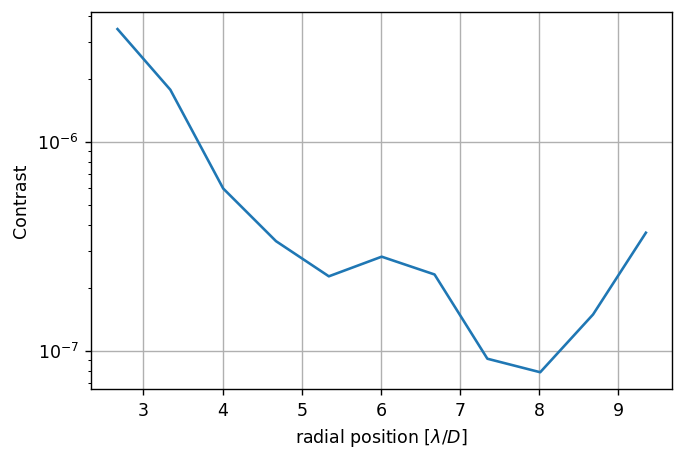

	Closed-loop iteration 3 / 20


(768,)

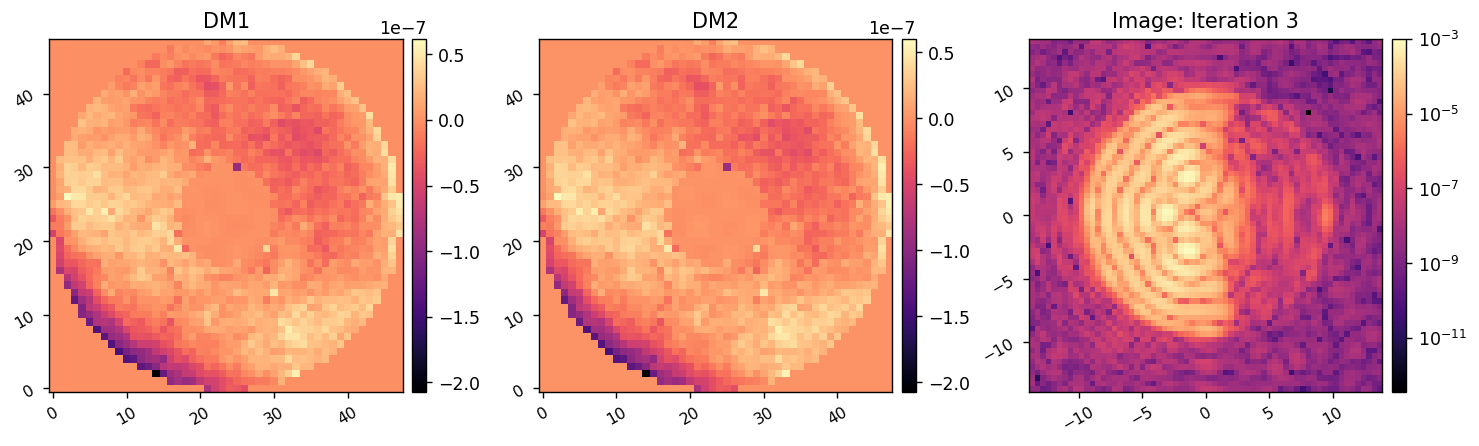

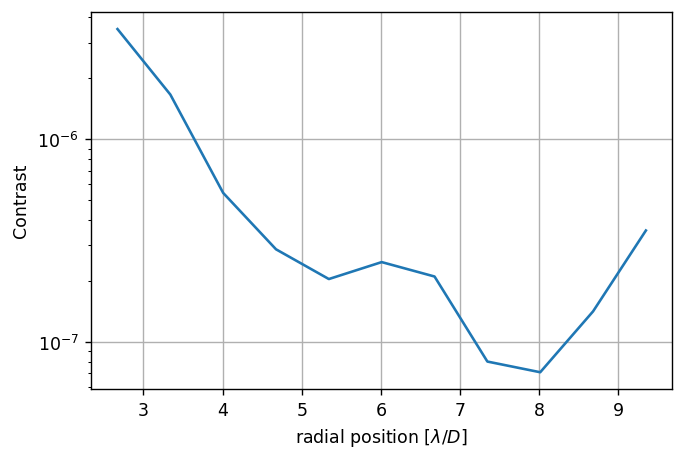

	Closed-loop iteration 4 / 20


(768,)

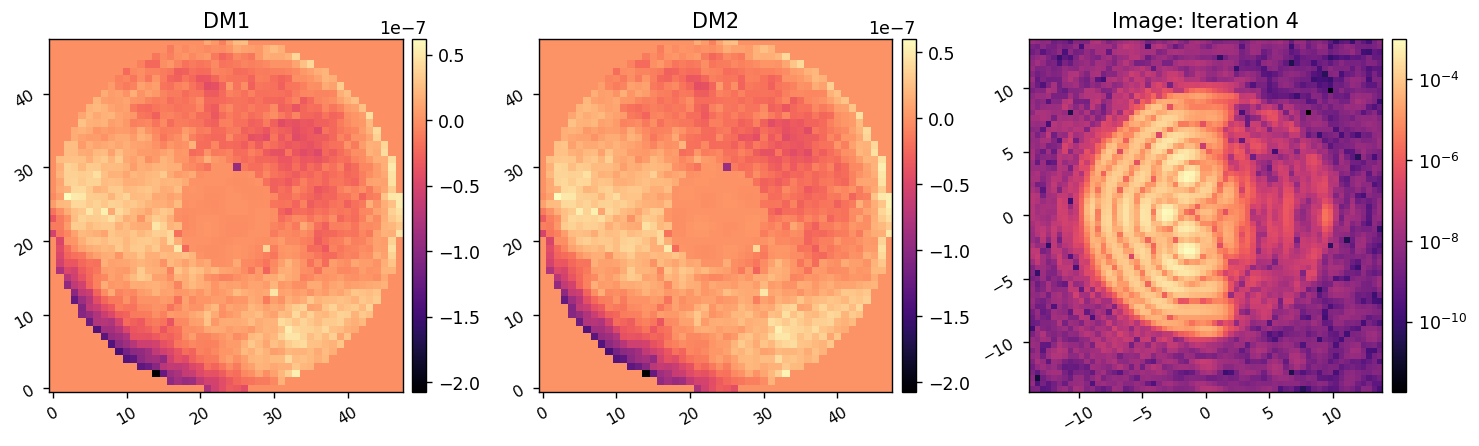

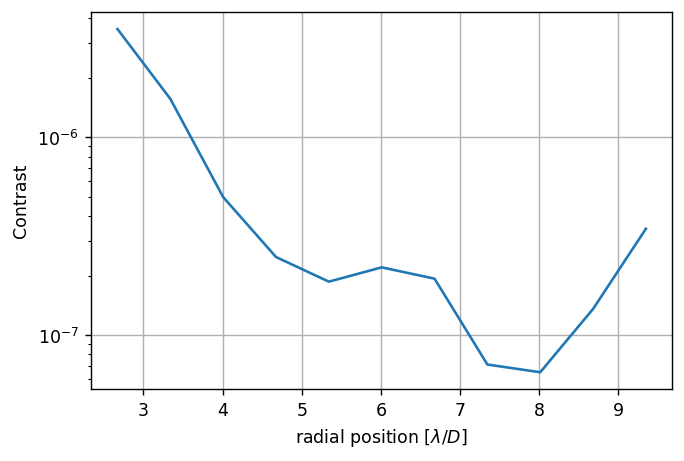

	Closed-loop iteration 5 / 20


(768,)

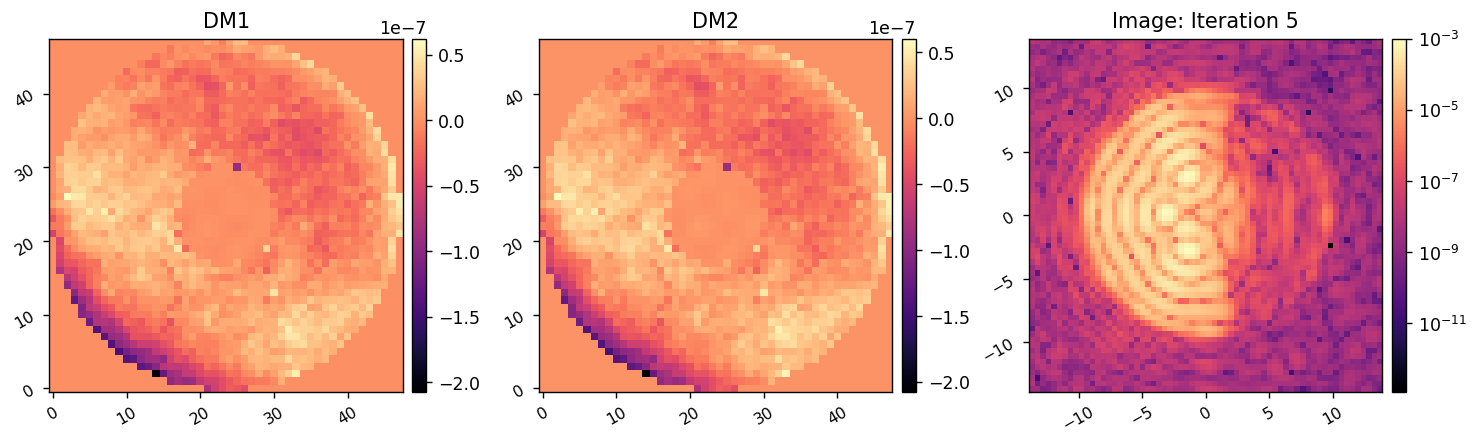

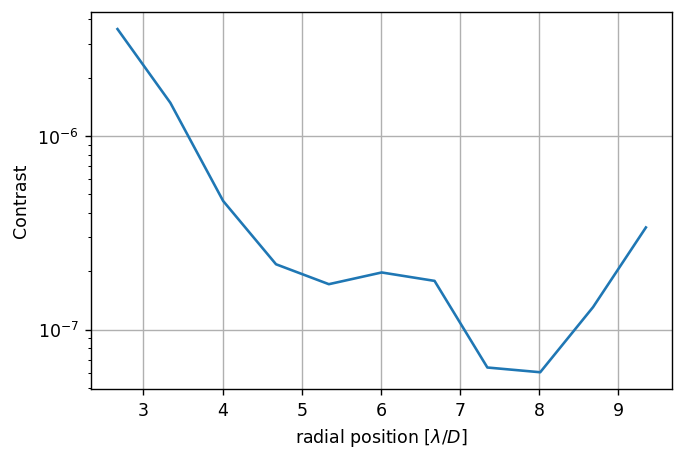

	Closed-loop iteration 6 / 20


(768,)

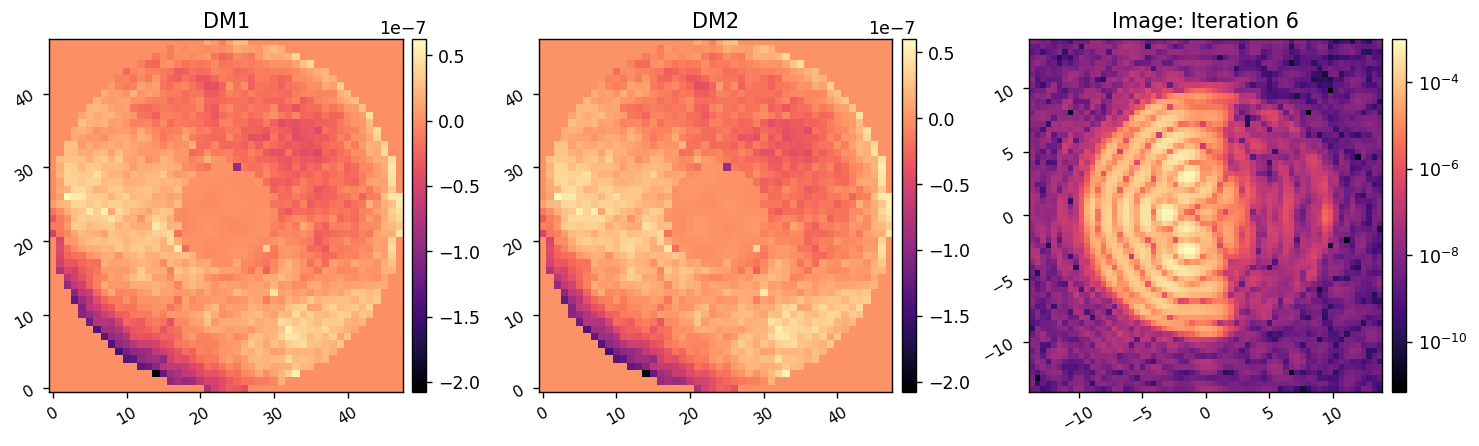

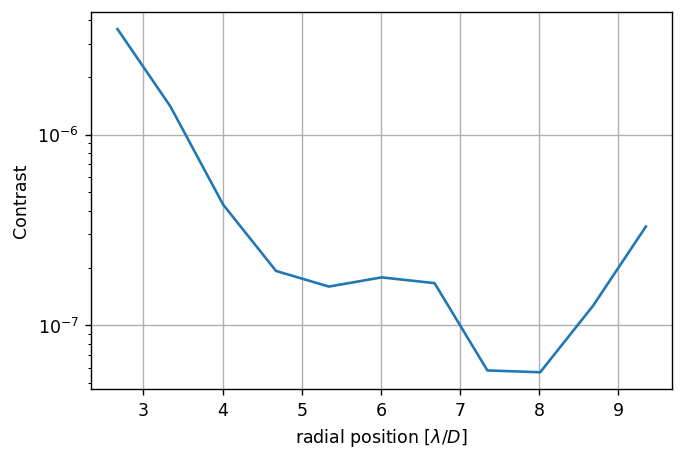

	Closed-loop iteration 7 / 20


(768,)

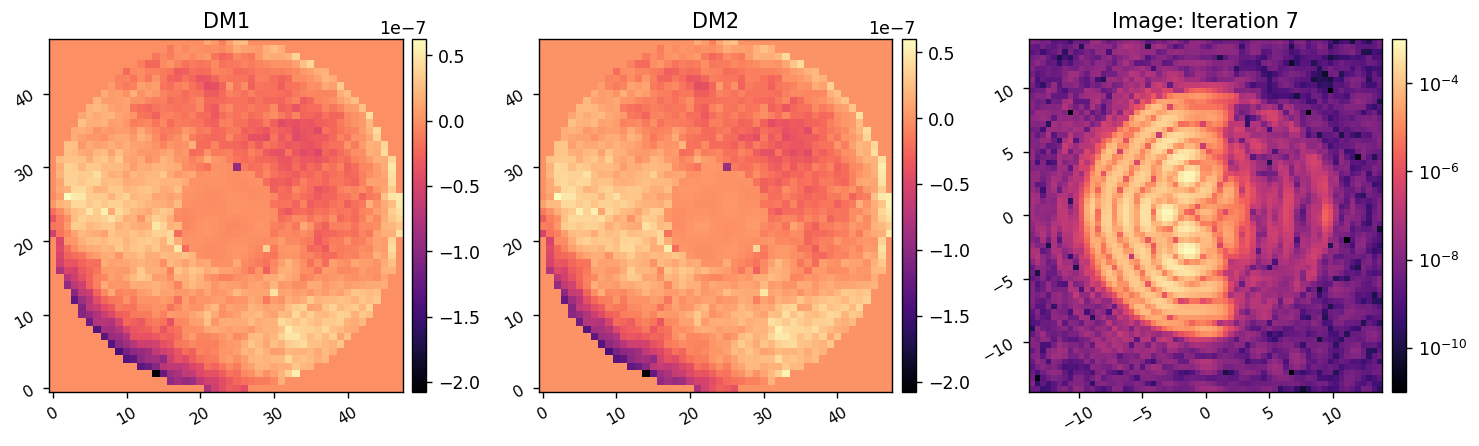

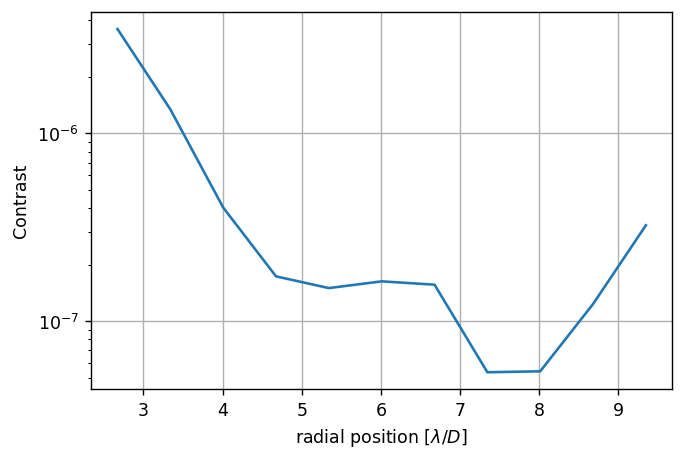

	Closed-loop iteration 8 / 20


(768,)

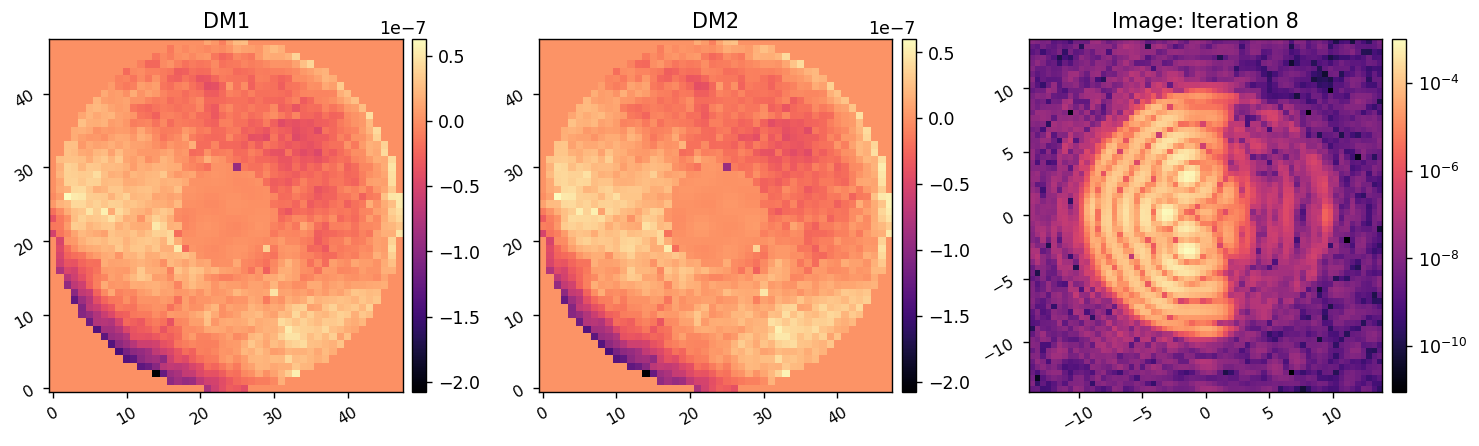

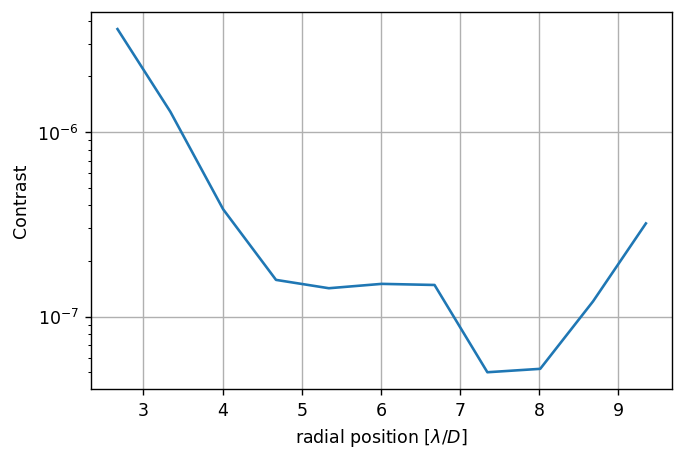

	Closed-loop iteration 9 / 20


(768,)

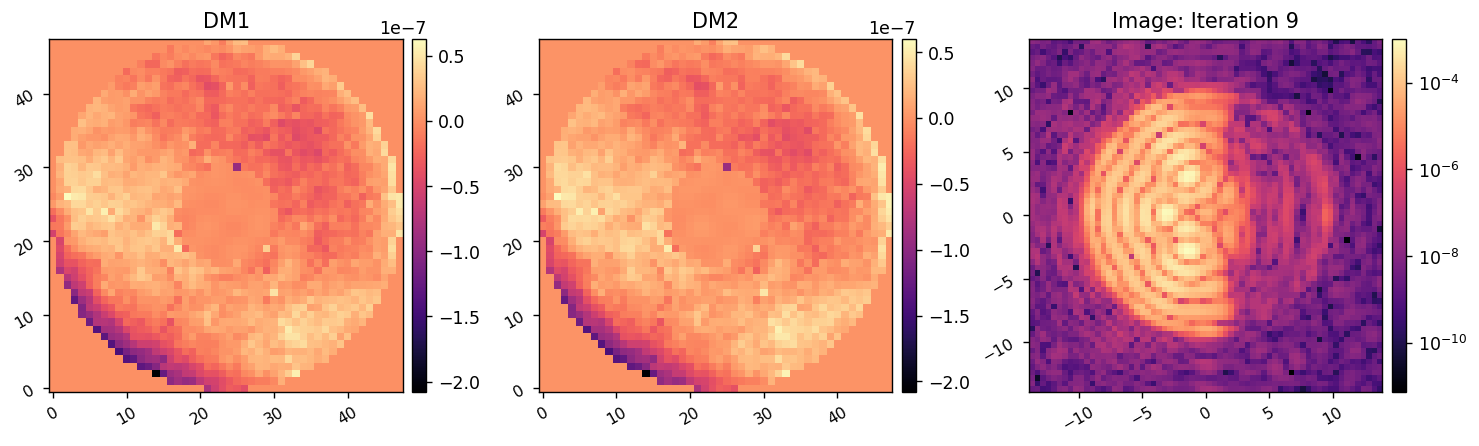

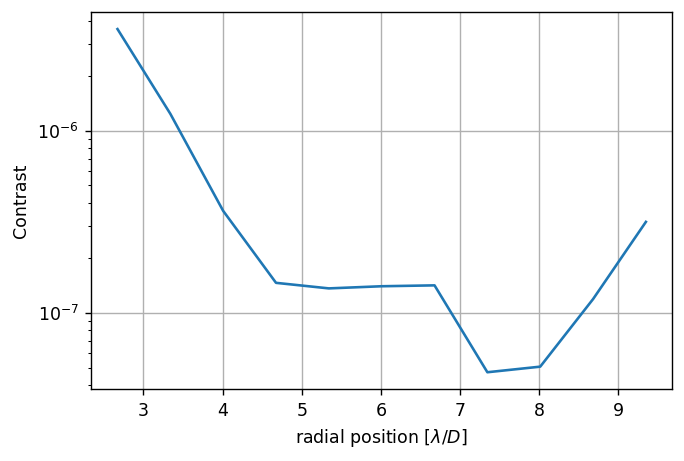

	Closed-loop iteration 10 / 20


(768,)

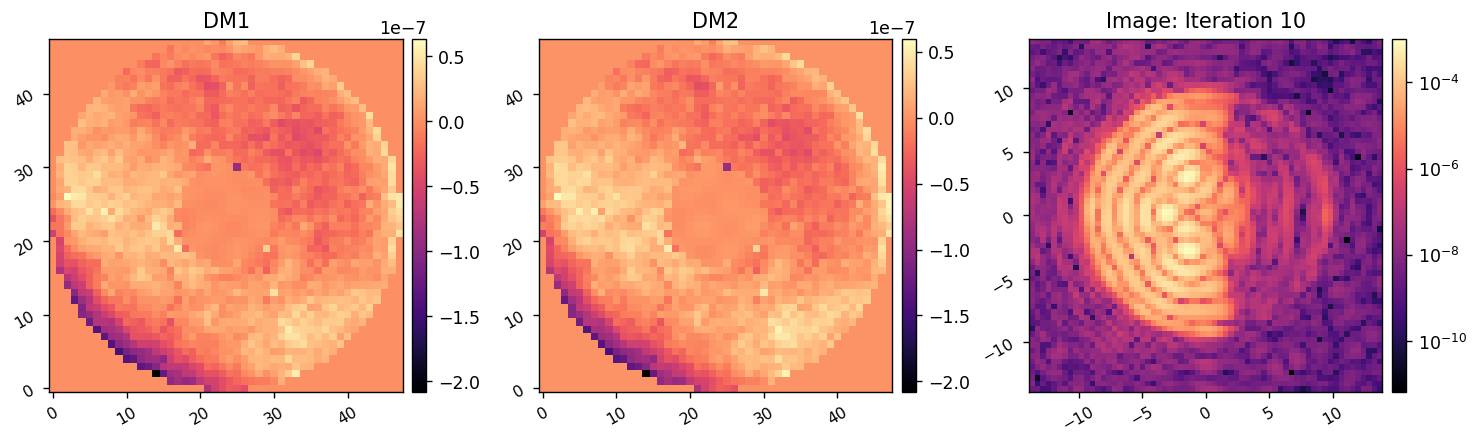

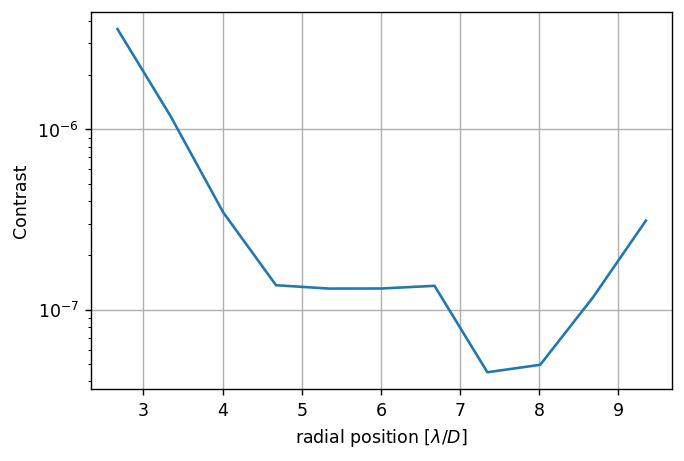

	Closed-loop iteration 11 / 20


(768,)

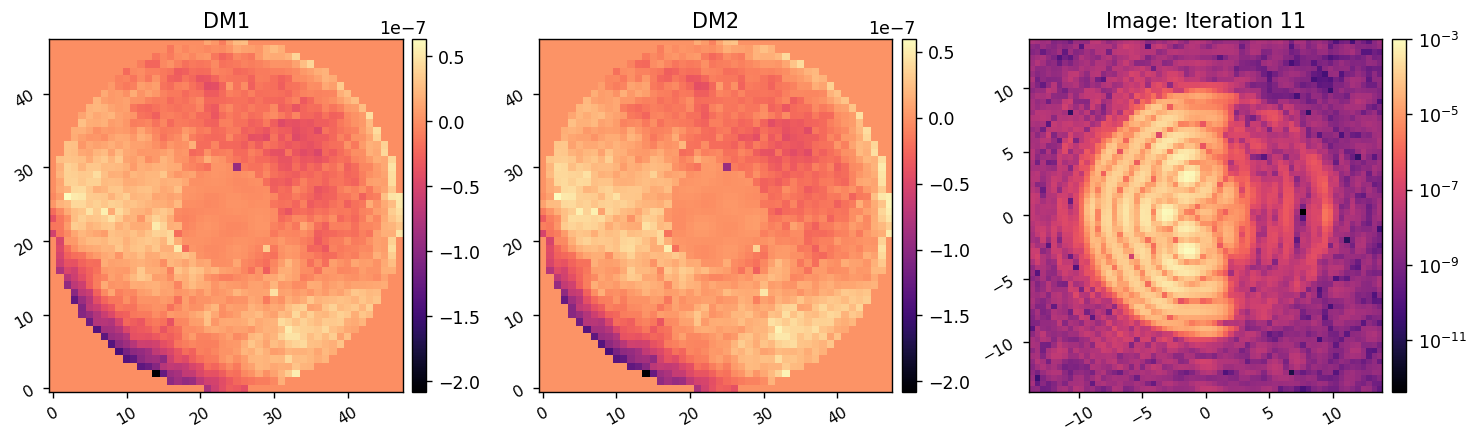

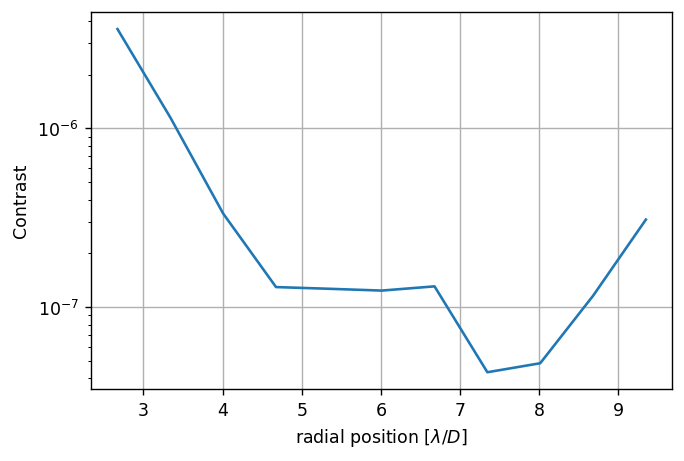

	Closed-loop iteration 12 / 20


(768,)

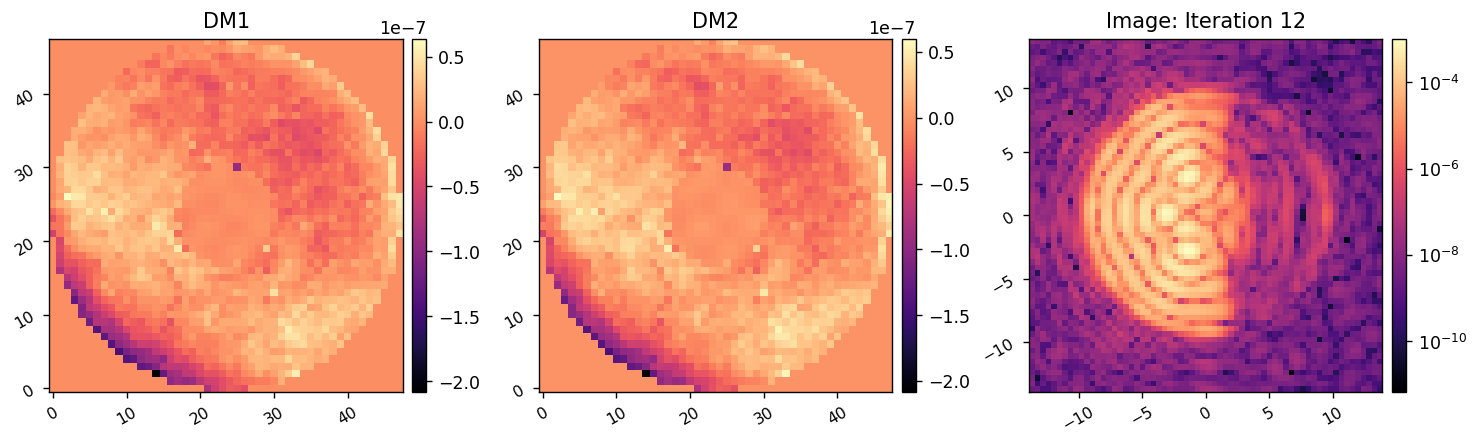

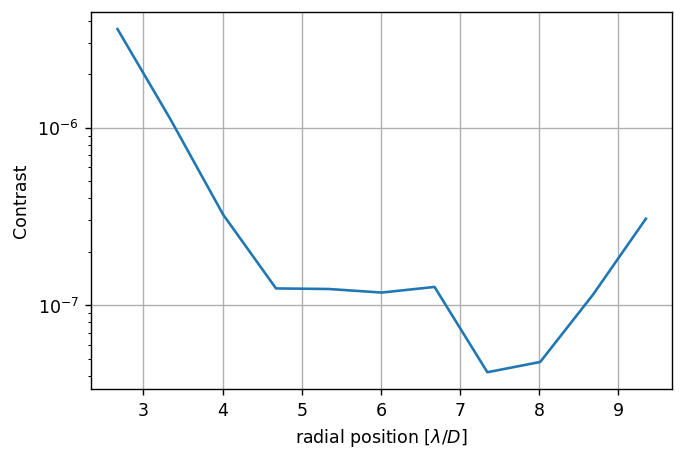

	Closed-loop iteration 13 / 20


(768,)

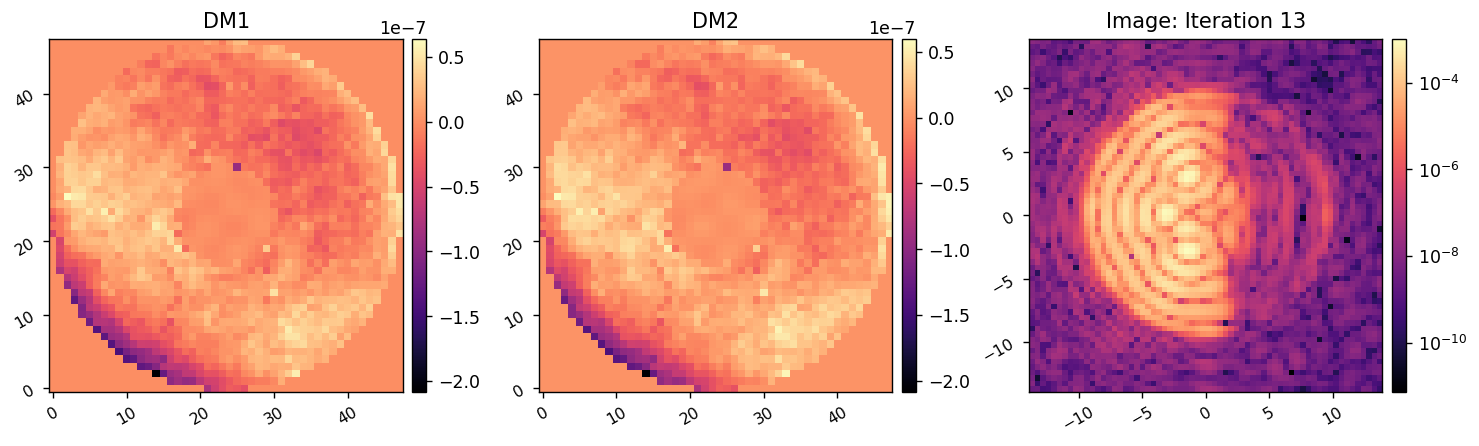

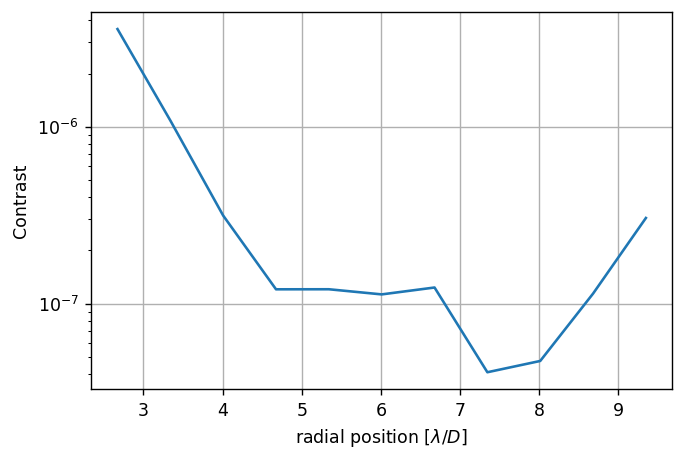

	Closed-loop iteration 14 / 20


(768,)

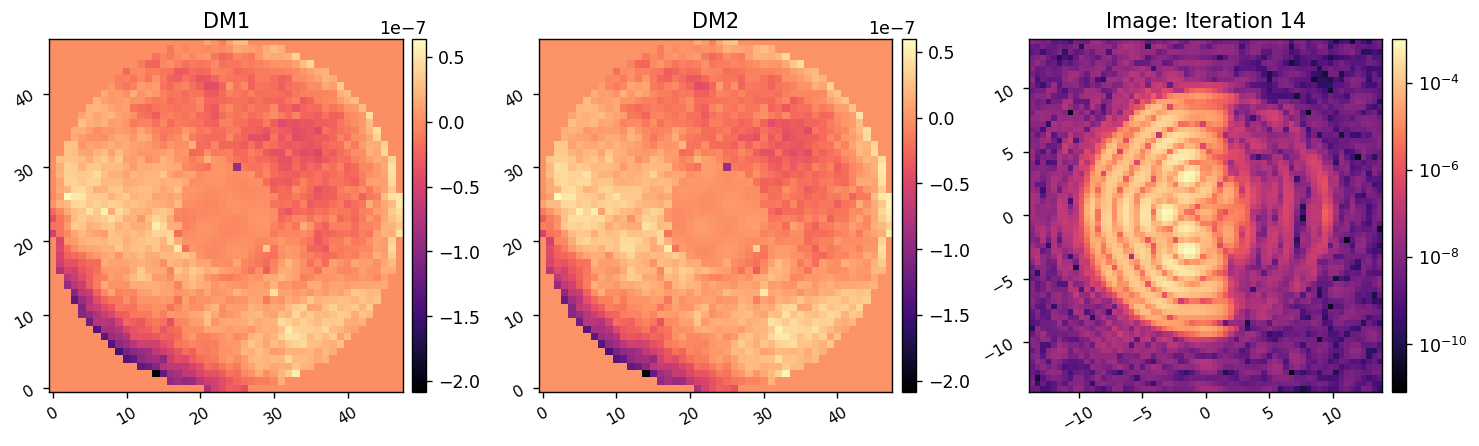

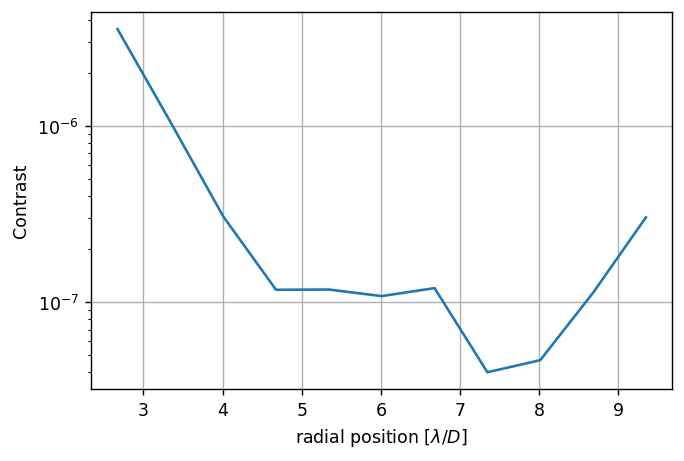

	Closed-loop iteration 15 / 20


(768,)

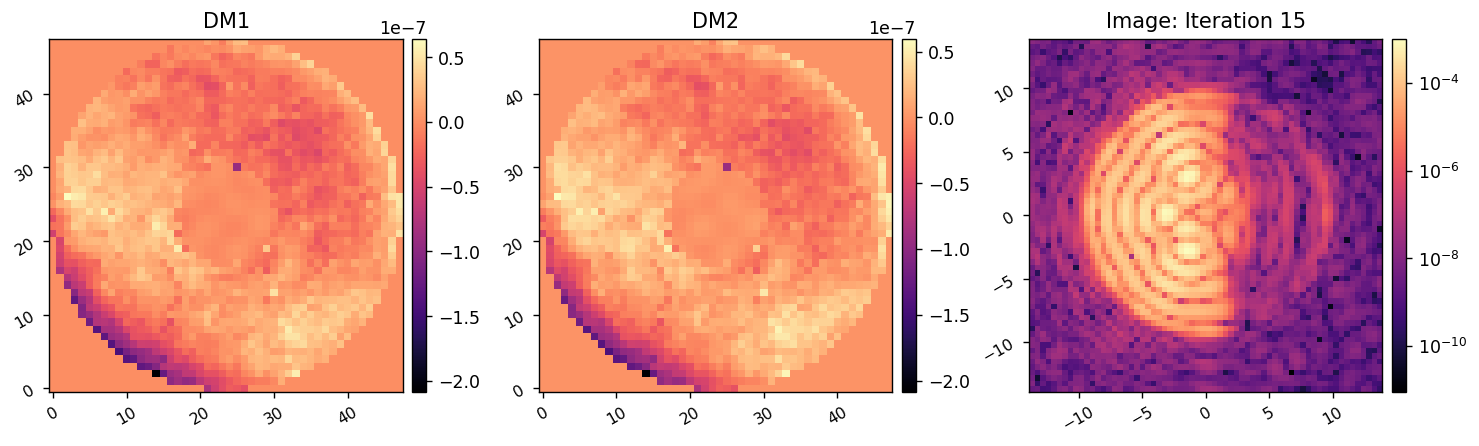

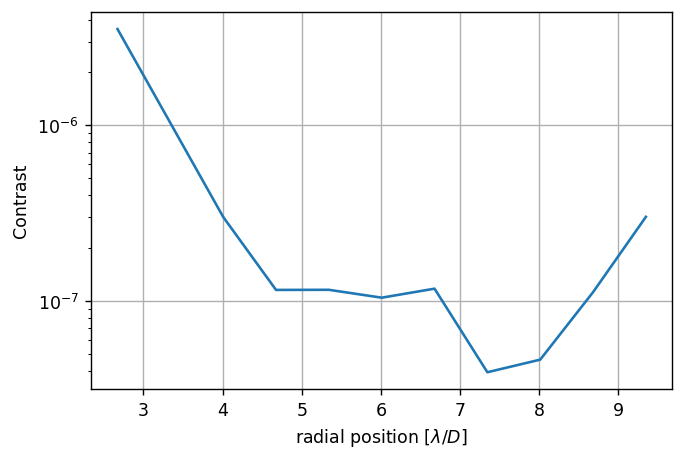

	Closed-loop iteration 16 / 20


(768,)

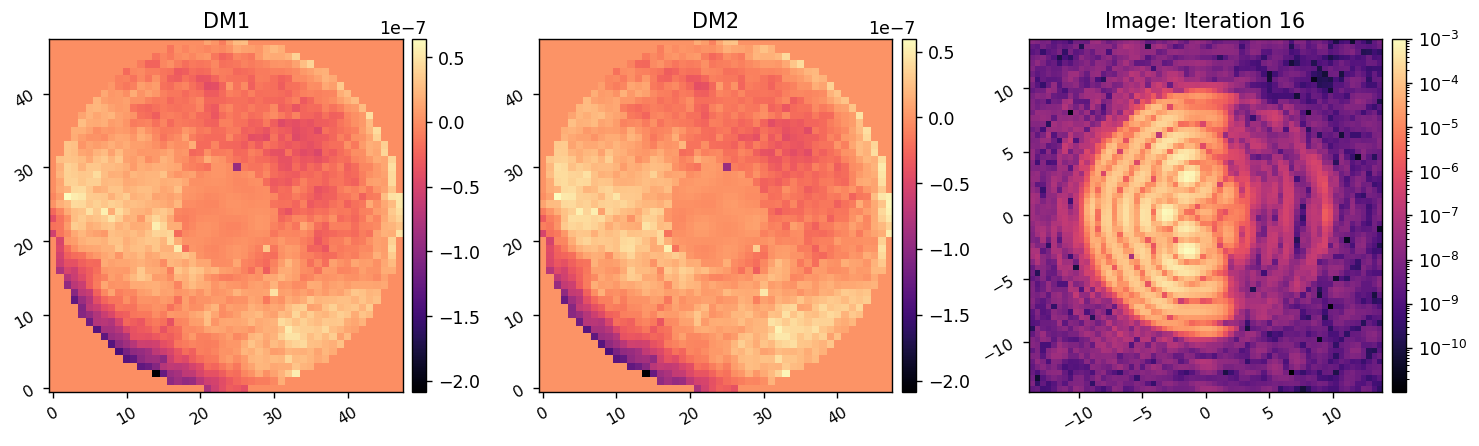

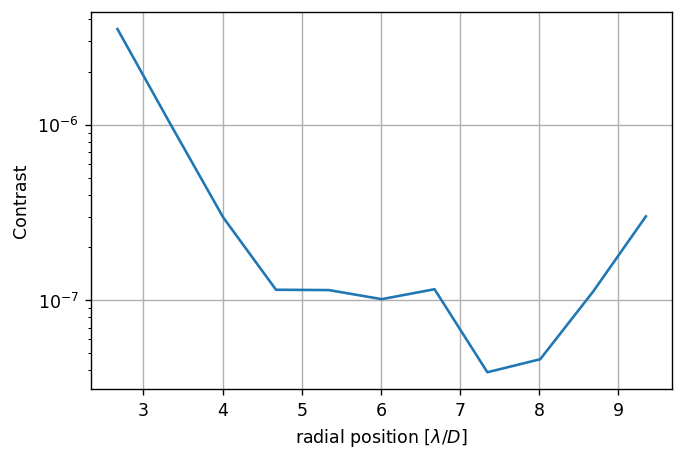

	Closed-loop iteration 17 / 20


(768,)

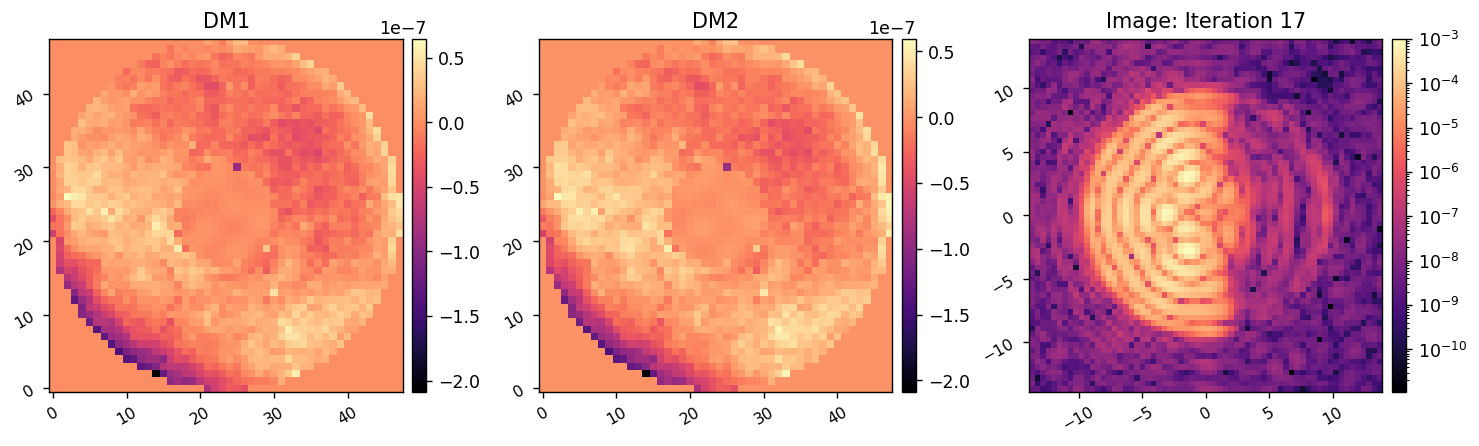

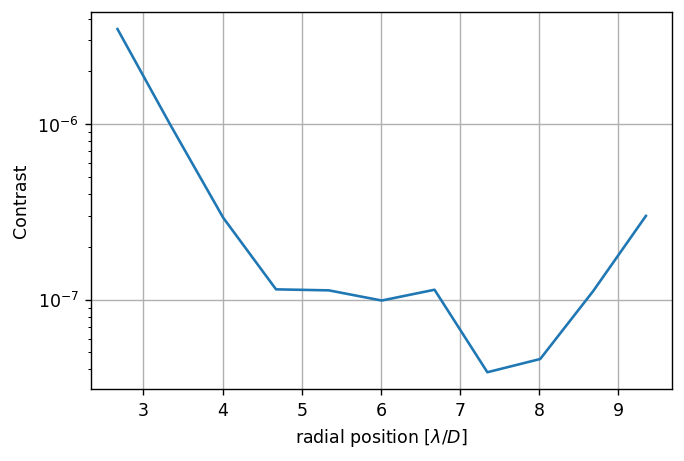

	Closed-loop iteration 18 / 20


(768,)

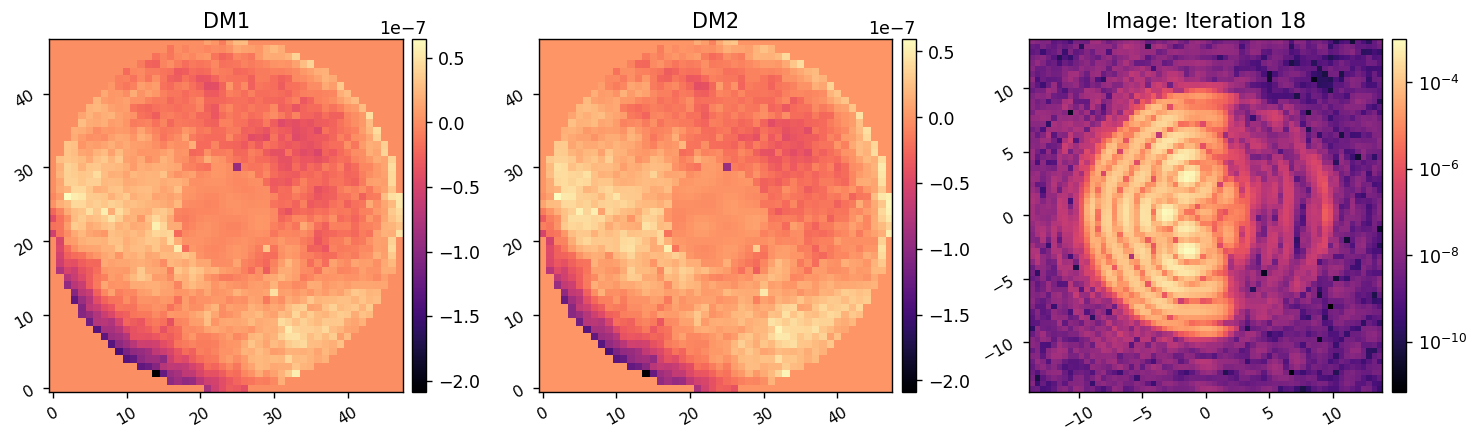

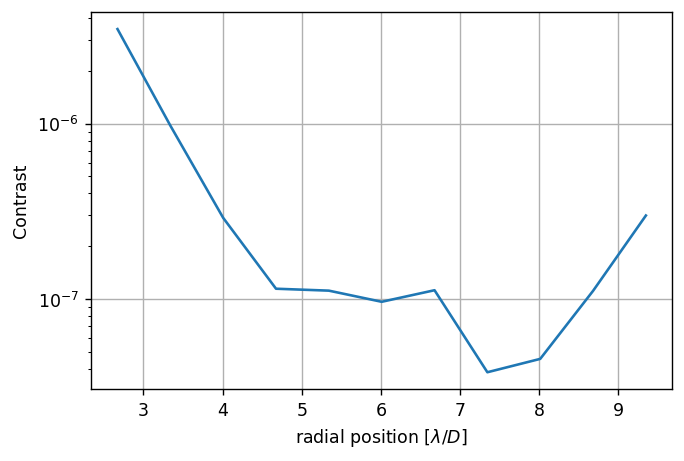

	Closed-loop iteration 19 / 20


(768,)

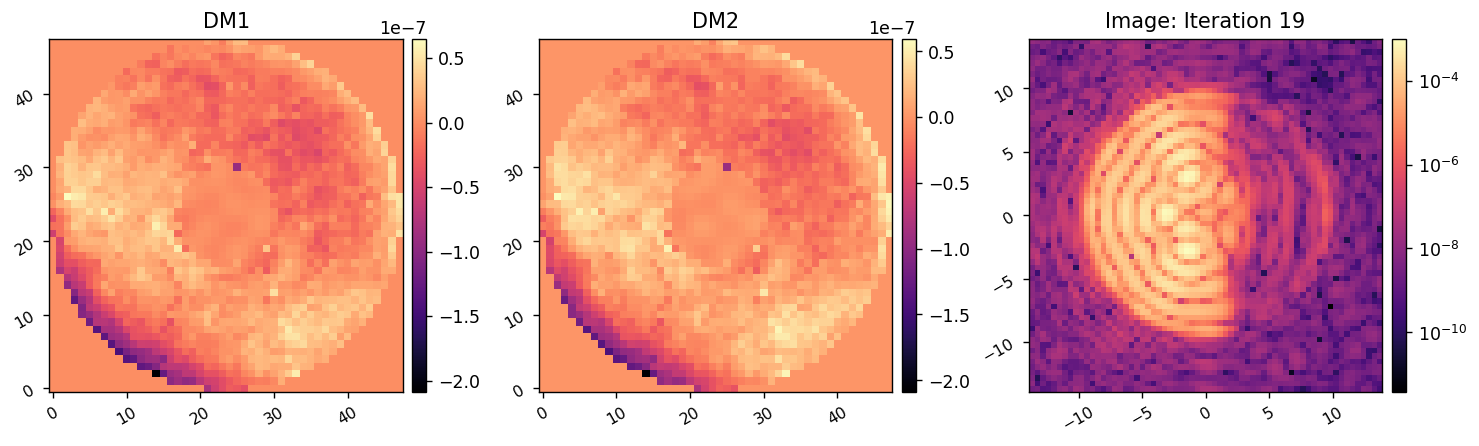

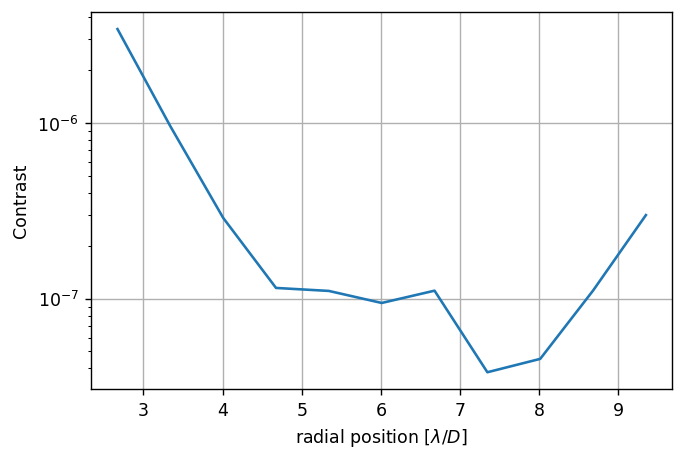

	Closed-loop iteration 20 / 20


(768,)

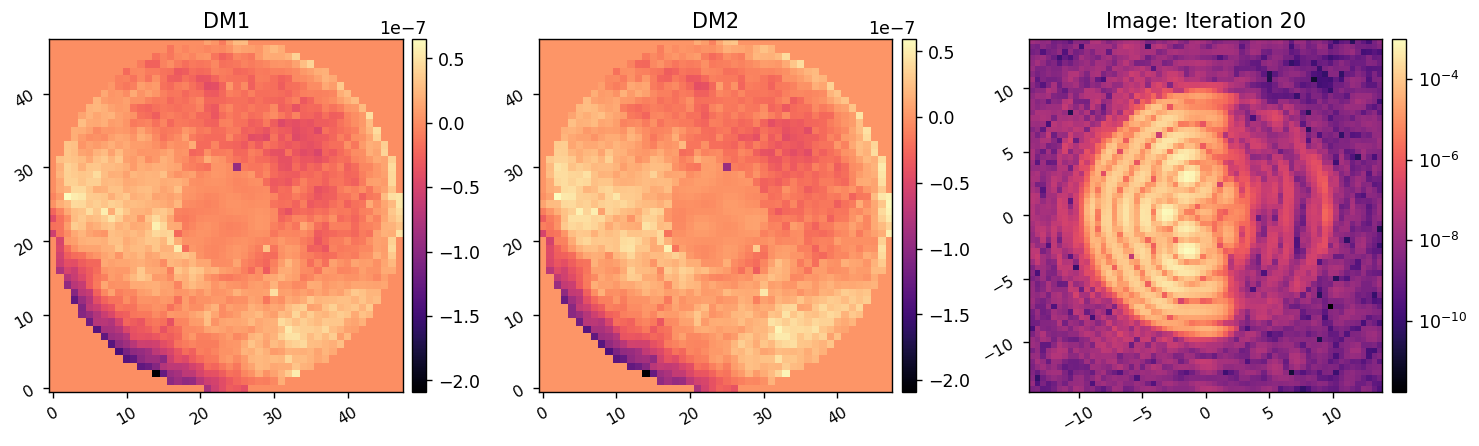

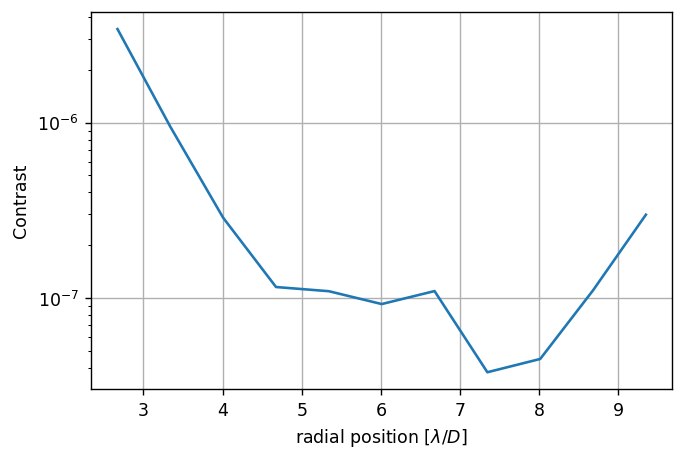

I-EFC loop completed in 58.897s.


In [16]:
reload(wfsc.iefc_2dm)
reload(wfsc.utils)

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

reg_cond = 1e-2
reg_conds = [(1e-1,10), (1e-2, 20), (1e-3, 20)]

# cm_tik = wfsc.utils.TikhonovInverse(response_matrix, rcond=reg_cond)
Wmatrix = np.diag(np.concatenate((weight_map[control_mask], weight_map[control_mask], weight_map[control_mask])))
# cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, Wmatrix, rcond=reg_cond)

for i in range(len(reg_conds)):

    cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, Wmatrix, rcond=reg_conds[i][0])
    
    images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                              cm_wls,
                                              probe_modes, 
                                              probe_amp, 
                                              fourier_modes,
                                              control_mask, 
                                              num_iterations=reg_conds[i][1], 
                                              loop_gain=0.1, 
                                              leakage=0.0,
                                              plot_all=True,
                                             )

In [20]:
response_matrix_2, response_cube_2 = wfsc.iefc_2dm.calibrate(c, 
                                                         control_mask.ravel(),
                                                         probe_amp, probe_modes, 
                                                         calib_amp, fourier_modes, 
                                                         return_all=True)

Calibrating I-EFC...
	Calibrated mode 1 / 384 in 7.590s
	Calibrated mode 2 / 384 in 15.170s
	Calibrated mode 3 / 384 in 22.727s
	Calibrated mode 4 / 384 in 30.288s
	Calibrated mode 5 / 384 in 37.853s
	Calibrated mode 6 / 384 in 45.415s
	Calibrated mode 7 / 384 in 52.984s
	Calibrated mode 8 / 384 in 60.542s
	Calibrated mode 9 / 384 in 68.093s
	Calibrated mode 10 / 384 in 75.653s
	Calibrated mode 11 / 384 in 83.209s
	Calibrated mode 12 / 384 in 90.775s
	Calibrated mode 13 / 384 in 98.319s
	Calibrated mode 14 / 384 in 105.882s
	Calibrated mode 15 / 384 in 113.440s
	Calibrated mode 16 / 384 in 120.964s
	Calibrated mode 17 / 384 in 128.496s
	Calibrated mode 18 / 384 in 136.036s
	Calibrated mode 19 / 384 in 143.558s
	Calibrated mode 20 / 384 in 151.069s
	Calibrated mode 21 / 384 in 158.586s
	Calibrated mode 22 / 384 in 166.100s
	Calibrated mode 23 / 384 in 173.613s
	Calibrated mode 24 / 384 in 181.137s
	Calibrated mode 25 / 384 in 188.707s
	Calibrated mode 26 / 384 in 196.221s
	Calibrated mo

	Calibrated mode 212 / 384 in 1613.858s
	Calibrated mode 213 / 384 in 1621.509s
	Calibrated mode 214 / 384 in 1629.172s
	Calibrated mode 215 / 384 in 1636.822s
	Calibrated mode 216 / 384 in 1644.562s
	Calibrated mode 217 / 384 in 1652.187s
	Calibrated mode 218 / 384 in 1659.849s
	Calibrated mode 219 / 384 in 1667.490s
	Calibrated mode 220 / 384 in 1675.144s
	Calibrated mode 221 / 384 in 1683.133s
	Calibrated mode 222 / 384 in 1690.739s
	Calibrated mode 223 / 384 in 1698.380s
	Calibrated mode 224 / 384 in 1706.244s
	Calibrated mode 225 / 384 in 1713.896s
	Calibrated mode 226 / 384 in 1721.531s
	Calibrated mode 227 / 384 in 1729.417s
	Calibrated mode 228 / 384 in 1737.177s
	Calibrated mode 229 / 384 in 1745.114s
	Calibrated mode 230 / 384 in 1752.768s
	Calibrated mode 231 / 384 in 1760.427s
	Calibrated mode 232 / 384 in 1768.320s
	Calibrated mode 233 / 384 in 1776.218s
	Calibrated mode 234 / 384 in 1784.210s
	Calibrated mode 235 / 384 in 1792.080s
	Calibrated mode 236 / 384 in 1799.960s


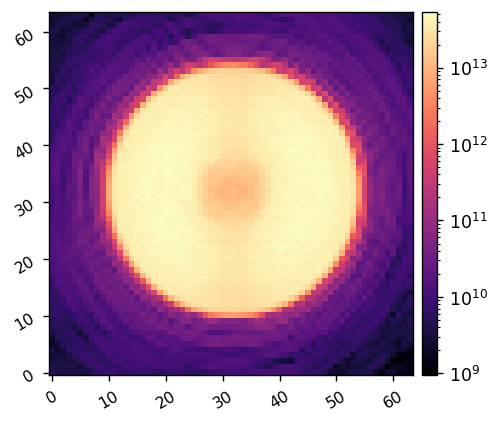

In [21]:
response_sum = xp.sum(abs(response_cube_2), axis=(0,1))
wfsc.imshow1(response_sum.reshape(npsf, npsf), lognorm=True)

In [32]:
c.set_dm1(dm1_commands[-1])
c.set_dm2(dm2_commands[-1])

Running I-EFC...
	Closed-loop iteration 1 / 10


(768,)

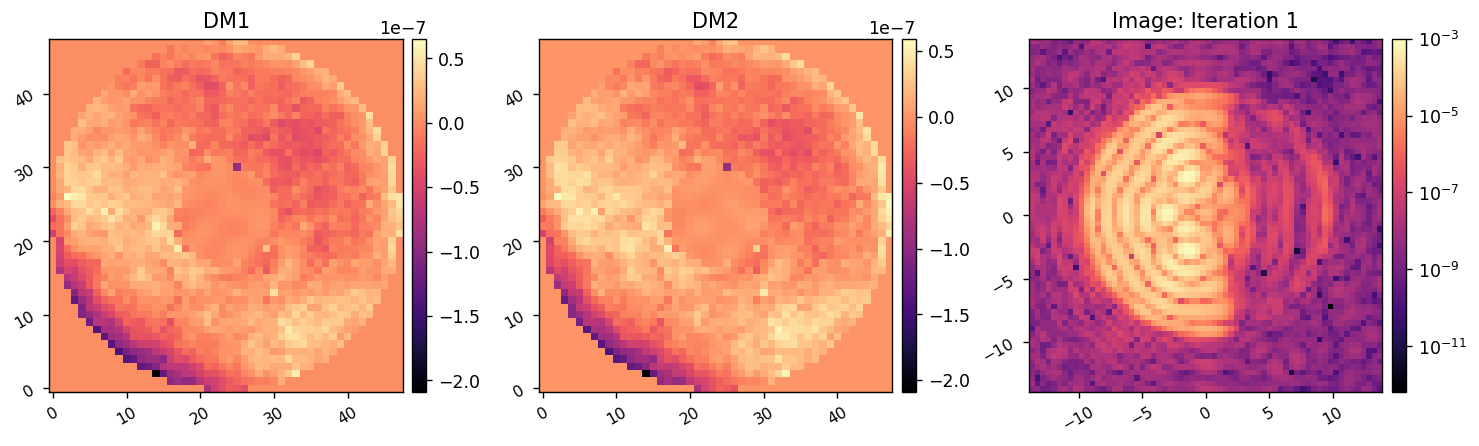

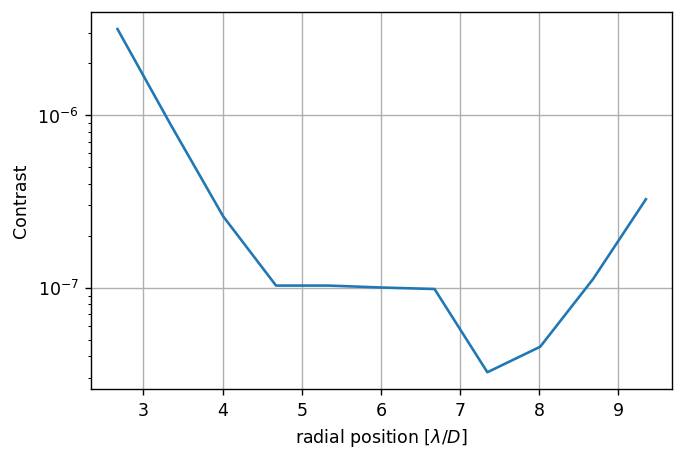

	Closed-loop iteration 2 / 10


(768,)

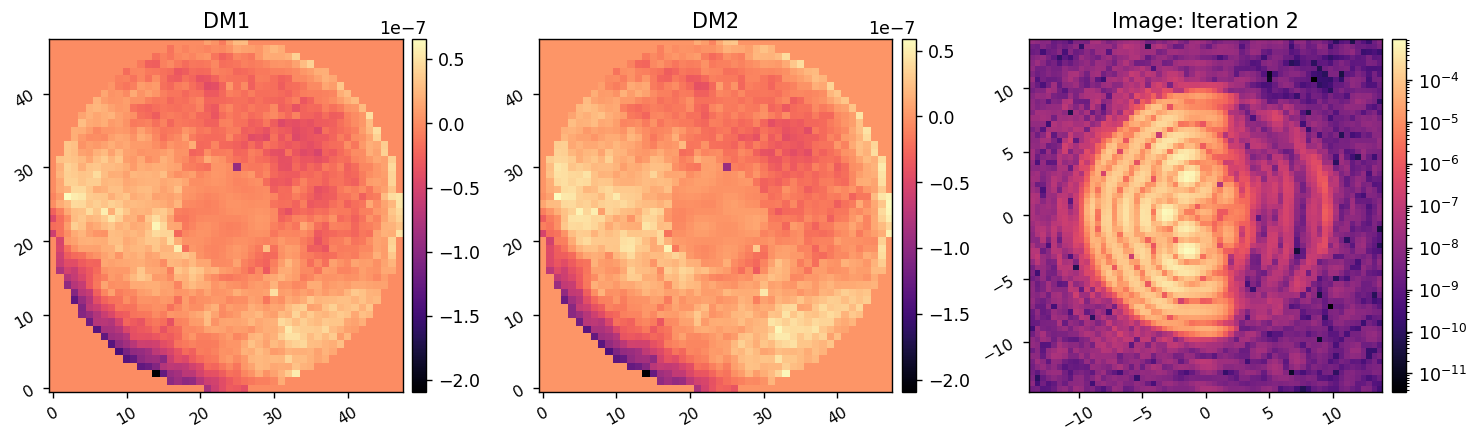

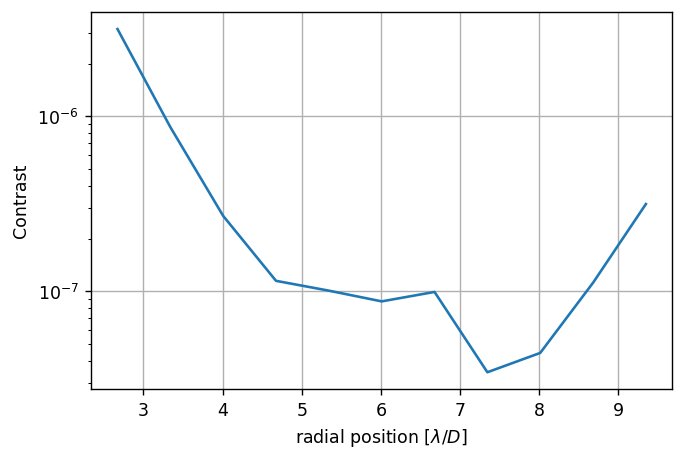

	Closed-loop iteration 3 / 10


(768,)

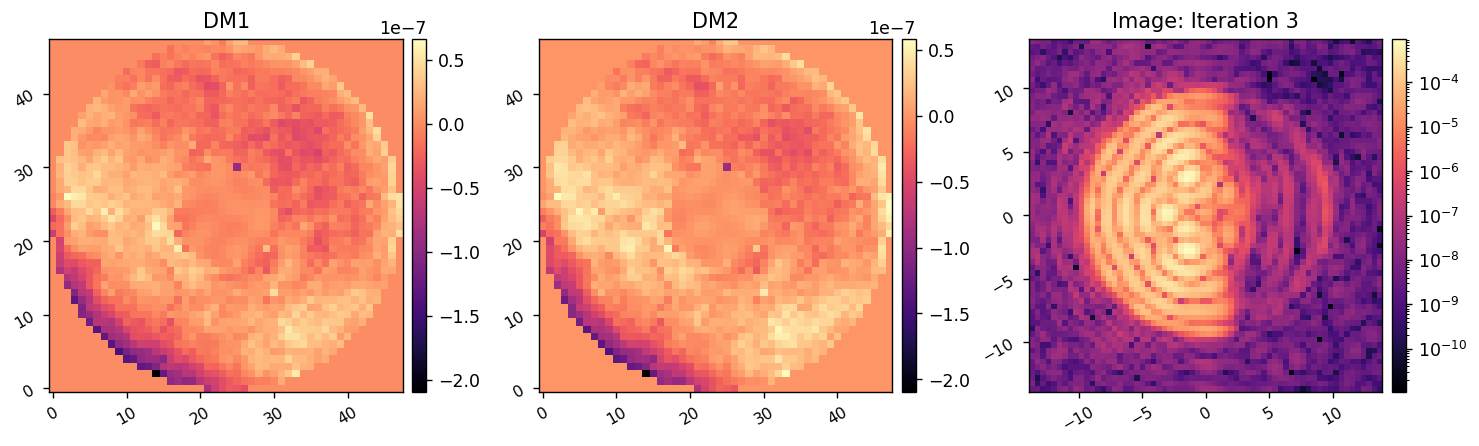

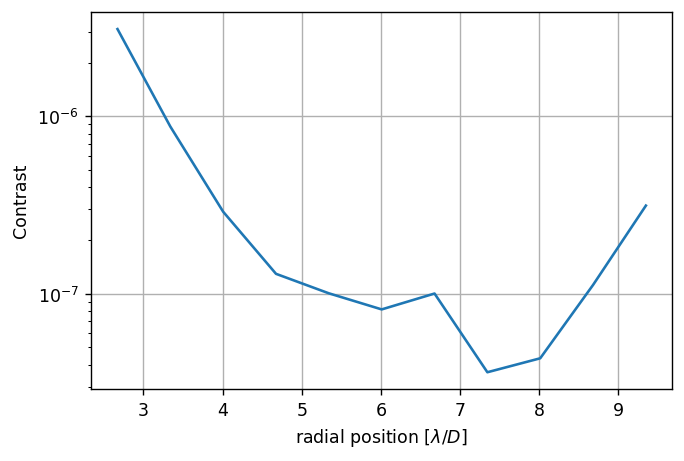

	Closed-loop iteration 4 / 10


(768,)

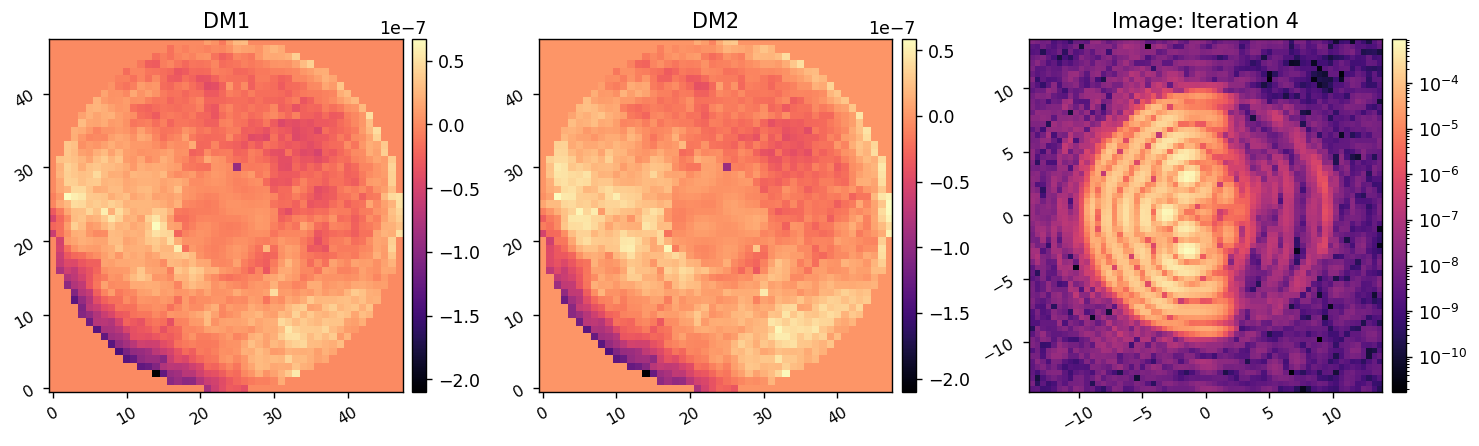

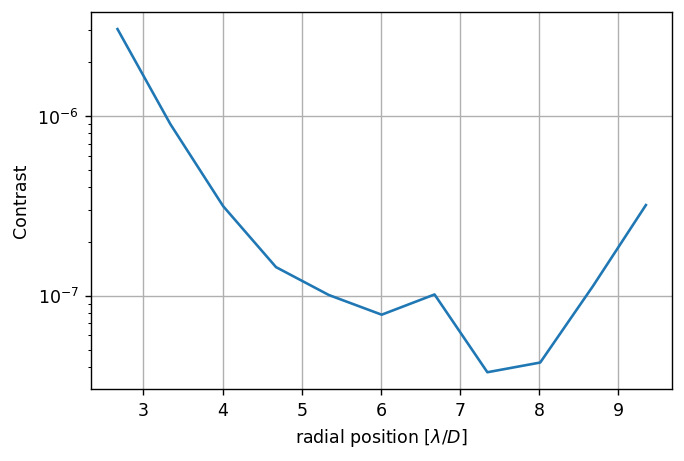

	Closed-loop iteration 5 / 10


(768,)

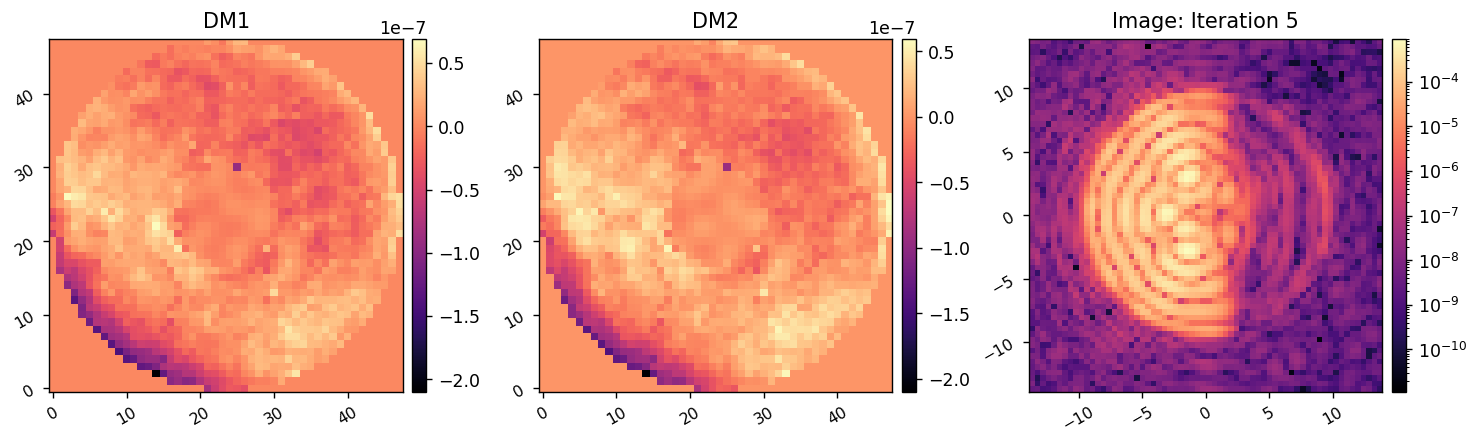

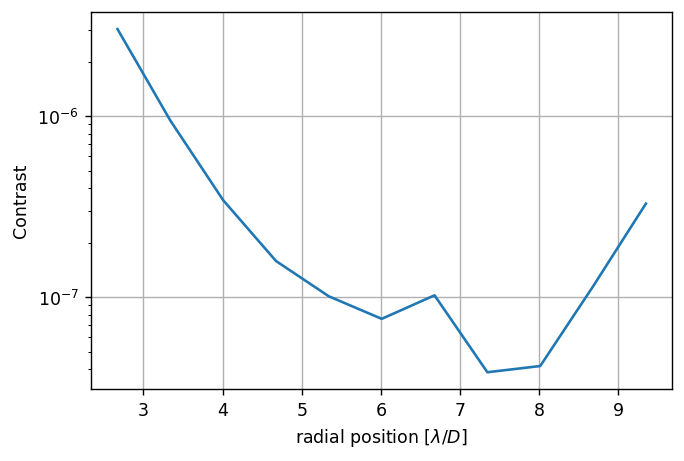

	Closed-loop iteration 6 / 10


(768,)

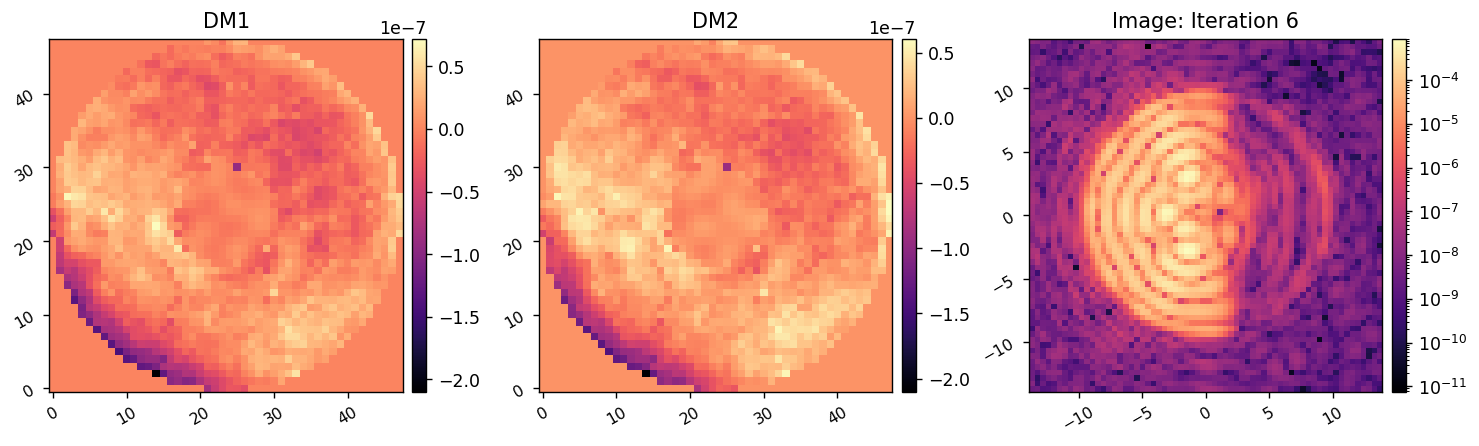

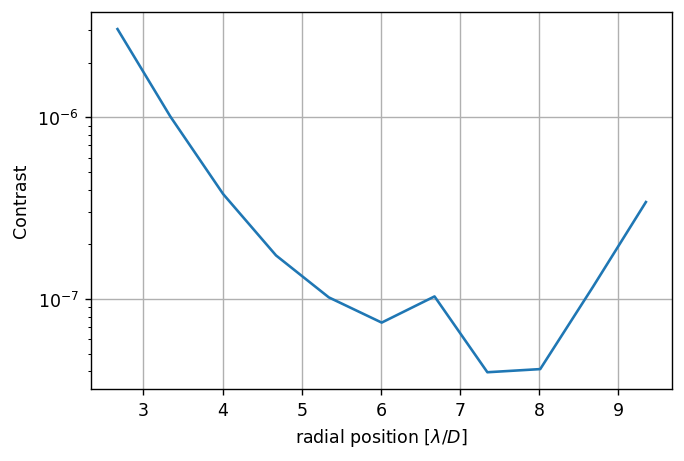

	Closed-loop iteration 7 / 10


(768,)

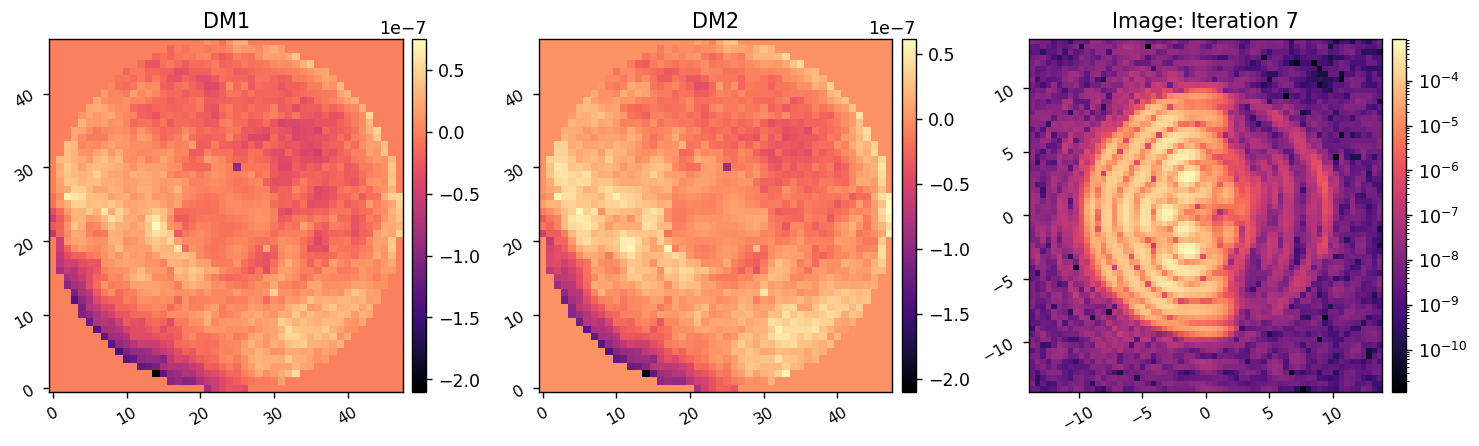

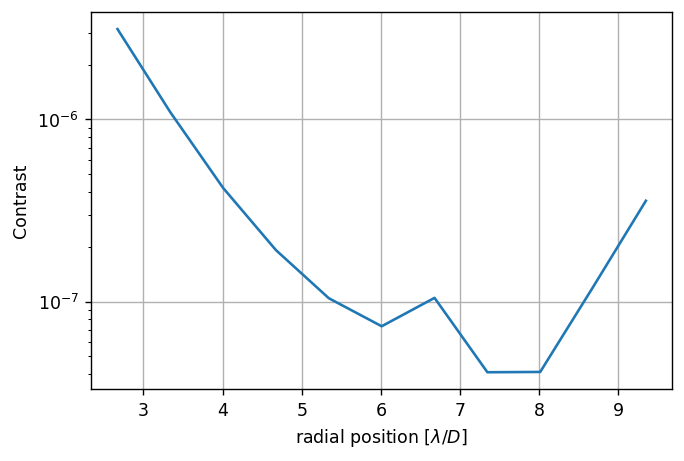

	Closed-loop iteration 8 / 10


(768,)

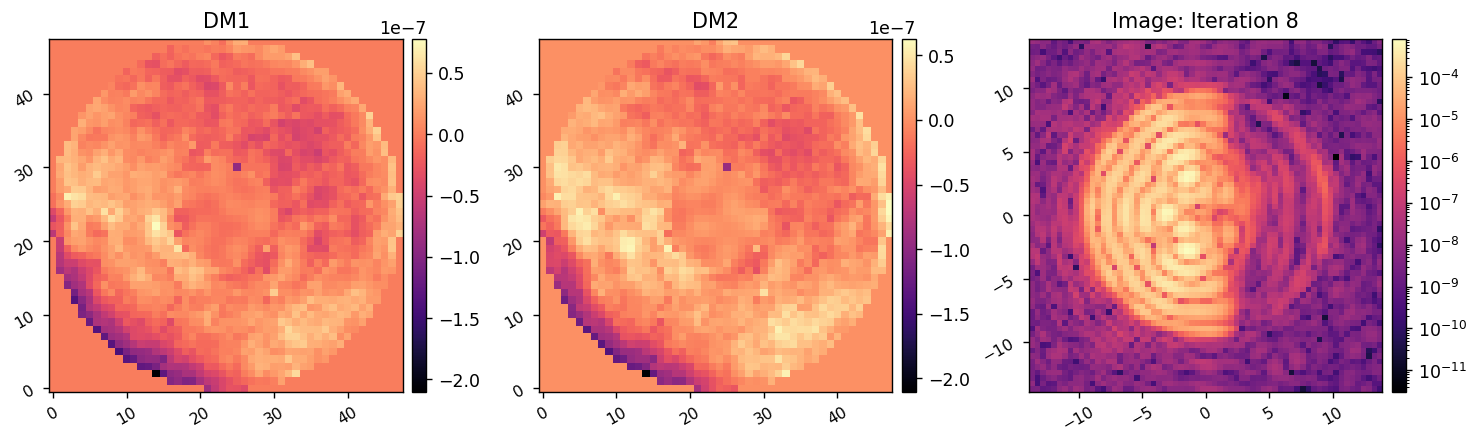

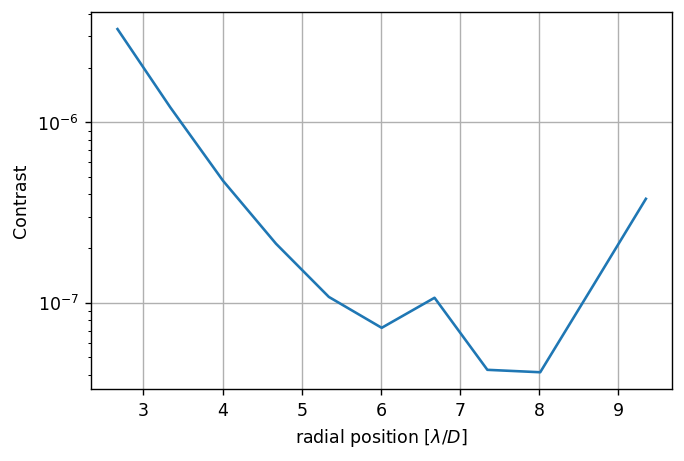

	Closed-loop iteration 9 / 10


(768,)

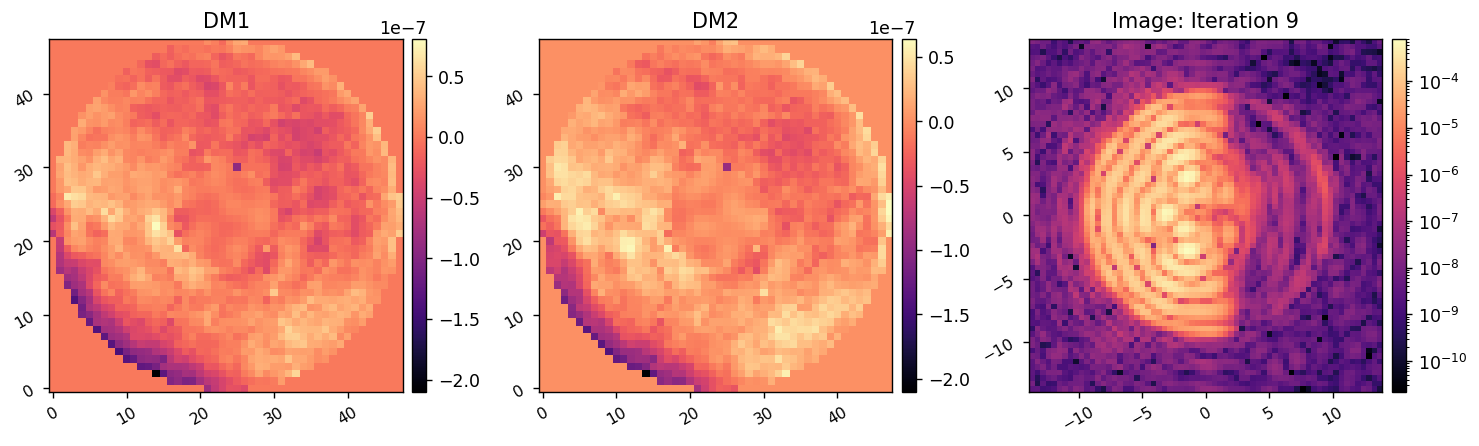

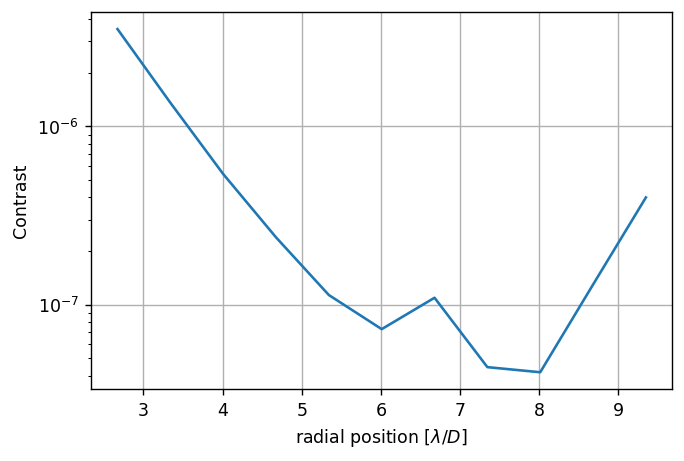

	Closed-loop iteration 10 / 10


(768,)

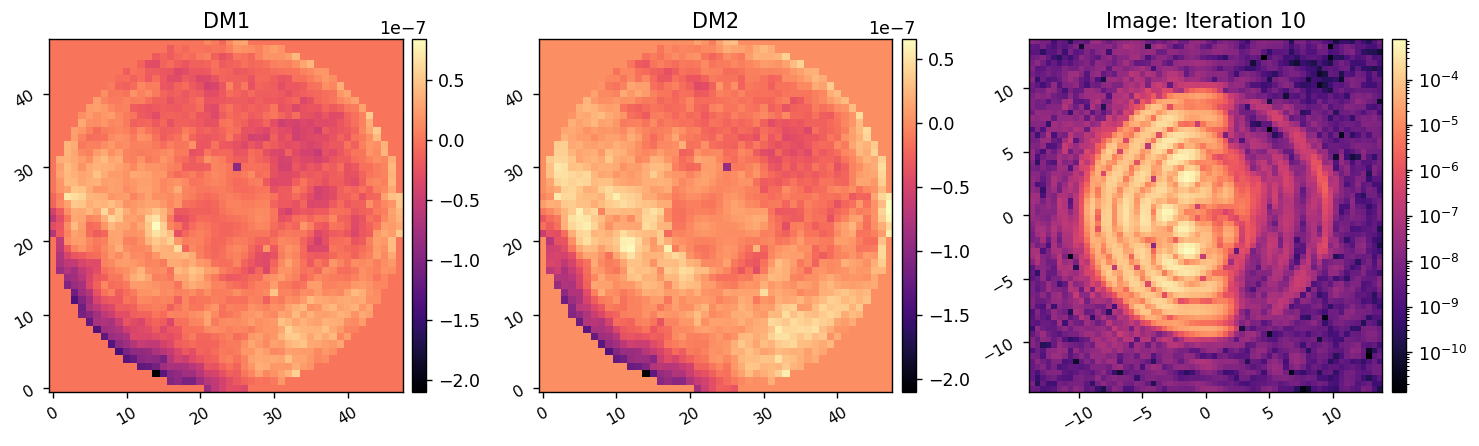

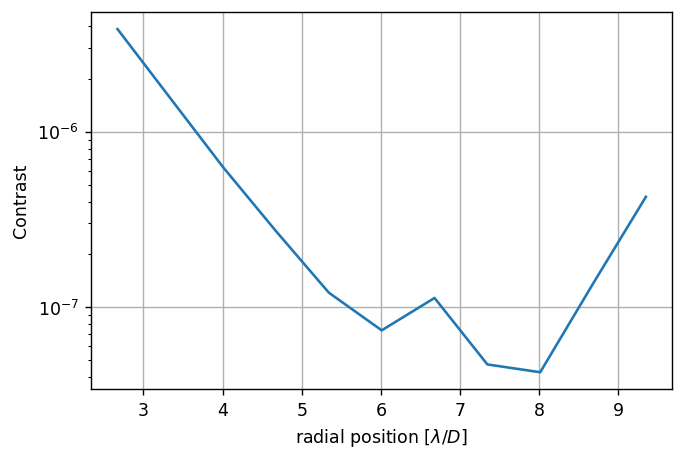

I-EFC loop completed in 32.202s.
Running I-EFC...
	Closed-loop iteration 1 / 20


(768,)

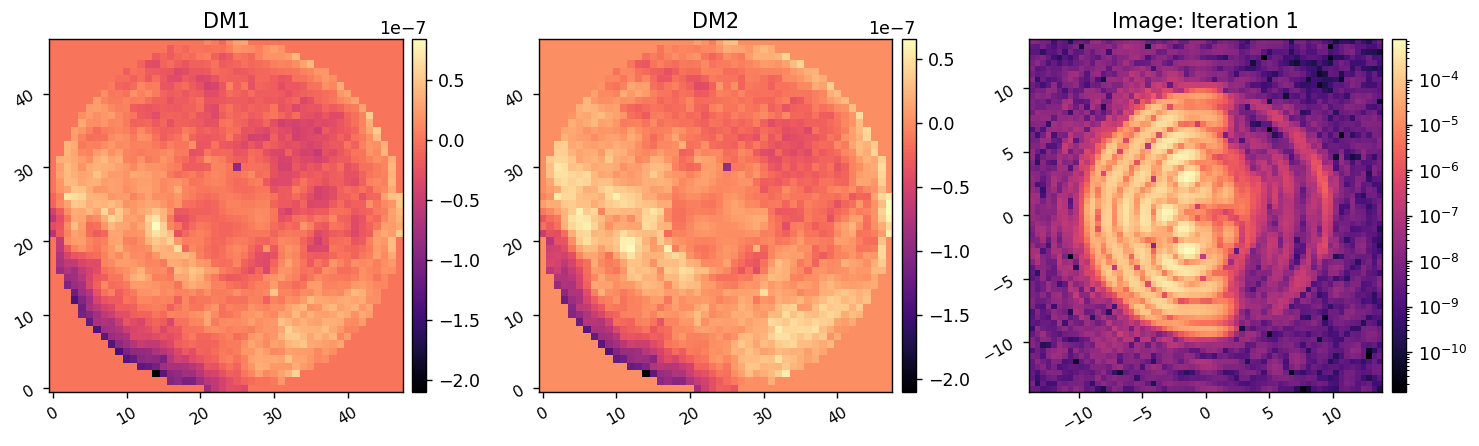

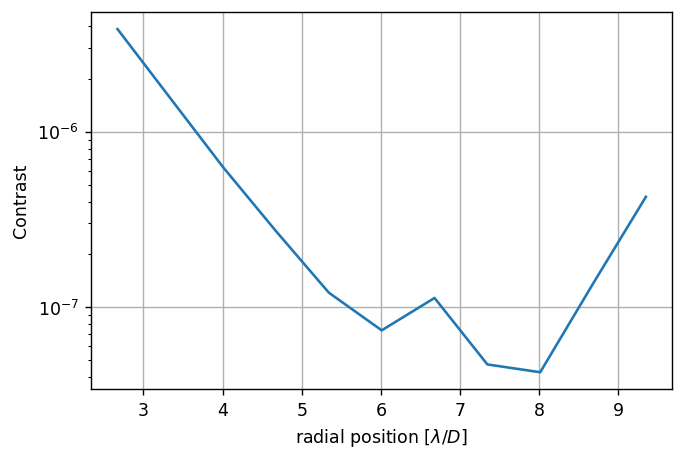

	Closed-loop iteration 2 / 20


(768,)

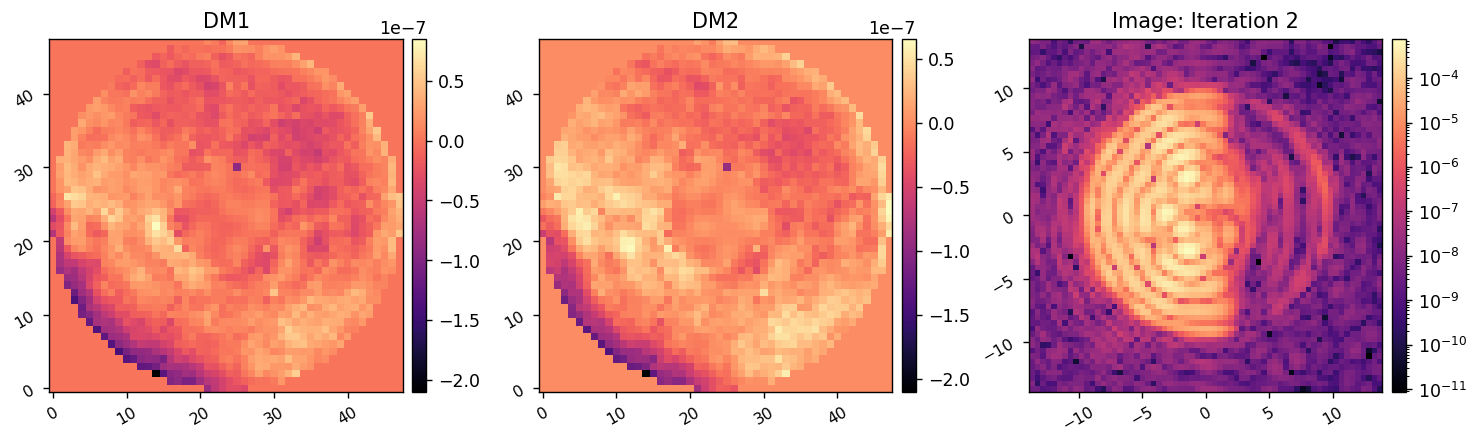

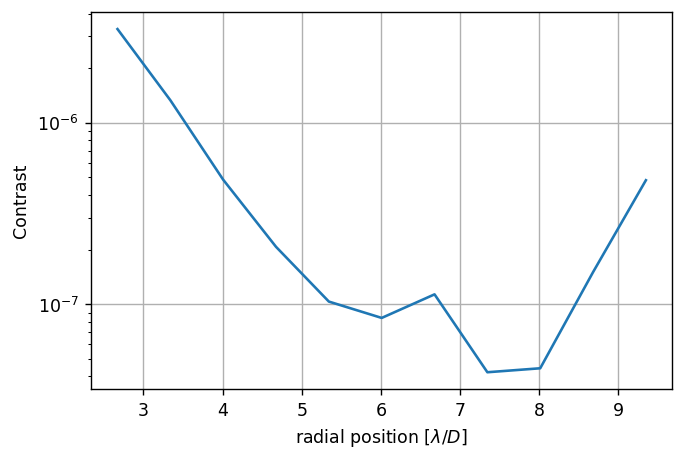

	Closed-loop iteration 3 / 20


(768,)

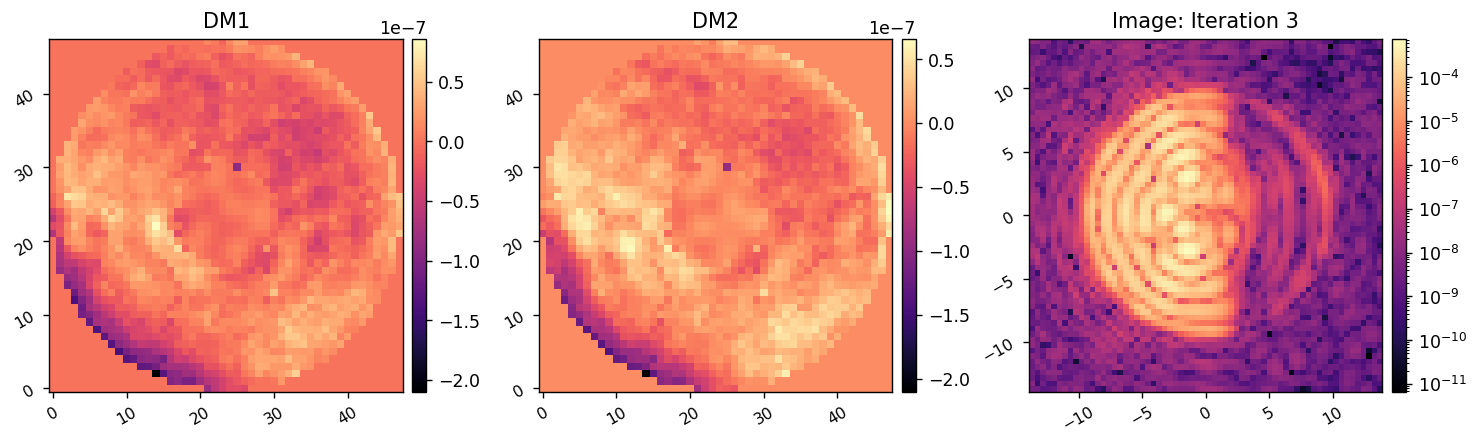

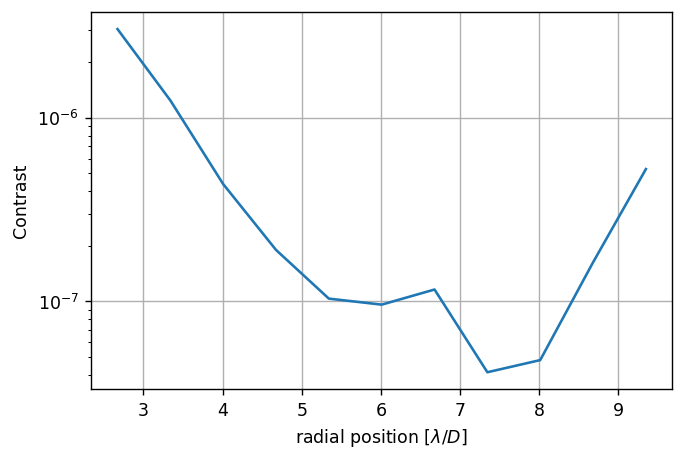

	Closed-loop iteration 4 / 20


(768,)

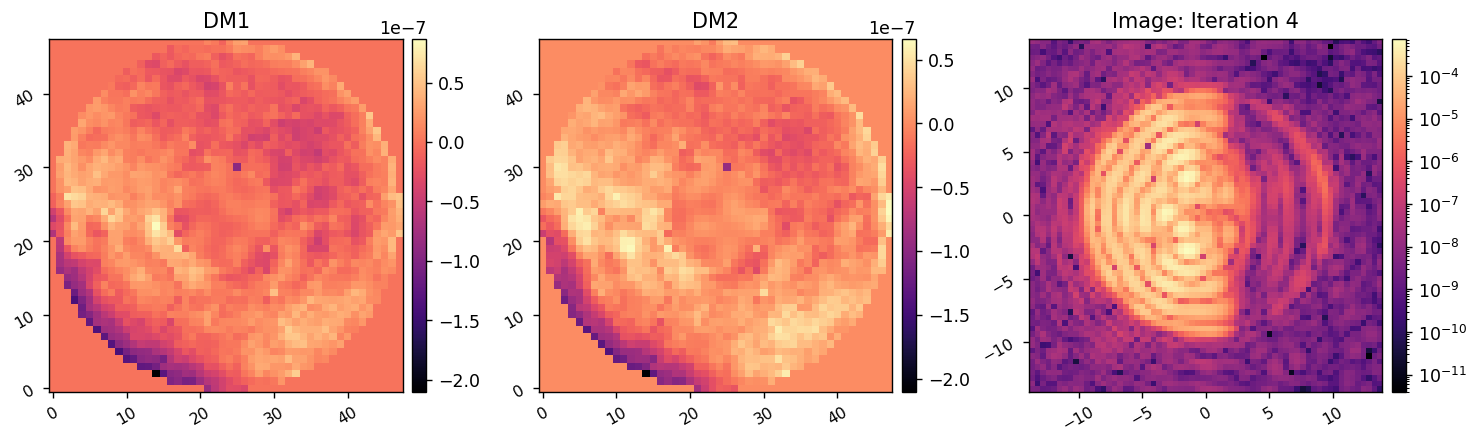

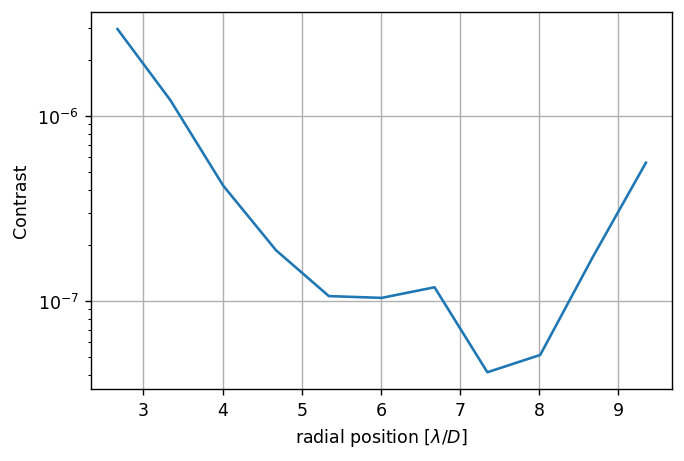

	Closed-loop iteration 5 / 20


(768,)

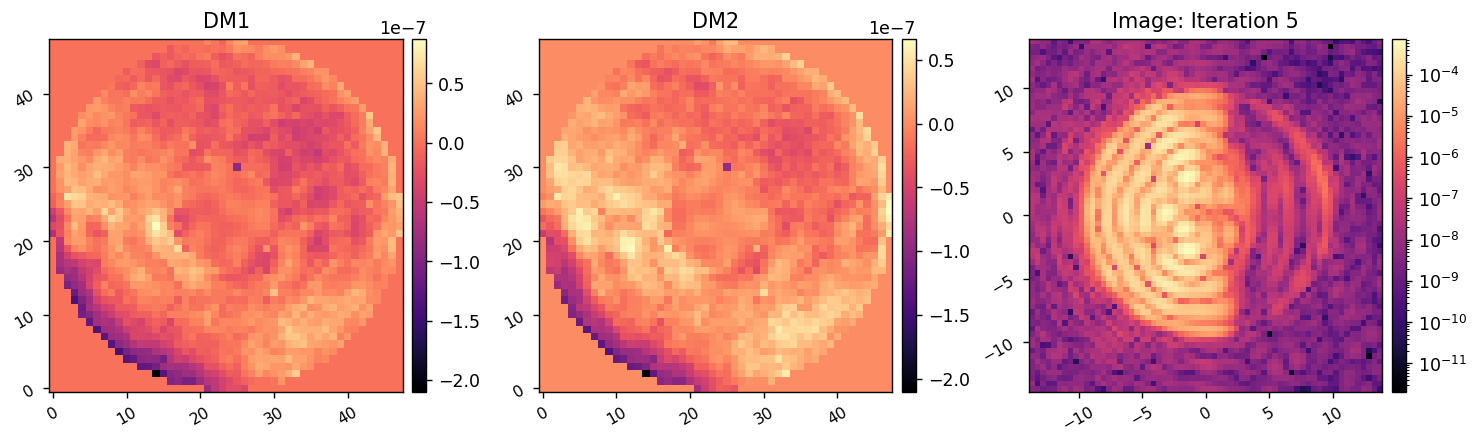

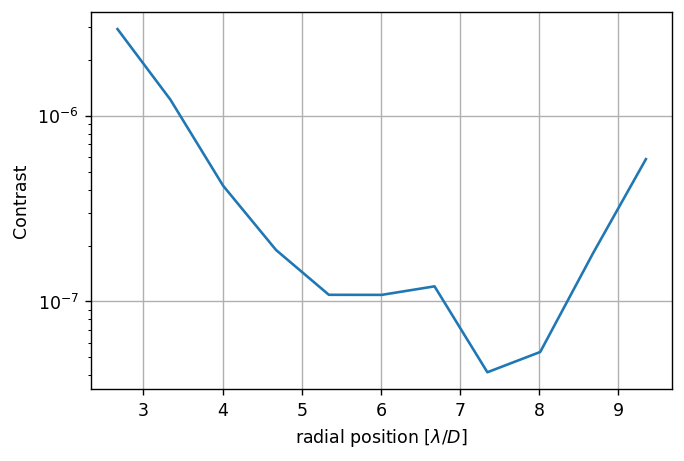

	Closed-loop iteration 6 / 20


(768,)

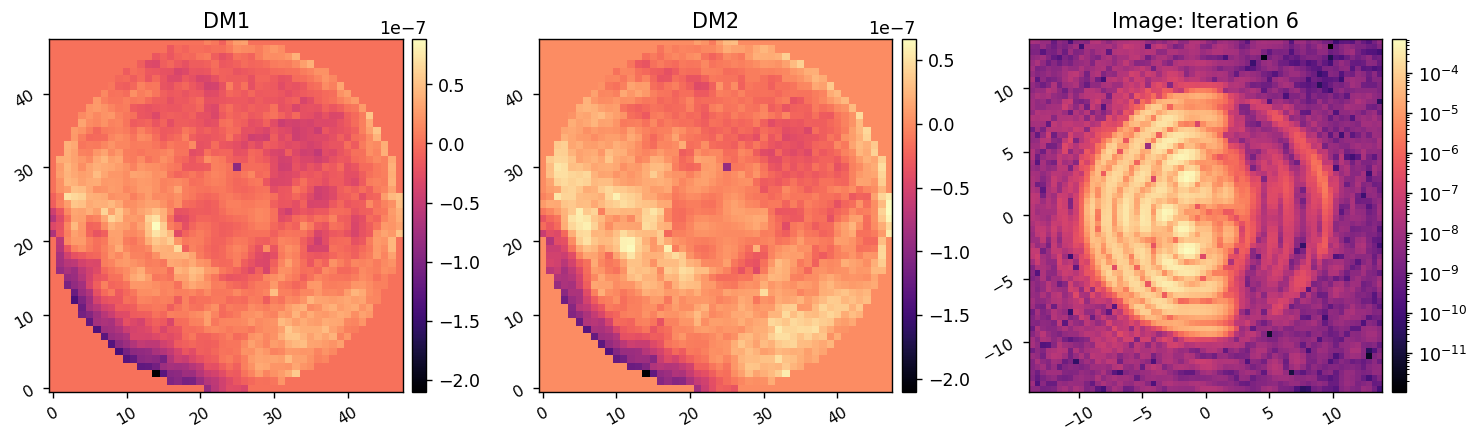

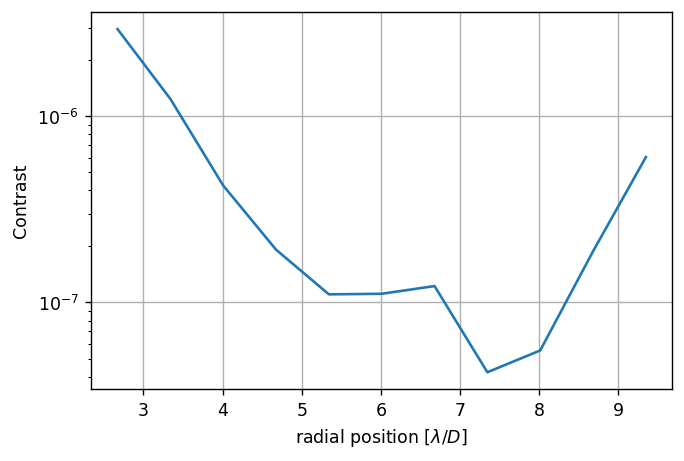

	Closed-loop iteration 7 / 20


(768,)

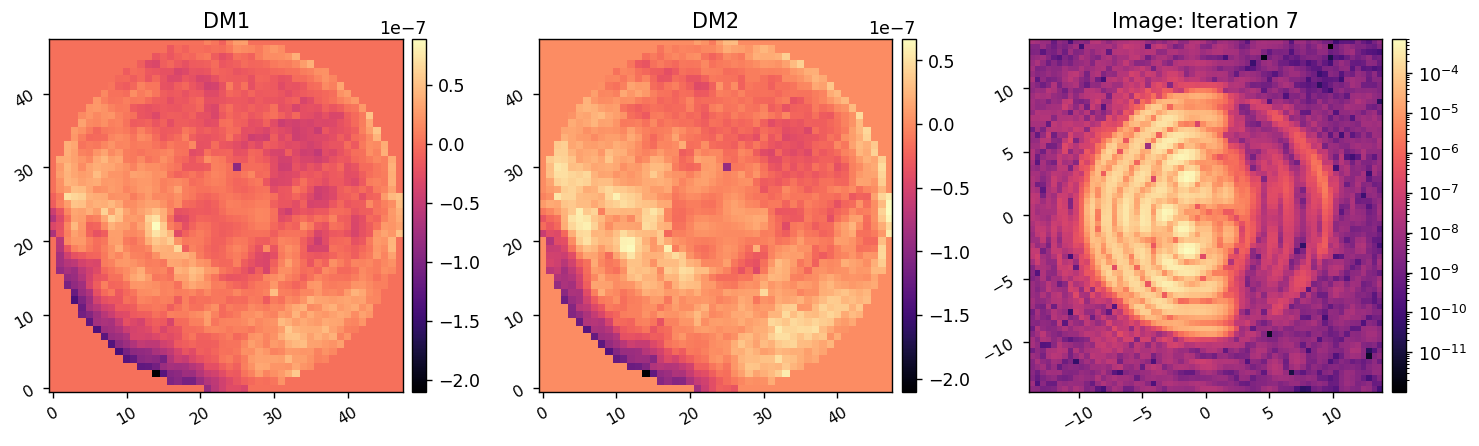

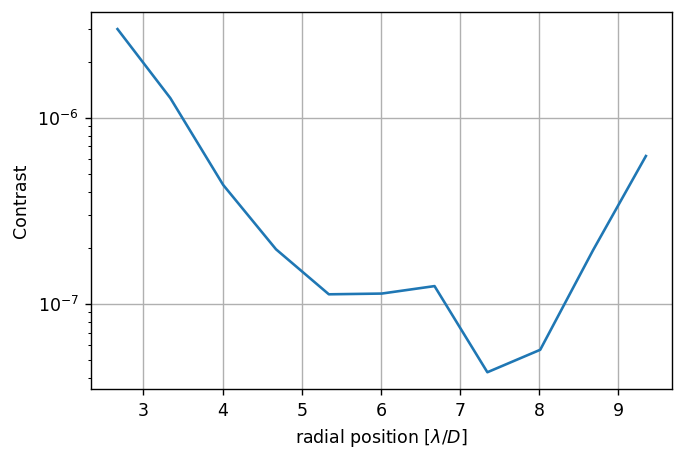

	Closed-loop iteration 8 / 20


(768,)

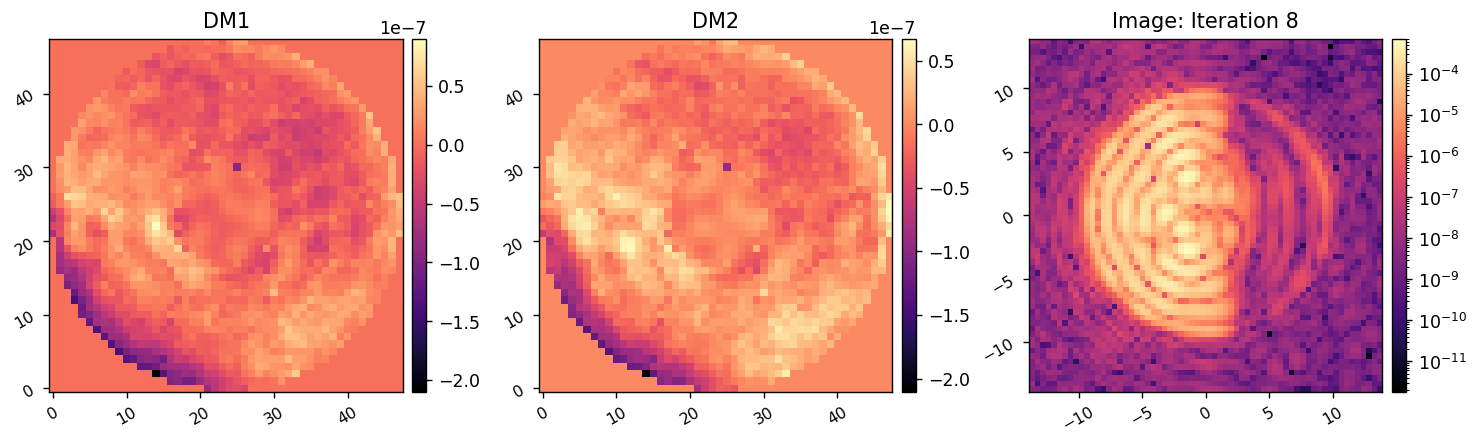

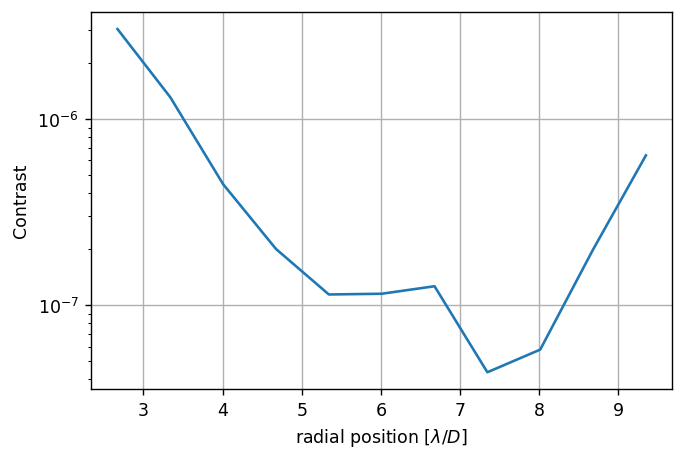

	Closed-loop iteration 9 / 20


(768,)

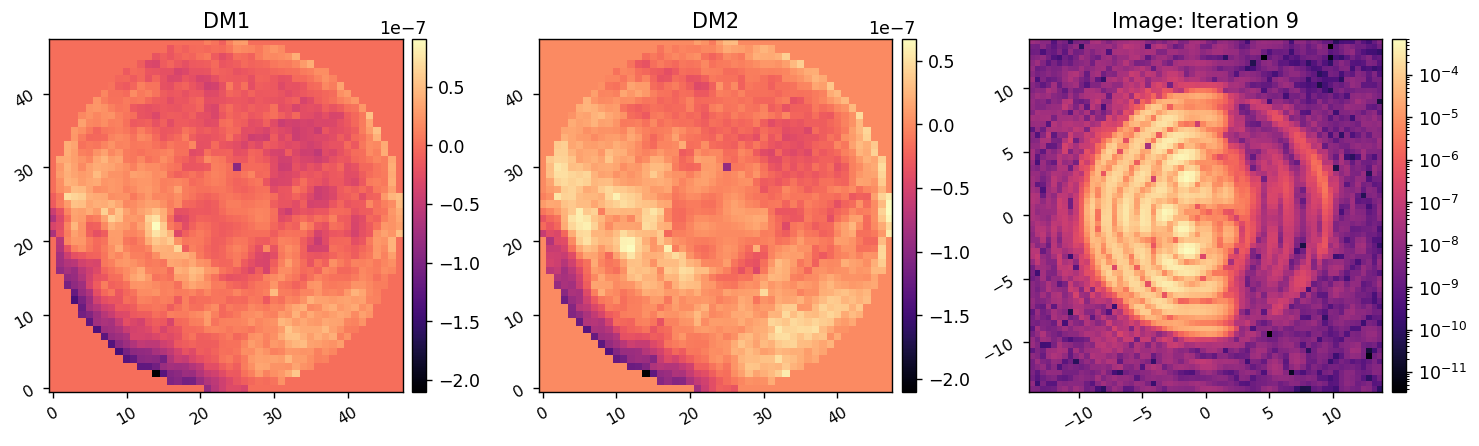

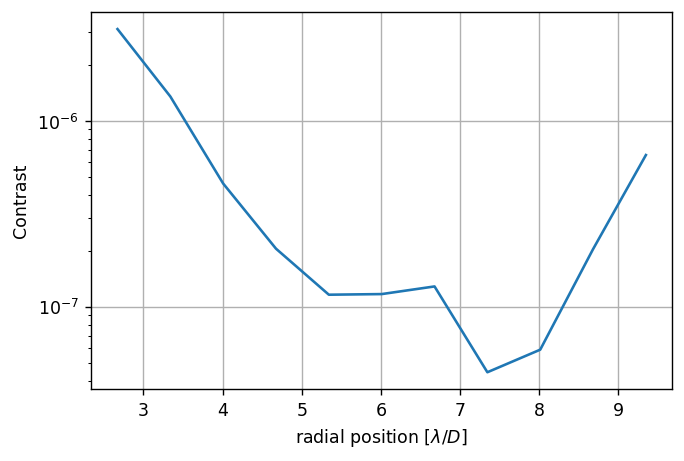

	Closed-loop iteration 10 / 20


(768,)

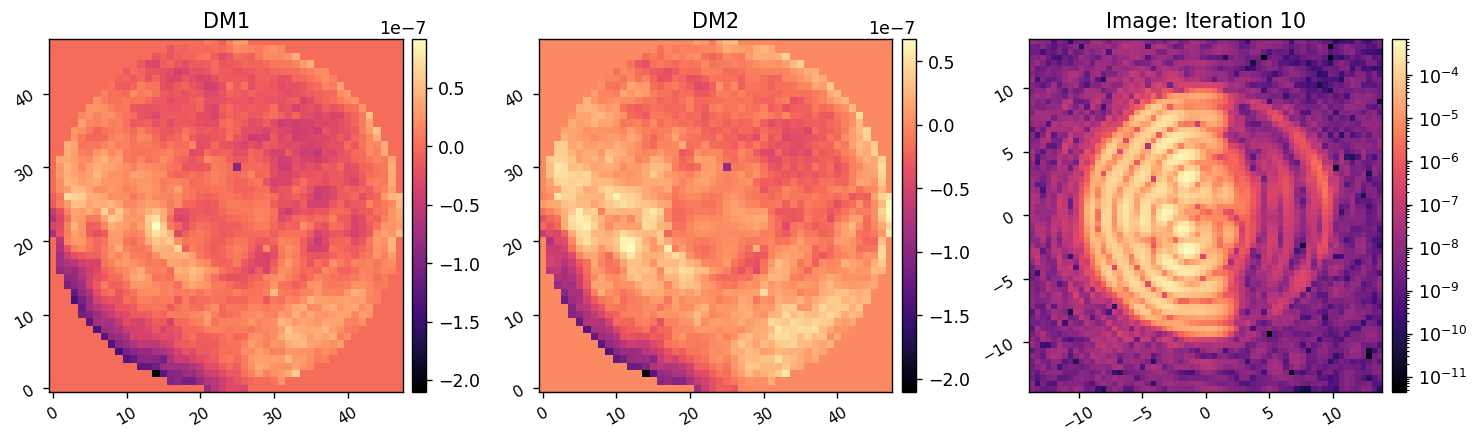

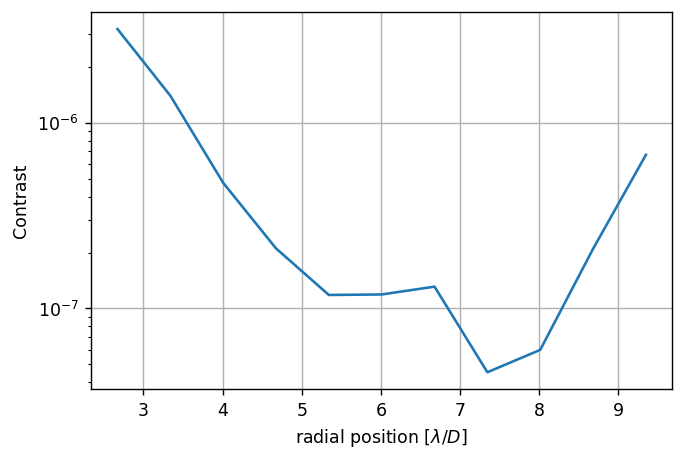

	Closed-loop iteration 11 / 20


(768,)

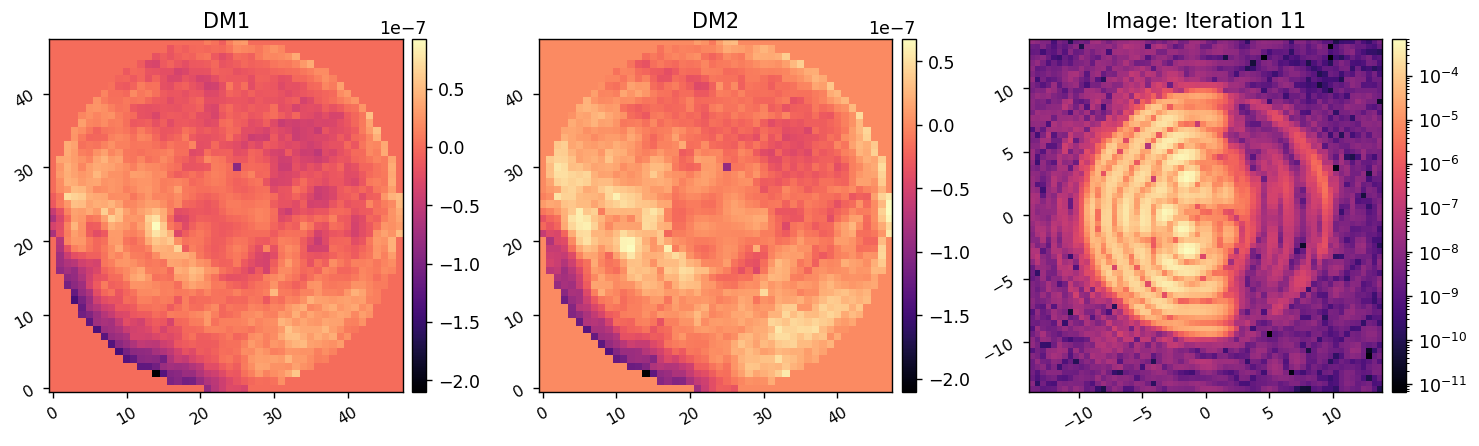

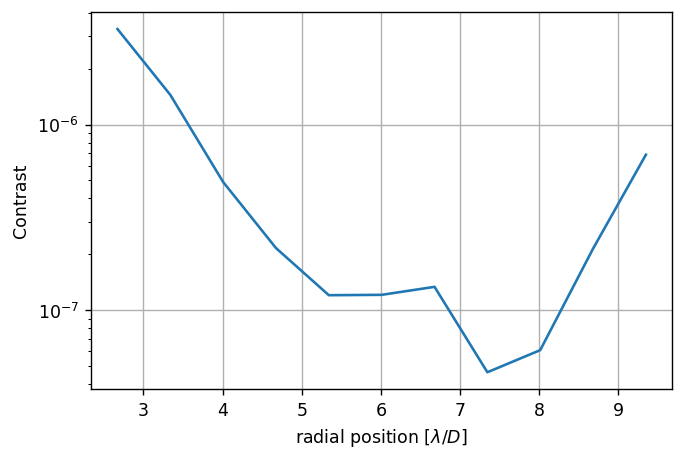

	Closed-loop iteration 12 / 20


(768,)

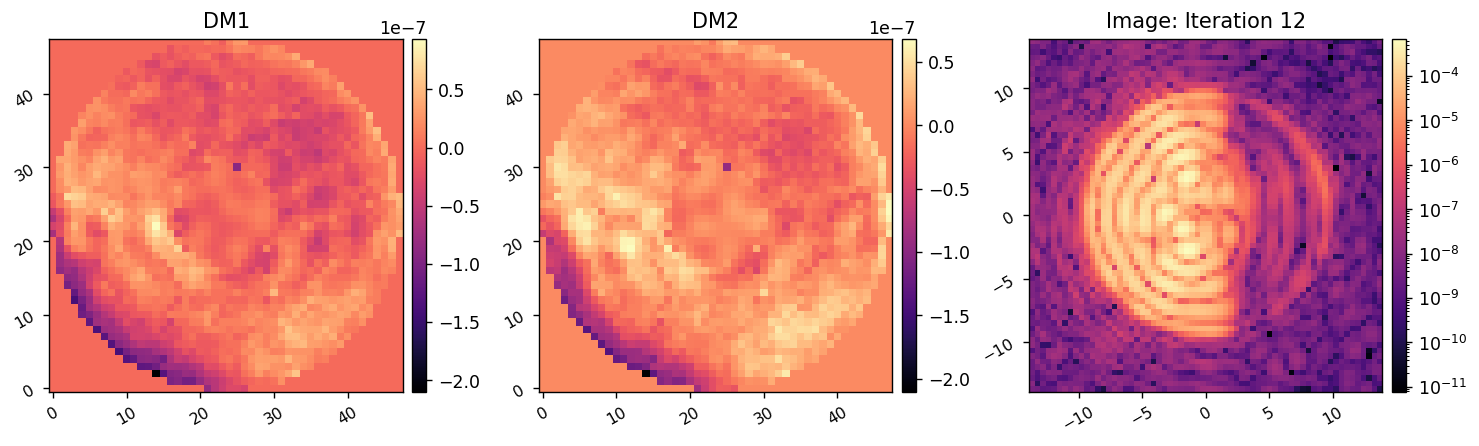

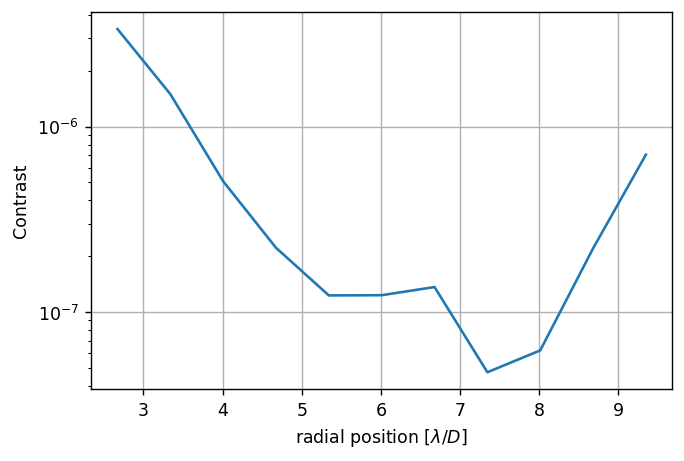

	Closed-loop iteration 13 / 20


(768,)

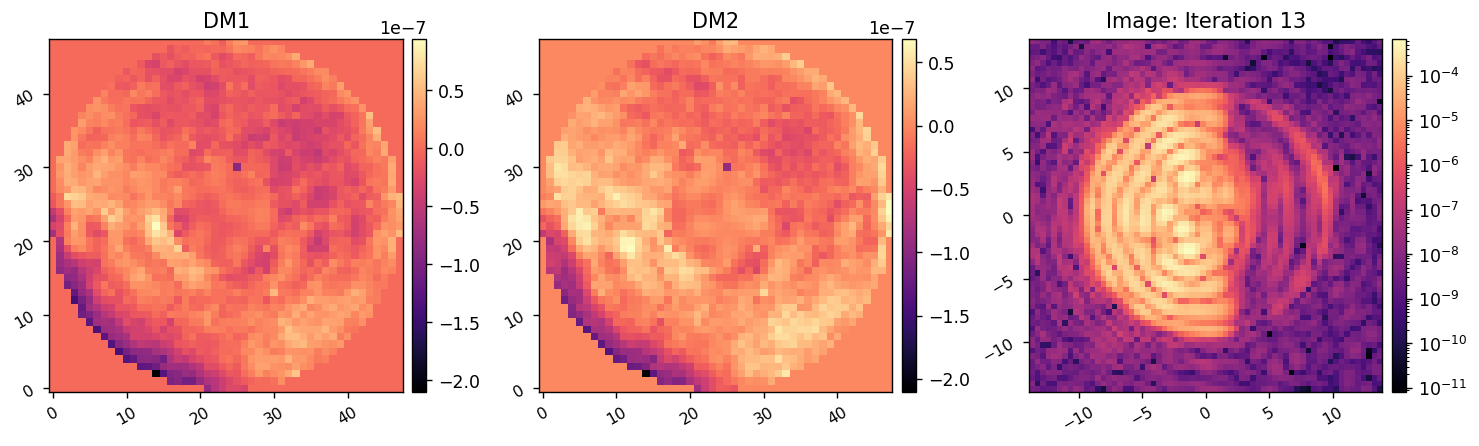

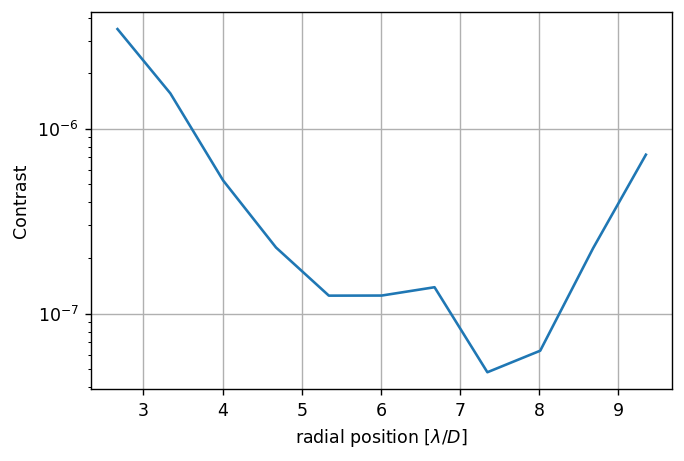

	Closed-loop iteration 14 / 20


(768,)

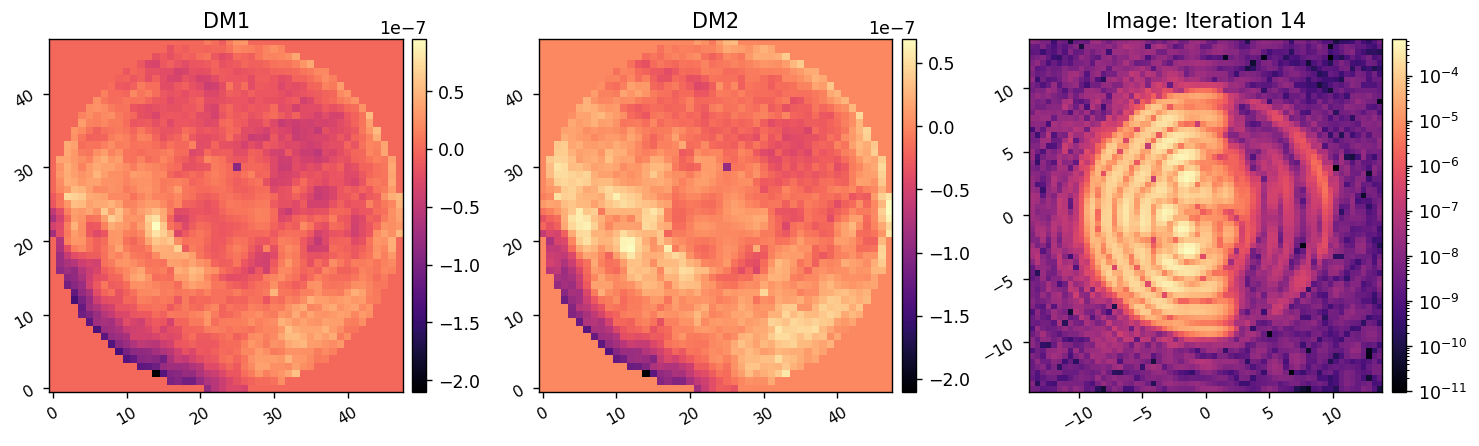

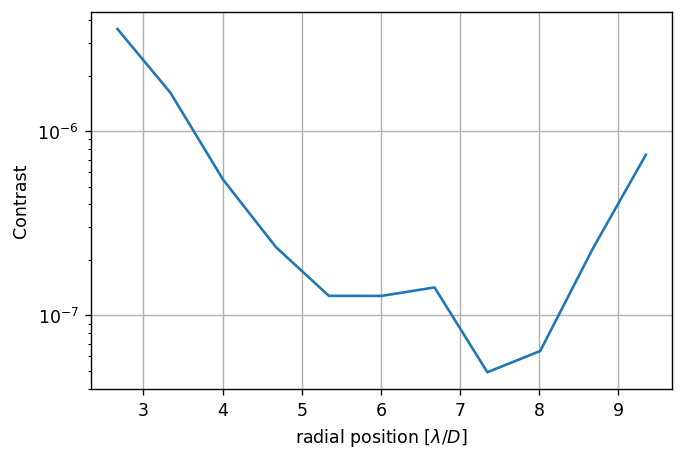

	Closed-loop iteration 15 / 20


(768,)

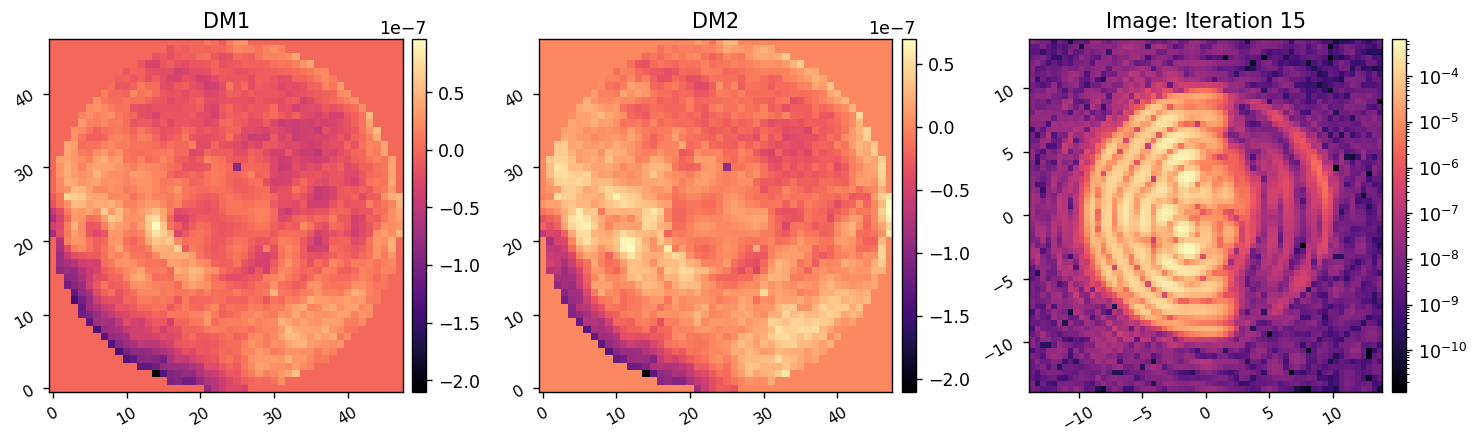

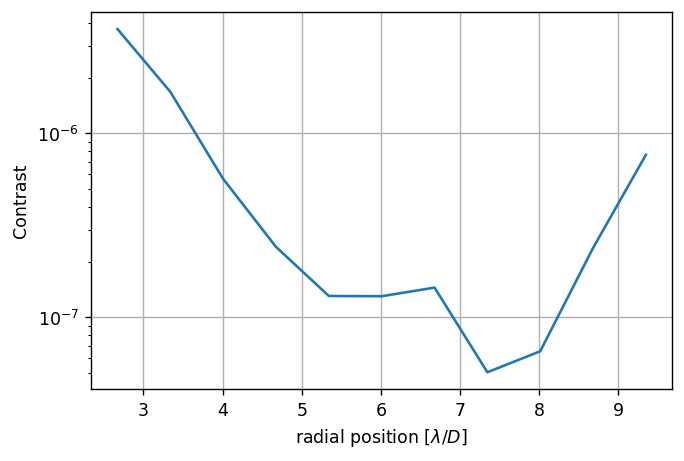

	Closed-loop iteration 16 / 20


(768,)

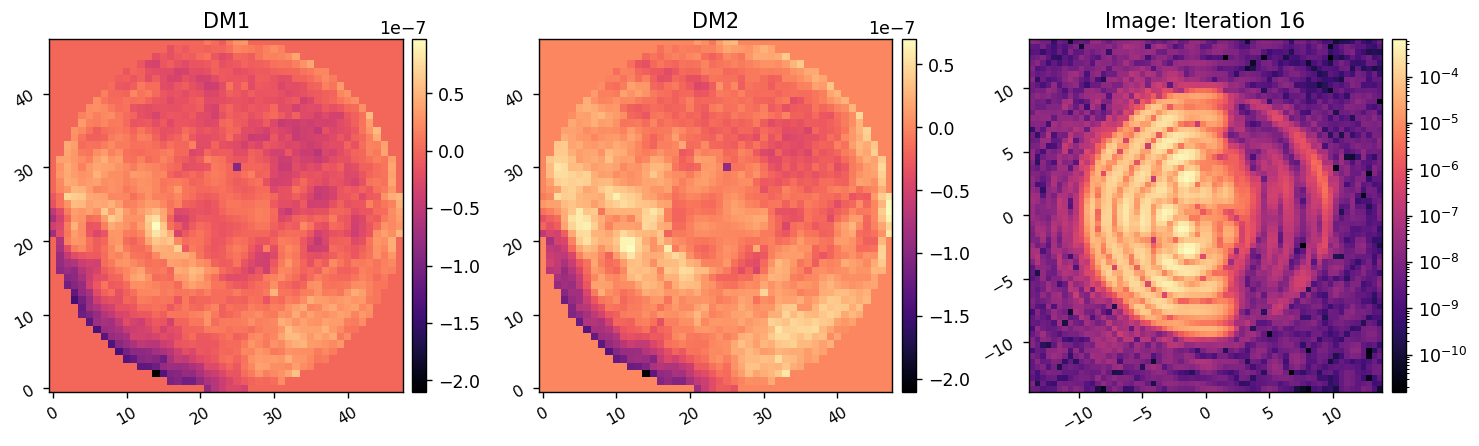

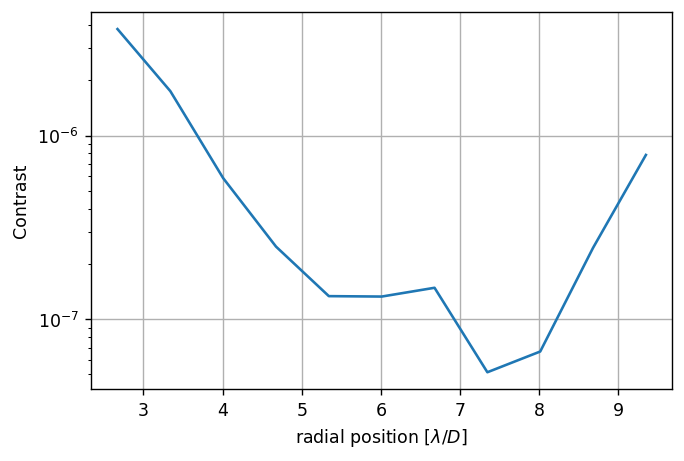

	Closed-loop iteration 17 / 20


(768,)

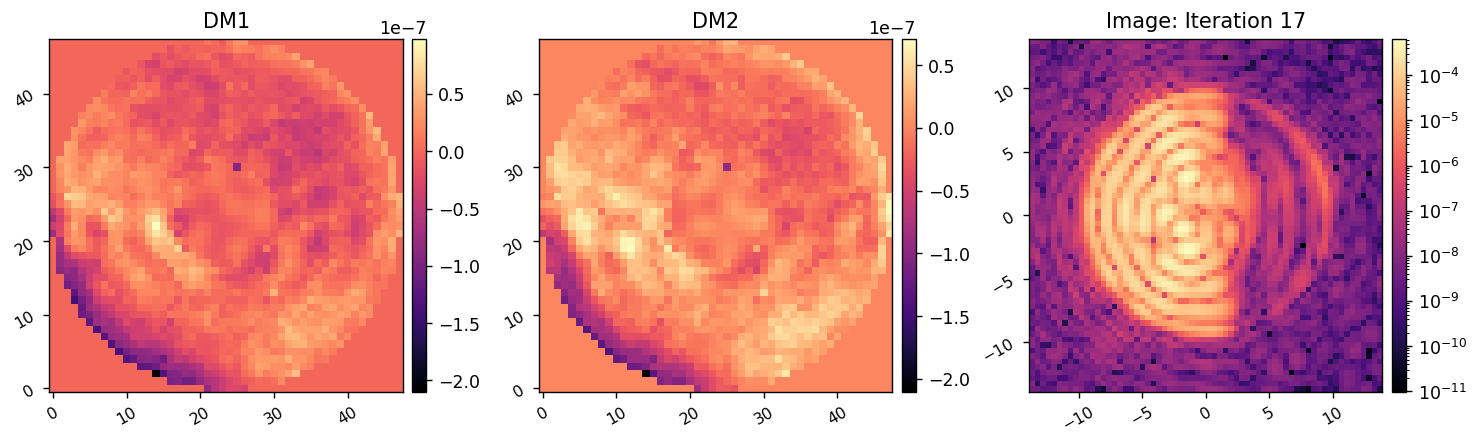

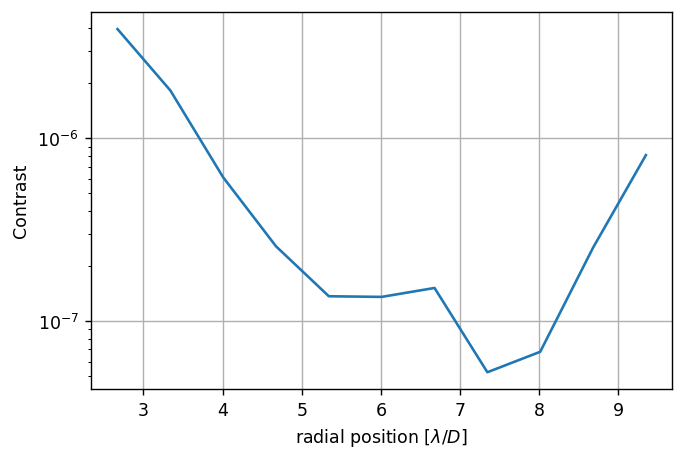

	Closed-loop iteration 18 / 20


(768,)

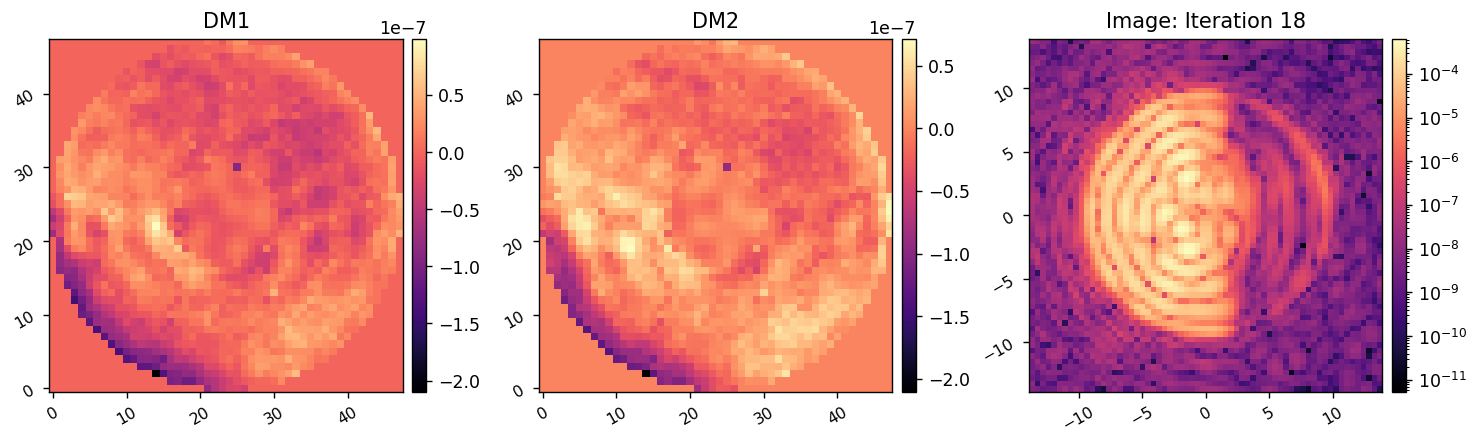

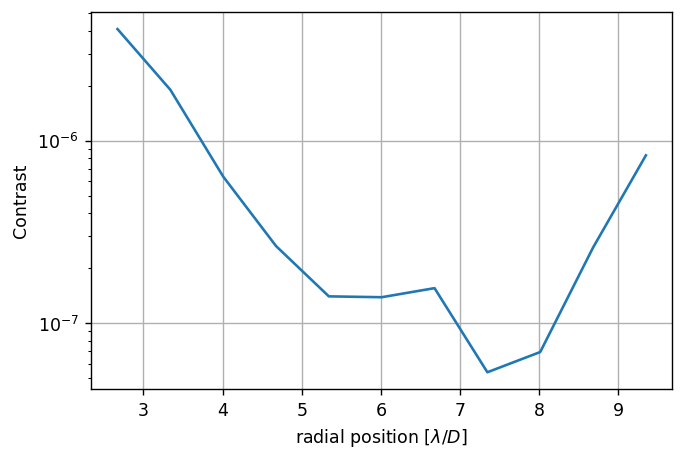

	Closed-loop iteration 19 / 20


(768,)

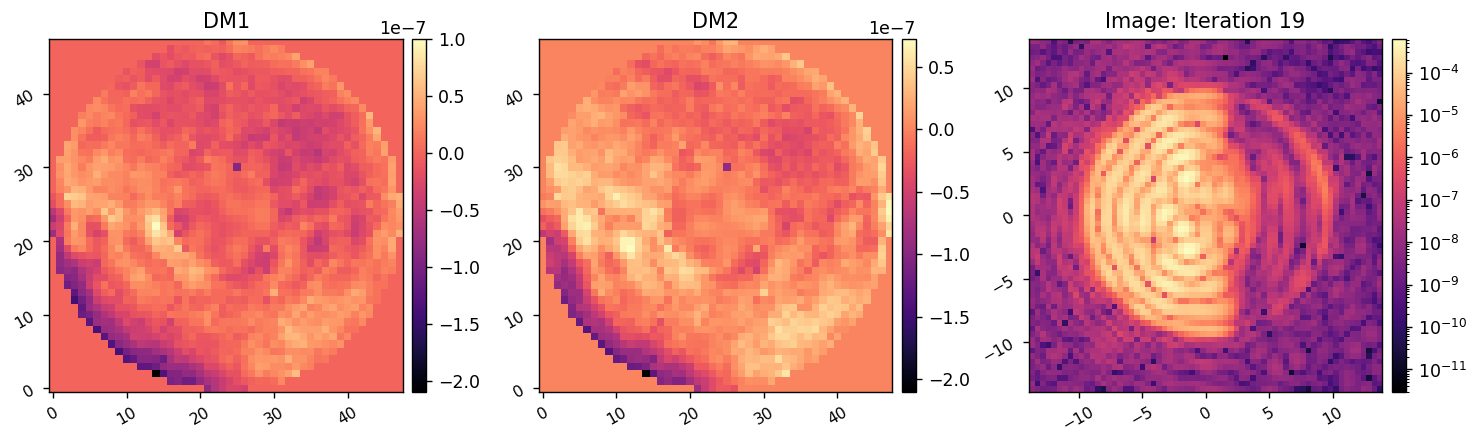

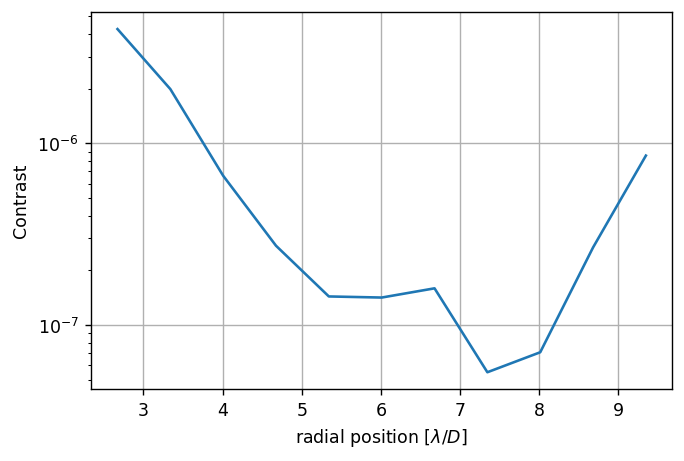

	Closed-loop iteration 20 / 20


KeyboardInterrupt: 

In [33]:
reg_cond = 1e-2
reg_conds = [(1e-3,10), (5e-3, 20), (1e-3, 20)]

# cm_tik = wfsc.utils.TikhonovInverse(response_matrix, rcond=reg_cond)
Wmatrix = np.diag(np.concatenate((weight_map[control_mask], weight_map[control_mask], weight_map[control_mask])))
# cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, Wmatrix, rcond=reg_cond)

dm1_commands_2 = []
dm2_commands_2 = []
for i in range(len(reg_conds)):

    cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, Wmatrix, rcond=reg_conds[i][0])
    
    images, commands_1, commands_2 = wfsc.iefc_2dm.run(c, 
                                              cm_wls,
                                              probe_modes, 
                                              probe_amp, 
                                              fourier_modes,
                                              control_mask, 
                                              num_iterations=reg_conds[i][1], 
                                              loop_gain=0.5, 
                                              leakage=0.0,
                                              plot_all=True,
                                             )
    
    dm1_commands_2.append(commands_1)
    dm2_commands_2.append(commands_2)